In [365]:
#Импортирование необходимых библиотек
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [366]:
#Загрузка и просмотр данных
df = pd.read_csv("bank-additional-full.csv", sep=';')
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

In [367]:
#Посморим размерность данных
df.shape

(41188, 21)

In [368]:
#Посмотрим основную информацию о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Первичное наблюдение
В данных явных пропусков необнаружено, но в документации говорилось, что вместе NaN, есть категория 'unknown' - что означает пропуск

In [369]:
#Проверка на дубликаты
print(f"Всего дубликатов: {int(df.duplicated().sum())}")

Всего дубликатов: 12


In [370]:
#Дубликаты необходимо удалить, так как они приведут к мультиколлениарности из-за чего линейные медели датут плохой результат
df.drop_duplicates(inplace=True)
print("Дубликаты удалены!")

Дубликаты удалены!


In [371]:
#Проверка на дубликаты
print(f"Всего дубликатов: {int(df.duplicated().sum())}")
#Будликаты удалены!

Всего дубликатов: 0


In [372]:
#Целевая переменная имеет тип данных object, закодируем
#1 - подпишет депозит, если 0, значит нет
df["y"] = df["y"].apply(lambda x: 1 if x=="yes" else 0)
df["y"]

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: y, Length: 41176, dtype: int64

### Разделение признаков
- Вещественные (int, float)
- Категориальные (object)
- Целевая переменная

In [373]:
df_num_columns = df[df.columns[df.dtypes != object]]
df_cat_columns = df[df.columns[df.dtypes == object]]
target = df["y"]
print(f"Суммарное количество признаков: {df_num_columns.shape[1] + df_cat_columns.shape[1]}")

Суммарное количество признаков: 21


### Одномерный анализ целевой переменной
**Цель анализа**: Выяснить, есть ли в данных дисбаланс, на основе данного исследования будет выбрана та или иная метрика

Класс 0: 88.7%
Класс 1: 11.3%


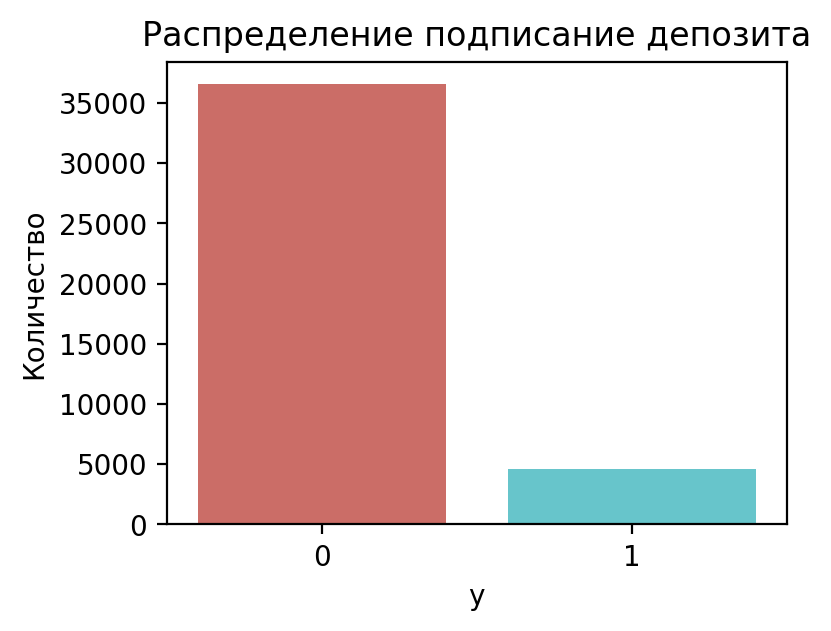

In [374]:
fig = plt.figure(figsize=(4, 3), dpi=200)
print(f"Класс 0: {round(df["y"].value_counts().iloc[0] / len(df), 3) * 100}%")
print(f"Класс 1: {round(df["y"].value_counts().iloc[1] / len(df), 3) * 100}%")
plt.title("Распределение подписание депозита")
plt.ylabel("Количество")
sns.countplot(data=df, x="y", palette="hls")
plt.show()

### Решение
Видно, что выборка сильно несбалансирована, тогда метрику accuracy выбирать нельзя

Будут выбраны метрики F1-score, auc-roc, precision, recall, pr-auc 

### Глубинный одномерный анализ для вещественных признаков
**Цель анализа**
- Посмотреть распределение признаков
- Отследить потенциальные выбросы
- Отследить константные или квазиконстантыне признаки

### Описание вещественных признаков
| Название признака | Название на русском | Тип данных | Описание | Примечания |
| :--- | :--- | :--- | :--- | :--- |
| **`age`** | Возраст | Числовой | Возраст клиента. | |
| **`duration`** | Длительность звонка | Числовой | Длительность последнего звонка в сек. | **"Утечка из будущего". Удалить.** |
| **`campaign`** | Кол-во контактов | Числовой | Количество звонков в **текущей** кампании. | |
| **`pdays`** | Дней с прошлого контакта | Числовой | Дней с момента прошлого контакта. | `999` означает "не контактировали". |
| **`previous`** | Кол-во прошлых контактов | Числовой | Количество контактов **до** текущей кампании. | |
| **`emp.var.rate`** | Изменение занятости | Числовой | Квартальный индикатор уровня занятости. | Соц-эконом. признак. |
| **`cons.price.idx`**| Индекс потреб. цен | Числовой | Месячный индикатор индекса потреб. цен. | Соц-эконом. признак. |
| **`cons.conf.idx`**| Индекс уверенности| Числовой | Месячный индикатор индекса потреб. уверенности. | Соц-эконом. признак. |
| **`euribor3m`** | Ставка Euribor | Числовой | Ежедневный индикатор ставки Euribor. | Соц-эконом. признак. |
| **`nr.employed`** | Число занятых | Числовой | Квартальный индикатор числа занятых. | Соц-эконом. признак. |

In [375]:
#Посмотрим на основные статистики
df_num_columns.describe()

age      duration      campaign         pdays      previous  \
count  41176.00000  41176.000000  41176.000000  41176.000000  41176.000000   
mean      40.02380    258.315815      2.567879    962.464810      0.173013   
std       10.42068    259.305321      2.770318    186.937102      0.494964   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m  \
count  41176.000000    41176.000000   41176.000000  41176.000000   
mean       0.081922       93.575720     -40.502863      3.621293   
std        1.570883        0.578839       4.627860      1.734437   
min       -3.400000       92.201000     -50.800000      0.634000   
25%       -1.800000       93.075000     -42.700000      1.344000   
50%        1.100000       93.749000     -41.800000      4.857000   
75%        1.400000       93.994000     -36.400000      4.961000   
max        1.400000       94.767000     -26.900000      5.045000   

        nr.employed             y  
count  41176.000000  41176.000000  
mean    5167.034870      0.112663  
std       72.251364      0.316184  
min     4963.600000      0.000000  
25%     5099.100000      0.000000  
50%     5191.000000      0.000000  
75%     5228.100000      0.000000  
max     5228.100000      1.000000

In [376]:
df_num_columns.skew()

age               0.784560
duration          3.262808
campaign          4.762044
pdays            -4.921386
previous          3.831396
emp.var.rate     -0.724061
cons.price.idx   -0.230853
cons.conf.idx     0.302876
euribor3m        -0.709194
nr.employed      -1.044317
y                 2.450195
dtype: float64

In [377]:
df_num_columns.kurt()

age                0.791113
duration          20.243771
campaign          36.971857
pdays             22.221553
previous          20.102164
emp.var.rate      -1.062698
cons.price.idx    -0.829851
cons.conf.idx     -0.359097
euribor3m         -1.406791
nr.employed       -0.003540
y                  4.003650
dtype: float64

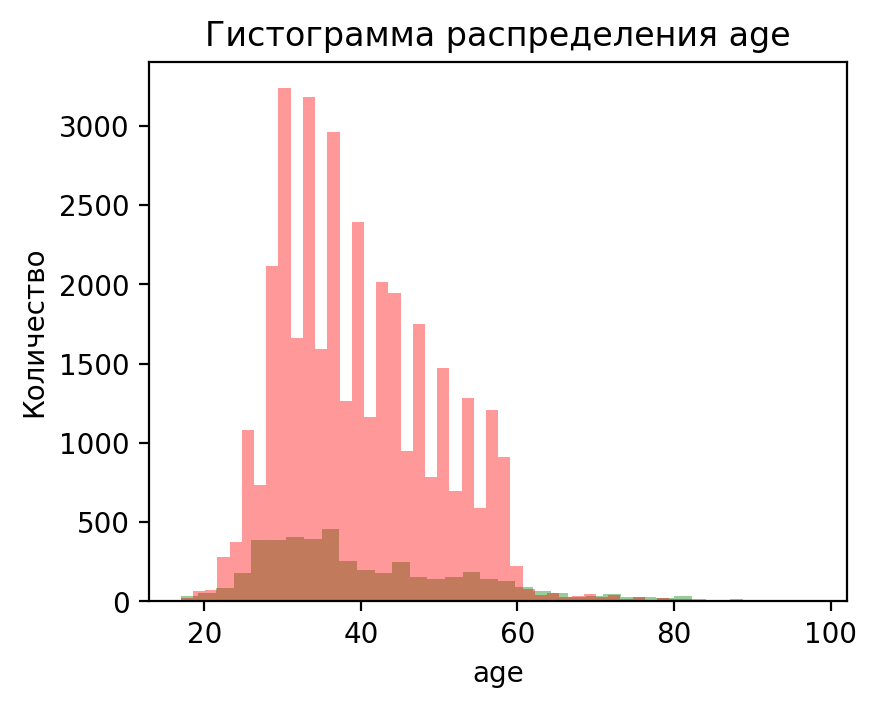

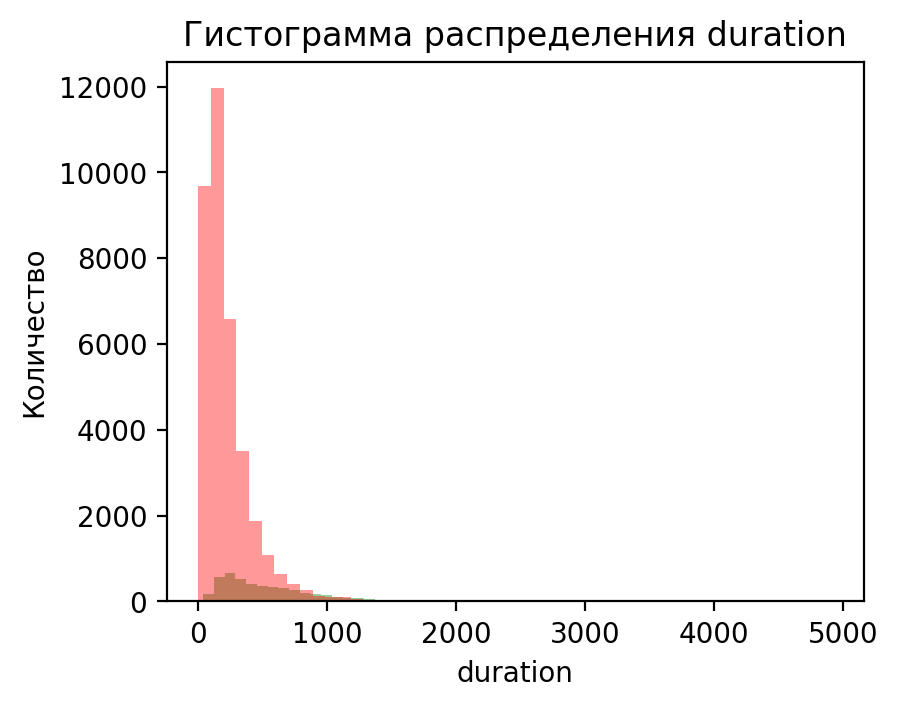

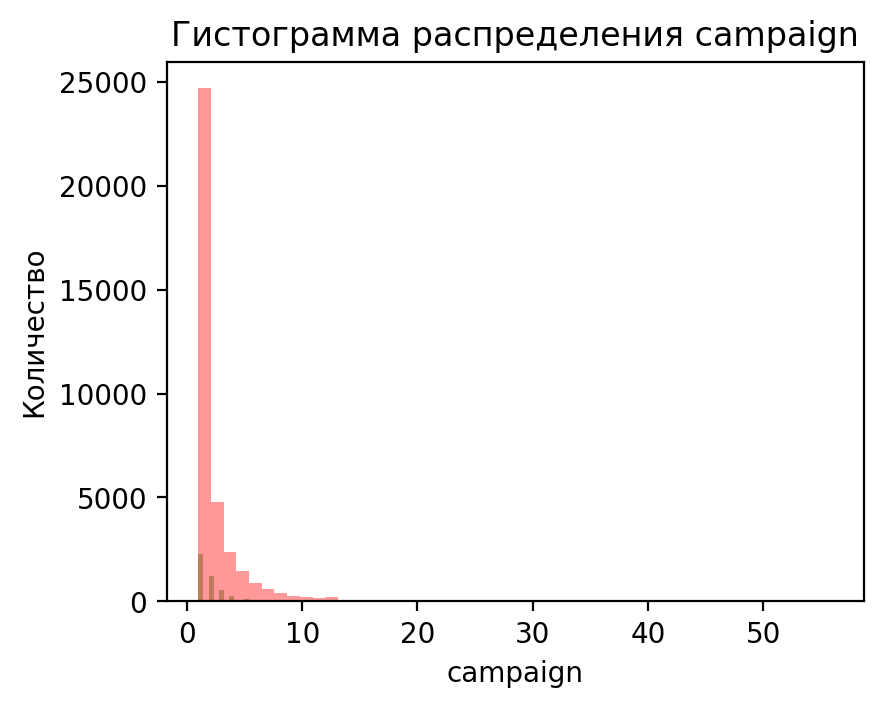

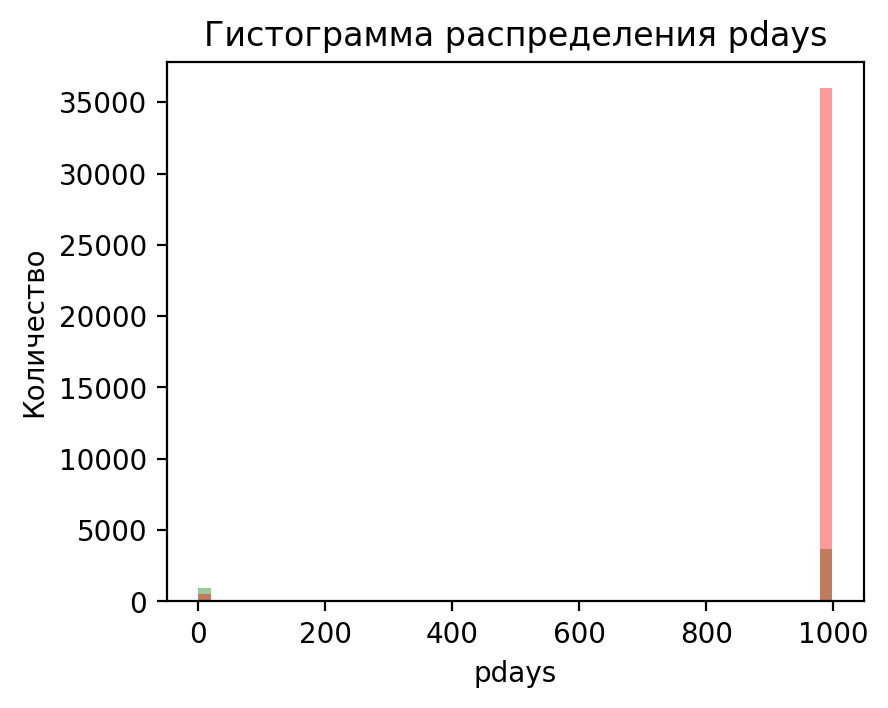

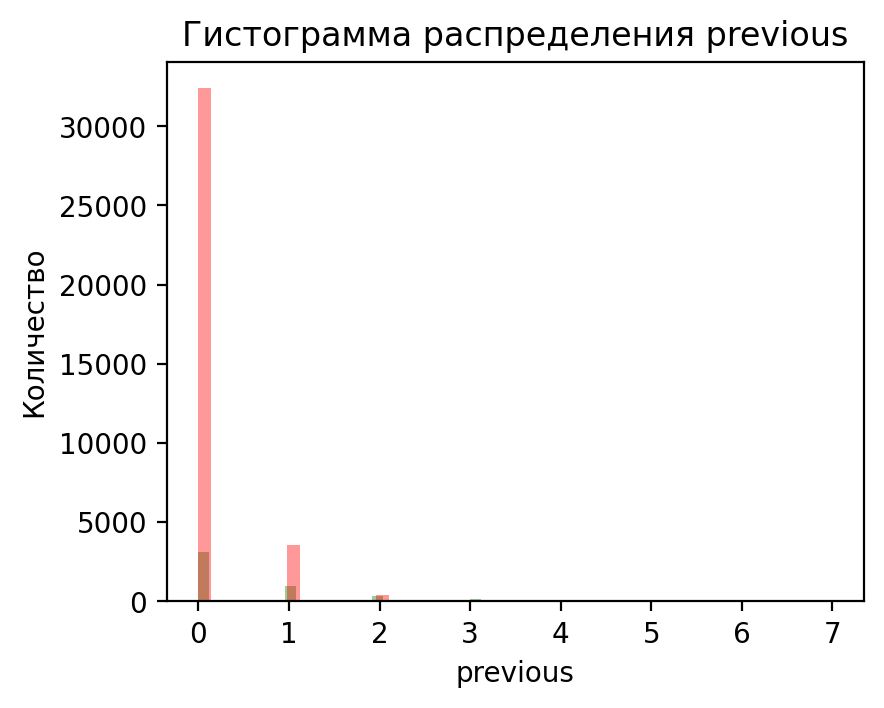

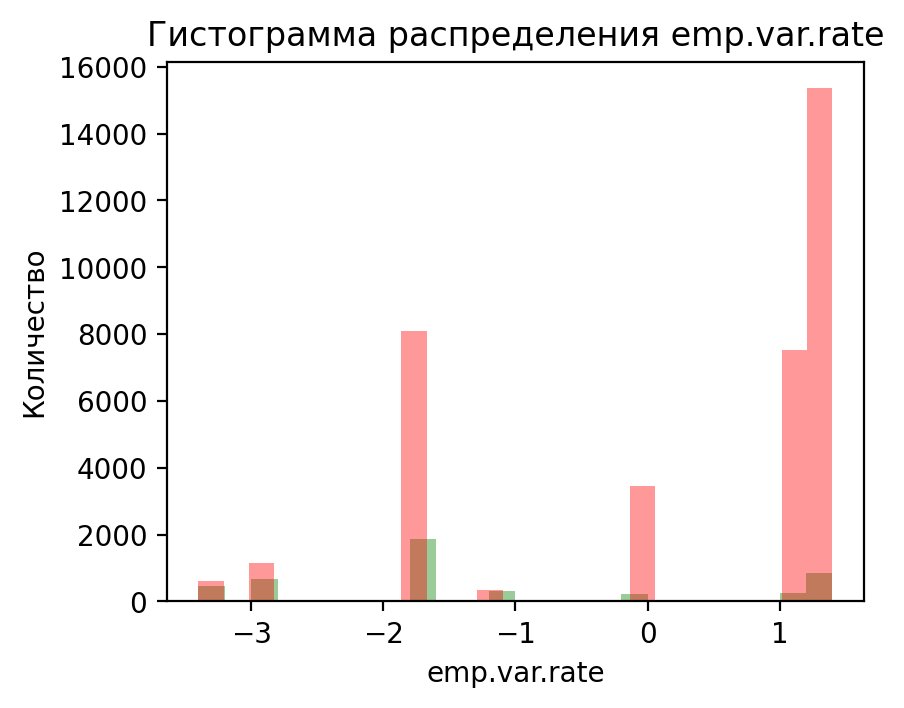

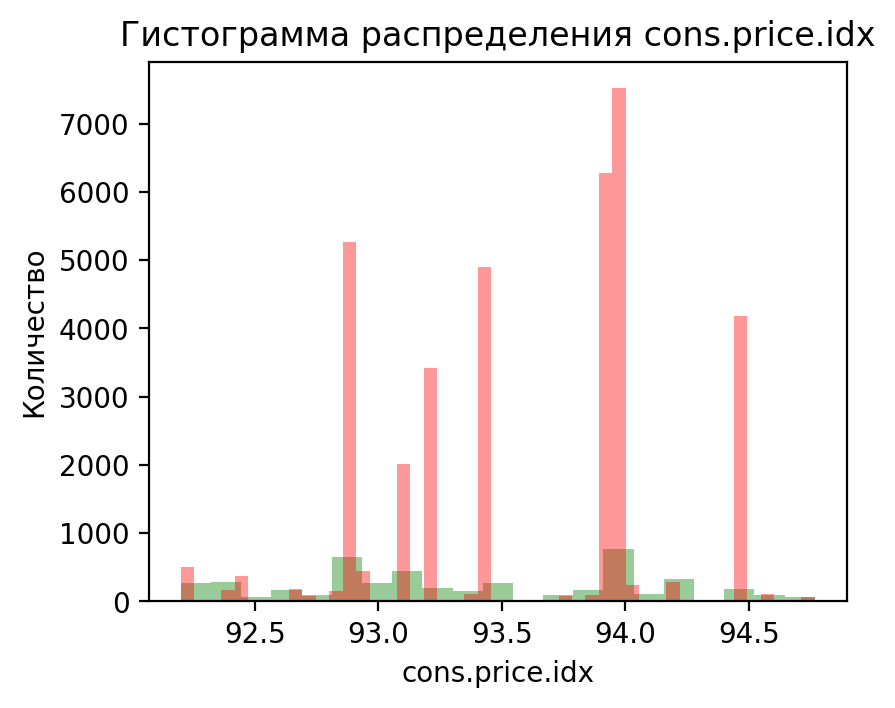

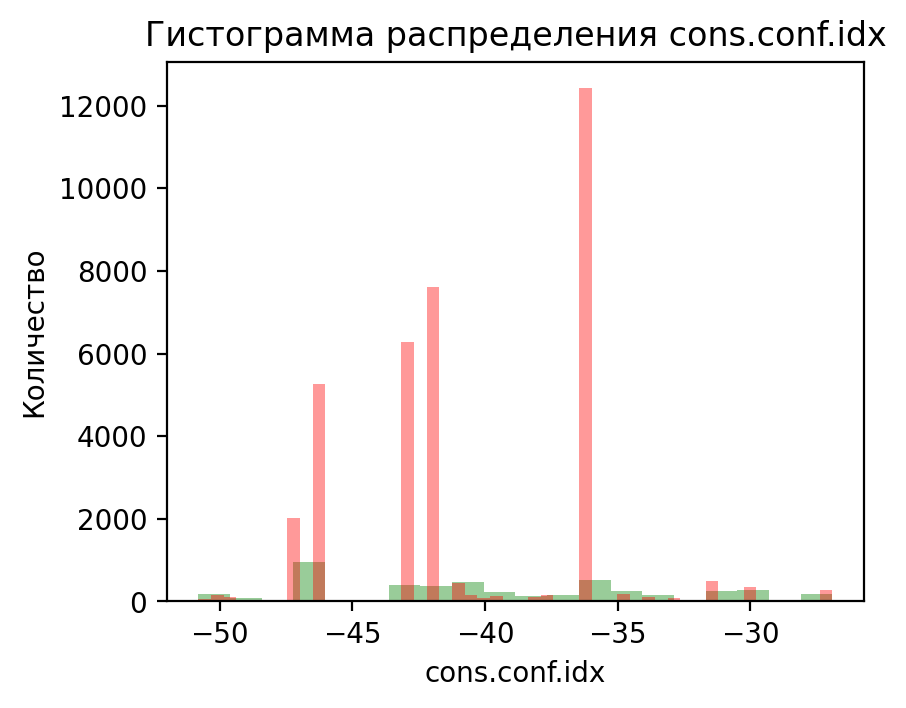

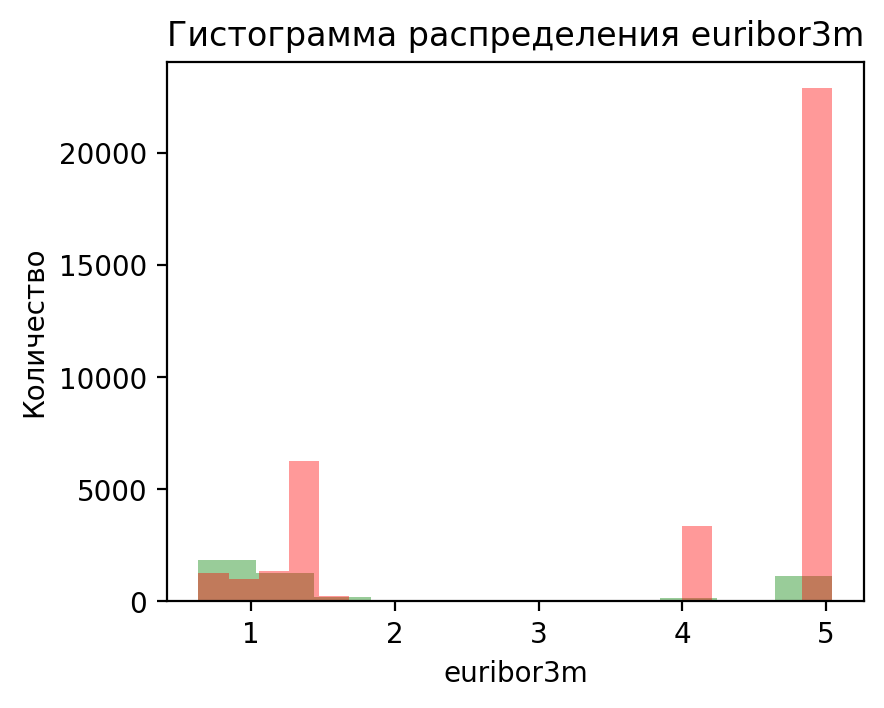

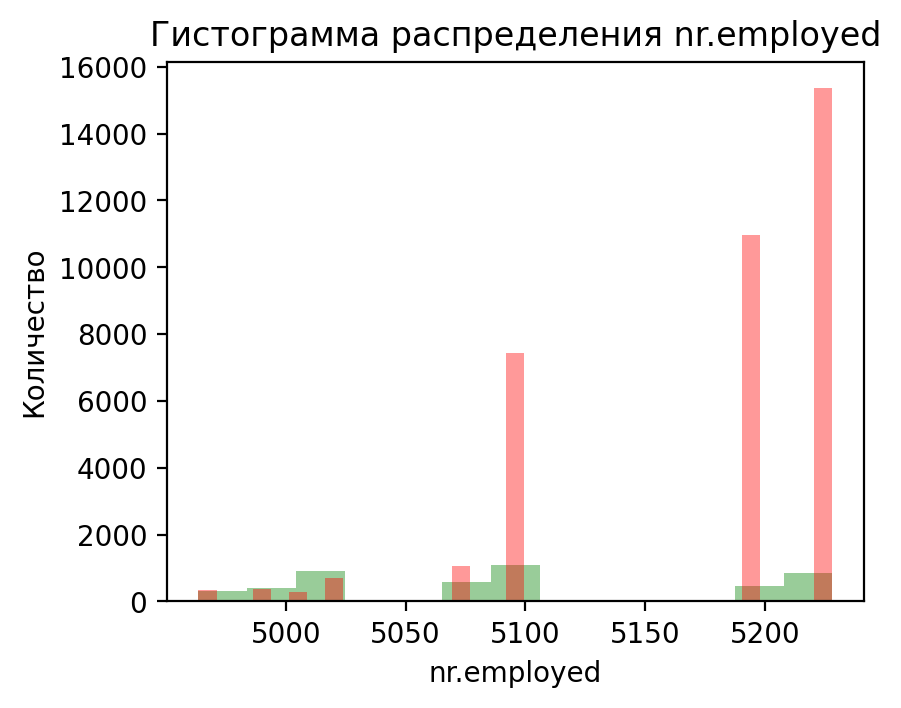

In [378]:
for col in df_num_columns.drop("y", axis=1).columns:
    fig = plt.figure(figsize=(4.5, 3.5), dpi=200)
    plt.title(f"Гистограмма распределения {col}")
    plt.ylabel("Количество")
    plt.xlabel(f"Значение признака {col}")
    sns.distplot(a=df_num_columns[df_num_columns["y"]==1][col], kde=False, color="green")
    sns.distplot(a=df_num_columns[df_num_columns["y"]==0][col], kde=False, color="red")
    plt.show()

### Age - возраст клиента, campaign - количество звонков в текущей компании
Данные признаки можно прологорифмирвать, чтобы привести их к нормальному распределению

### pdays - дней с прошлого контакта
С многими клиентами не было контакта, данный признак можно сделать бинарным, был ли контакт, или его не было 

### Duration - длительность звонка
В документации написано, что данный признак показывает, сколько длился диолог между человеком, которому предлагали депозит и который прелагал

Суть в том, что модель нужна для того, чтобы выявить человека, который более склонен взять депозит, если человек склонен, то ему стоит позвонить
и предложить взять депозит, поэтому признак duration стоит удалить, так как это утечка данных из будущего

In [379]:
#Прологарифмируем признаки age и campaign, хоть и признак age больше похож на нормальное распределение, но после логарифмирования будет похож больше
df_num_columns["age"] = np.log1p(df_num_columns["age"])
df_num_columns["campaign"] = np.log1p(df_num_columns["campaign"])
print("Данные признаки были прологорифмированы!")

Данные признаки были прологорифмированы!


In [380]:
#Видно, что +- распределение целевой переменной равномерное, поэтому стоит сделать бинарный признак, который будет показывать
#Был ли контакт, а признак pdays удалить, так как значчение 999 встречаеться более 90% случаев, приветсти его к 0 тоже неверно, так как 0 это недавний
#контакт, поэтому будет создан бинырный признак
df.groupby("pdays")["y"].mean()

pdays
0      0.666667
1      0.307692
2      0.606557
3      0.678815
4      0.533898
5      0.630435
6      0.701456
7      0.666667
8      0.666667
9      0.546875
10     0.576923
11     0.535714
12     0.448276
13     0.777778
14     0.550000
15     0.666667
16     0.545455
17     0.250000
18     0.571429
19     0.333333
20     0.000000
21     1.000000
22     0.666667
25     1.000000
26     1.000000
27     1.000000
999    0.092585
Name: y, dtype: float64

In [381]:
df_num_columns["presence_of_contact"] = df_num_columns["pdays"].apply(lambda x: 0 if x==999 else 1)
print("Признак presence_of_contact закодирован!")
df_num_columns.drop("pdays", axis=1, inplace=True)
print("Признак pdays был удалён!")

Признак presence_of_contact закодирован!
Признак pdays был удалён!


In [382]:
df_num_columns.drop("duration", axis=1, inplace=True)
print("Признак duration был удалён!")

Признак duration был удалён!


In [383]:
#Видно, что от количетсво контантов прошлых компаний наблюдается положитльная корреляция
#Это логично, если человек, контактирует с многими компаниями, значит он заинтересован депозитом, если иначе, то он бы не контактировал
df_num_columns.groupby("previous")["y"].mean()

previous
0    0.088324
1    0.212015
2    0.464191
3    0.592593
4    0.542857
5    0.722222
6    0.600000
7    0.000000
Name: y, dtype: float64

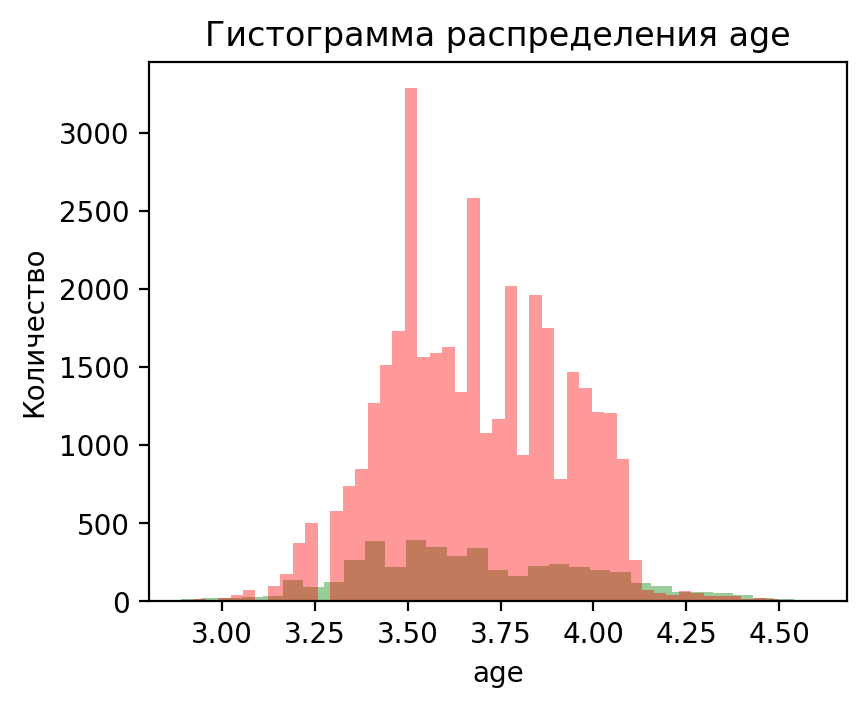

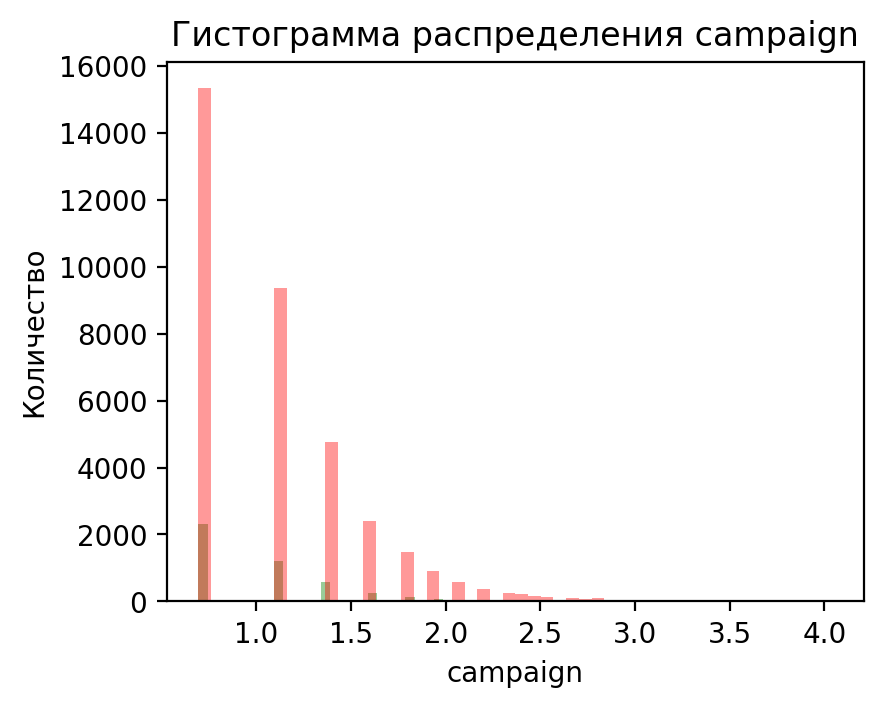

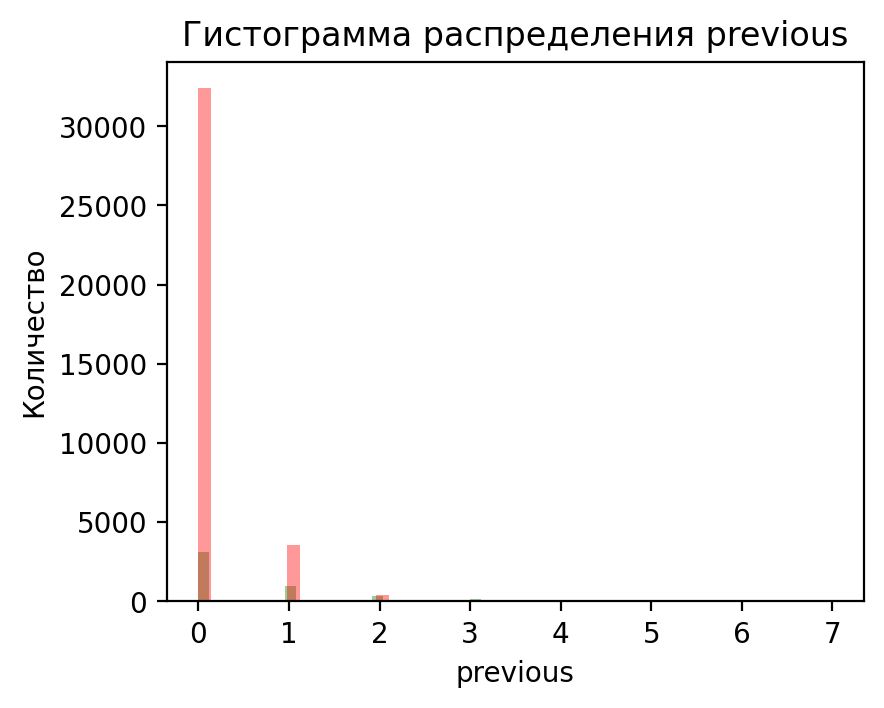

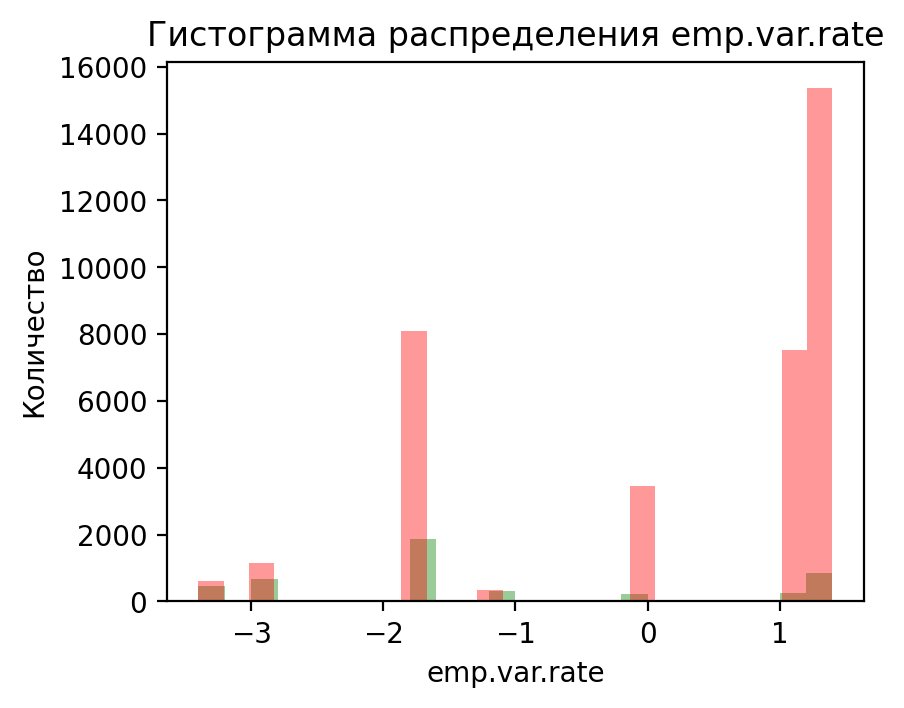

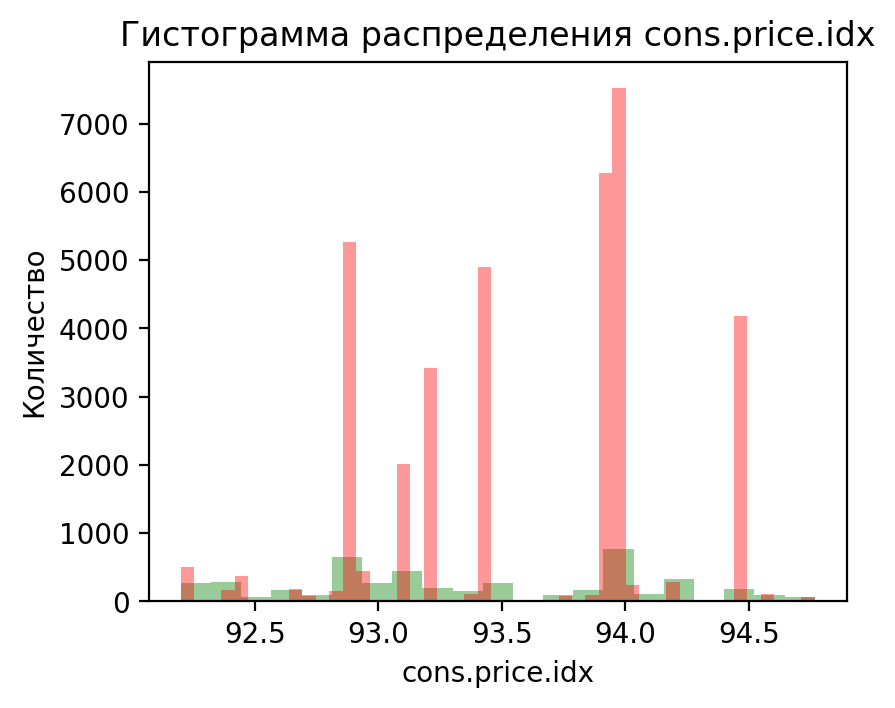

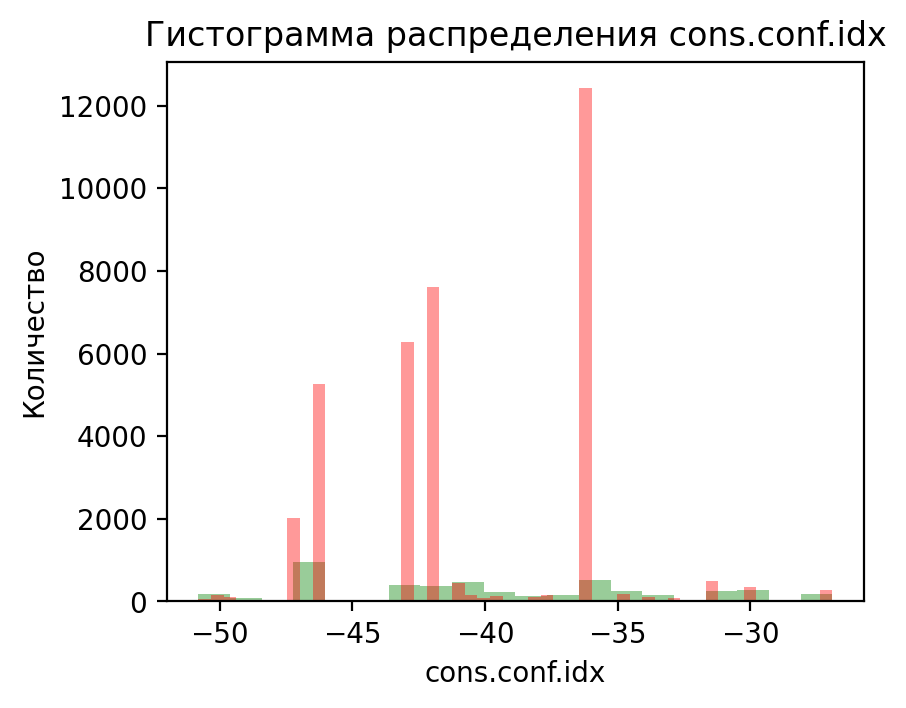

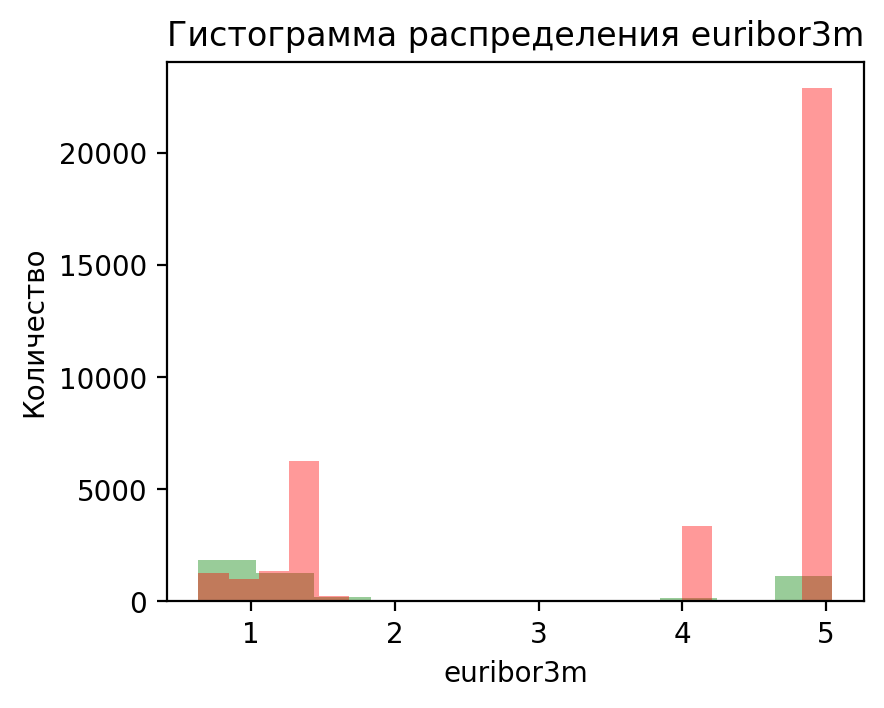

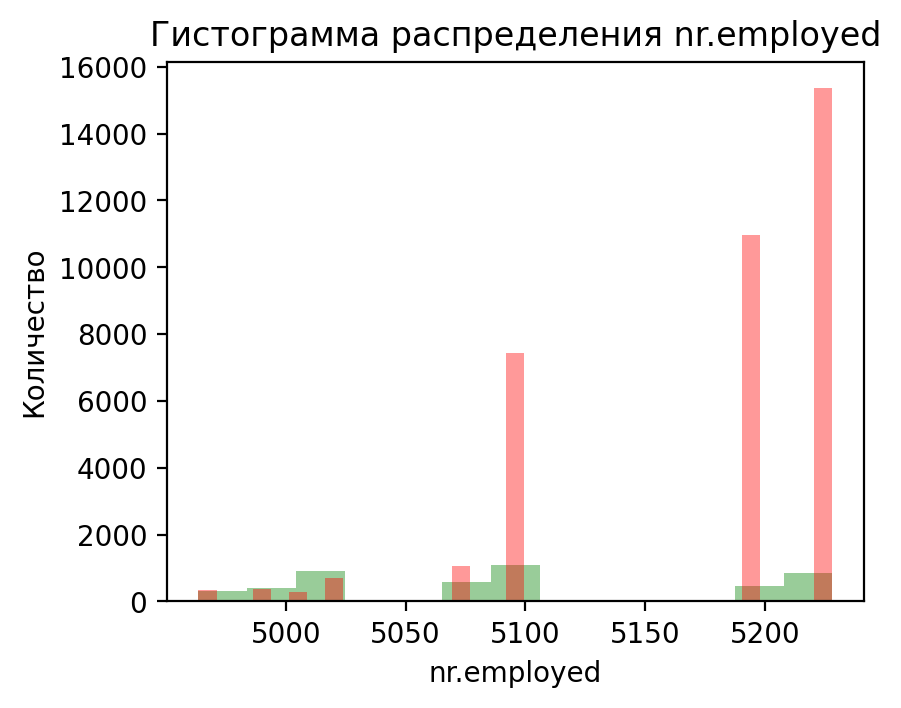

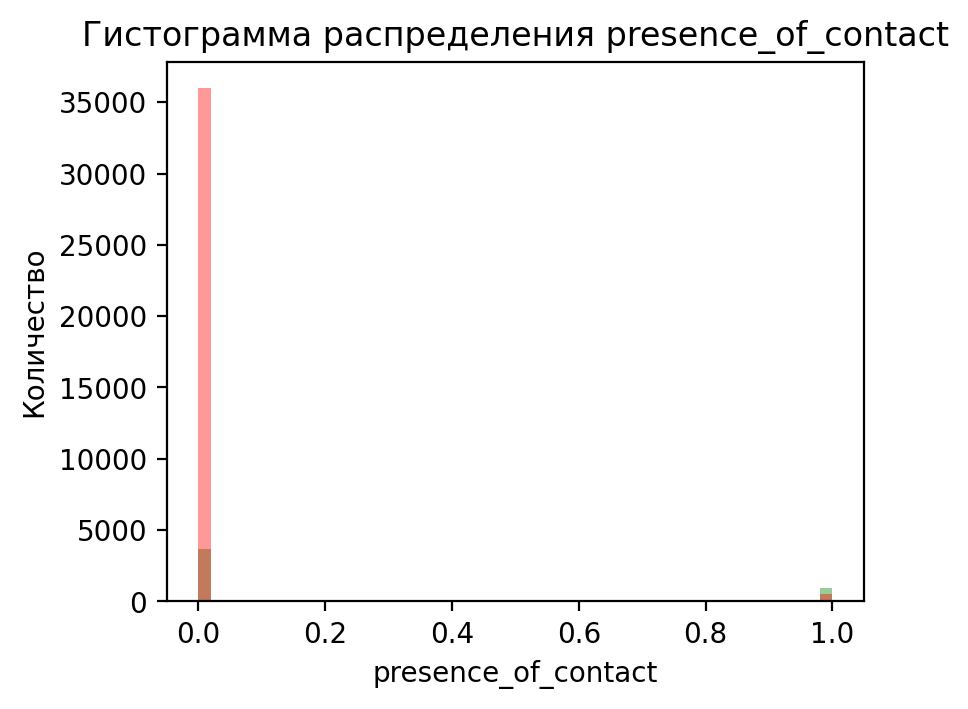

In [384]:
#Помотрим на распределения после преобразований
for col in df_num_columns.drop("y", axis=1).columns:
    fig = plt.figure(figsize=(4.5, 3.5), dpi=200)
    plt.title(f"Гистограмма распределения {col}")
    plt.ylabel("Количество")
    plt.xlabel(f"Значение признака {col}")
    sns.distplot(a=df_num_columns[df_num_columns["y"]==1][col], kde=False, color="green")
    sns.distplot(a=df_num_columns[df_num_columns["y"]==0][col], kde=False, color="red")
    plt.show()

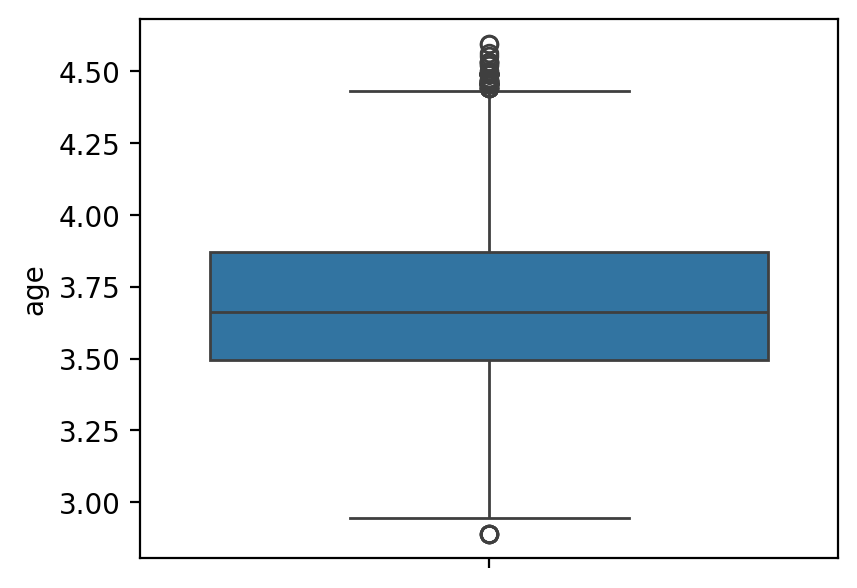

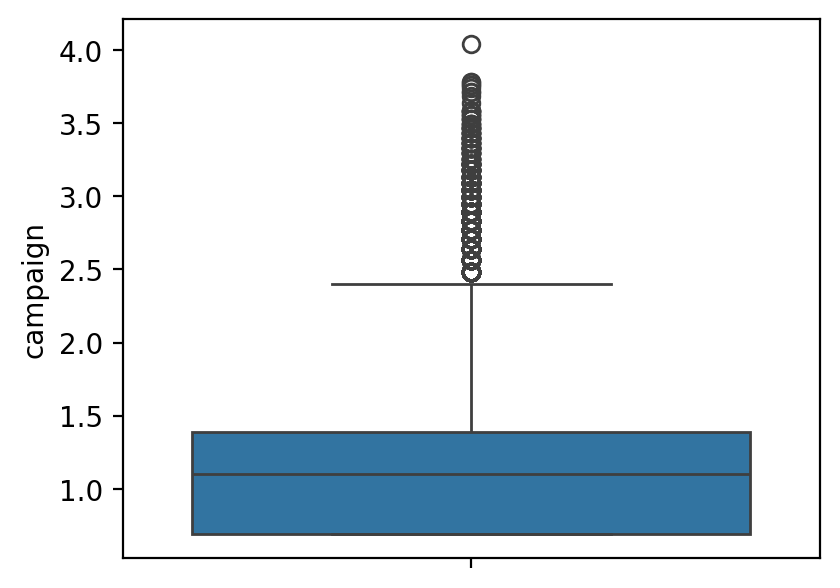

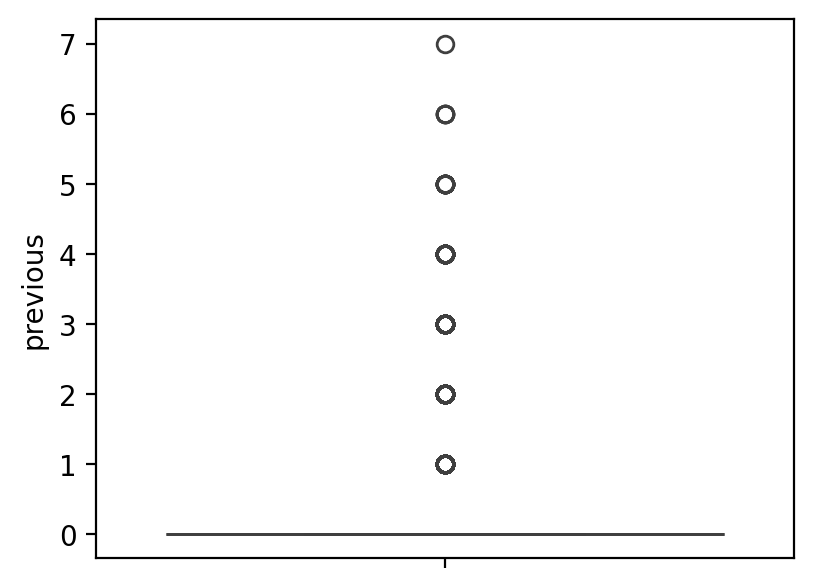

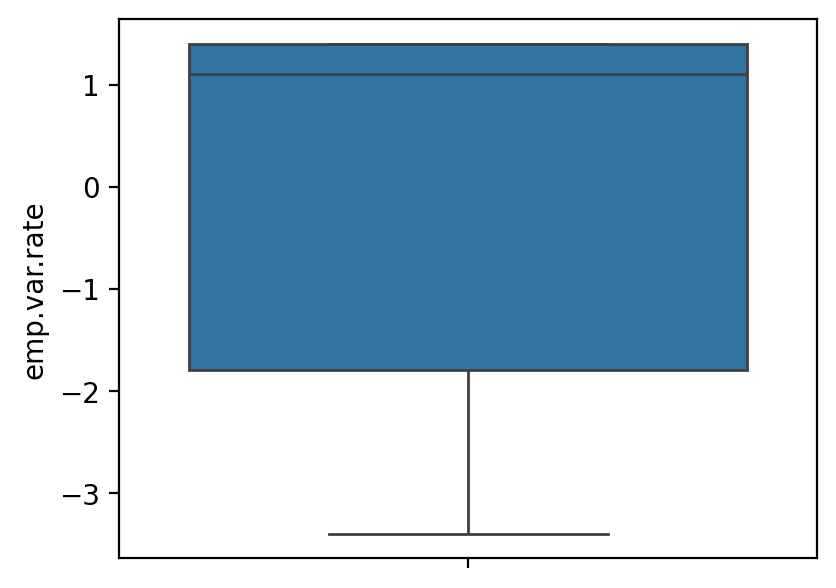

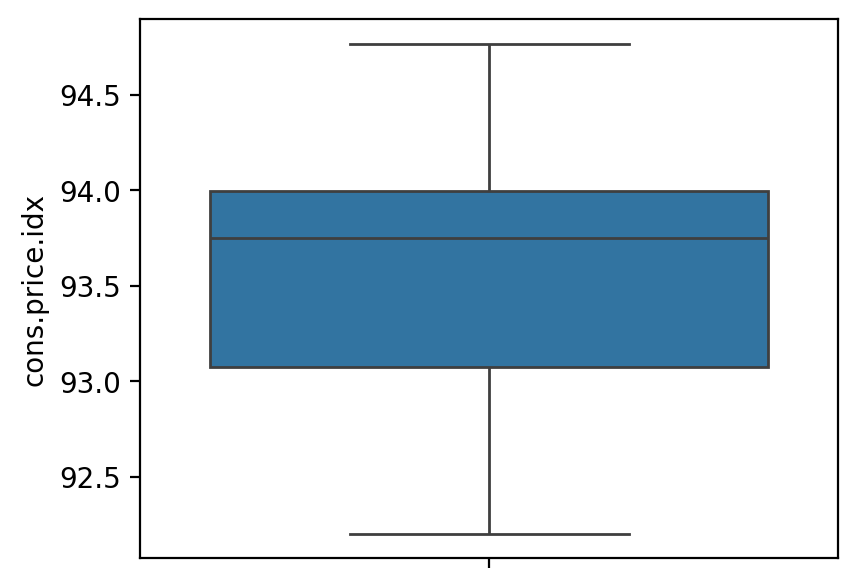

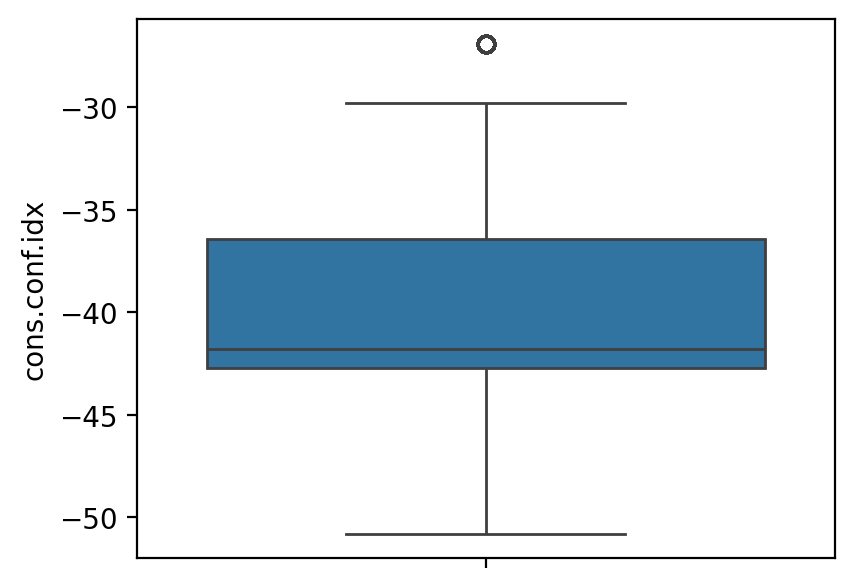

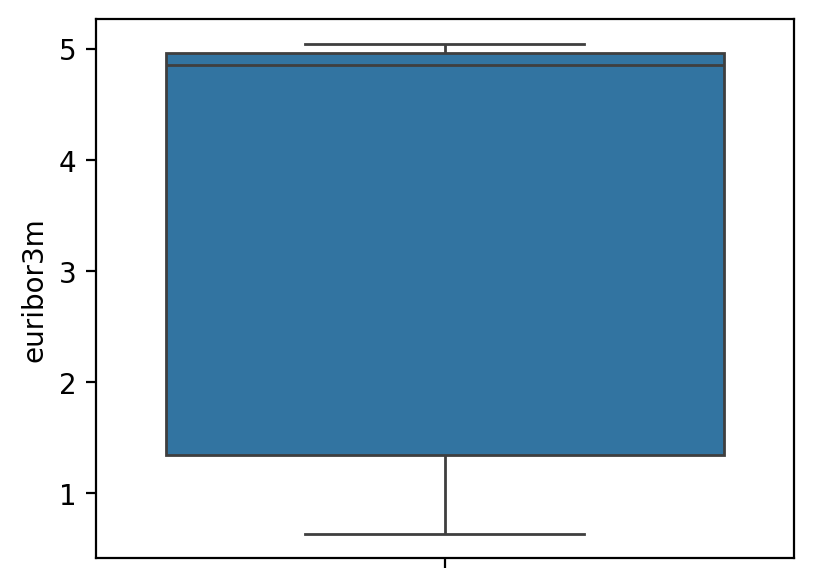

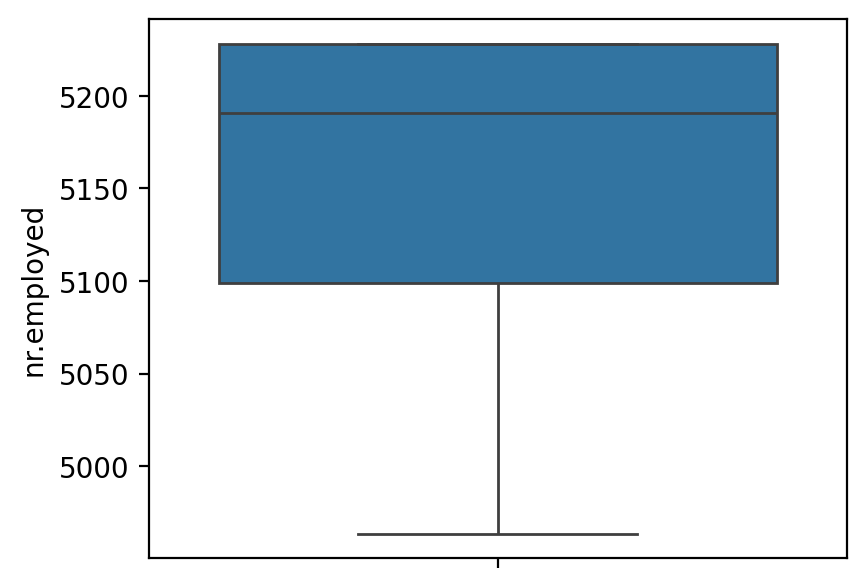

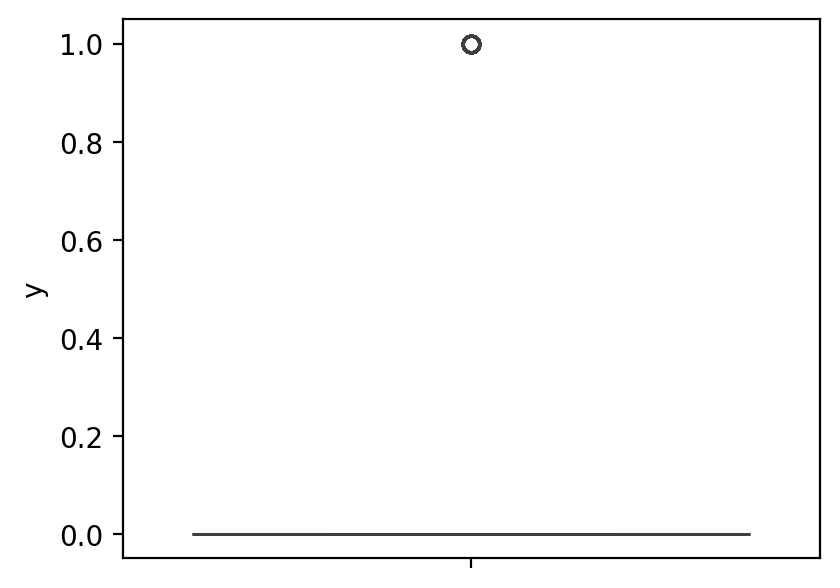

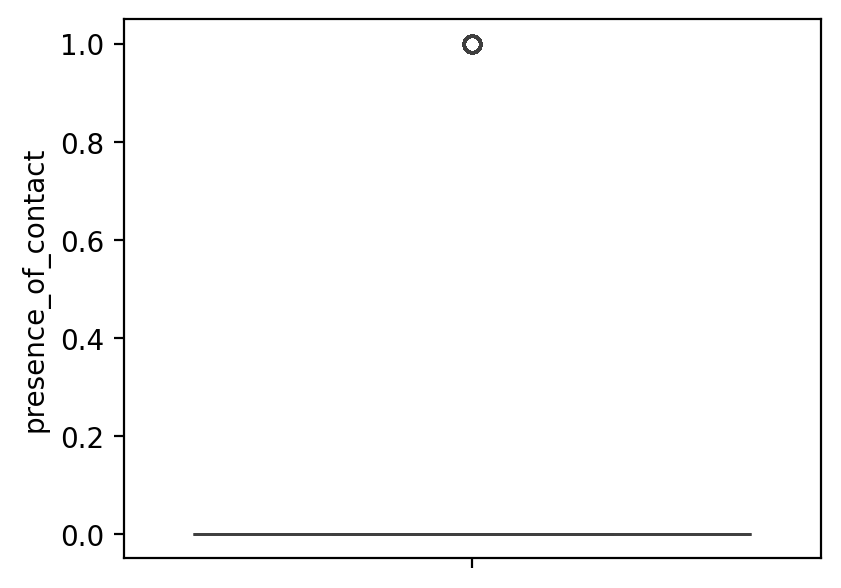

In [385]:
for col in df_num_columns.columns:
    fig = plt.figure(figsize=(4.5, 3.5), dpi=200)
    sns.boxplot(data=df_num_columns, y=col)
    plt.show()

### Результат одномерного анализа данных
- Некоторые признаки были прологорифмированы в силу улчушение в сторону нормального распределения
- Один изз признаков был закодирован
- Один из признаков был удалён

### Проведение двумерного анализа признаков
- нахождение зависимости между признаками линейную или нелиненую
- Отследлить мультиколлениарность
- Посмотреть на распределение с целевой переменной

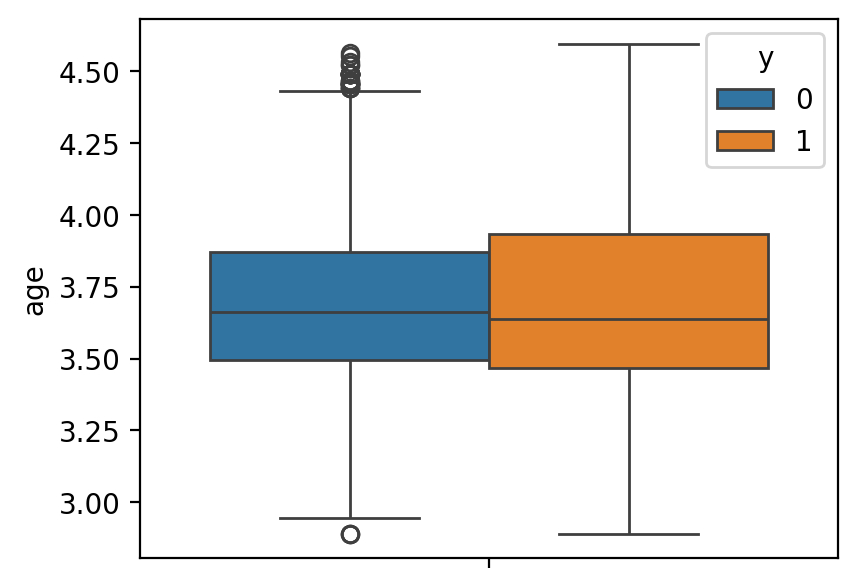

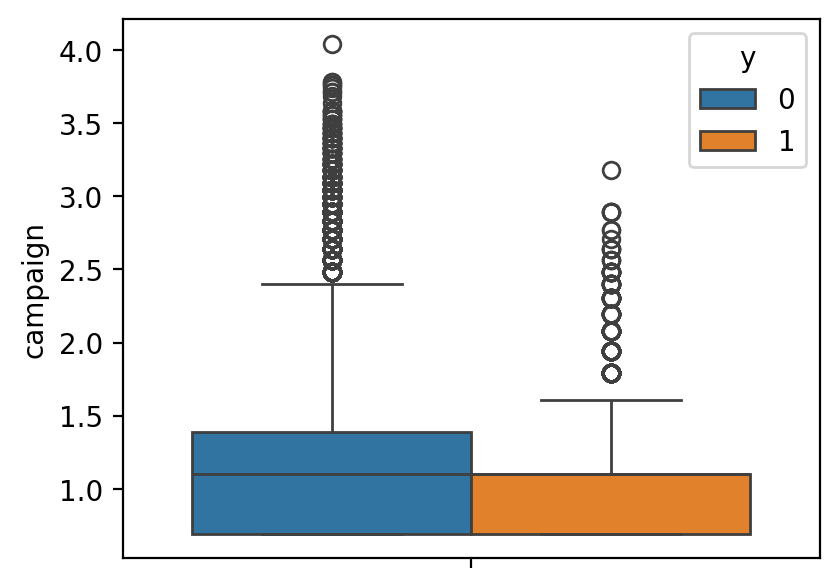

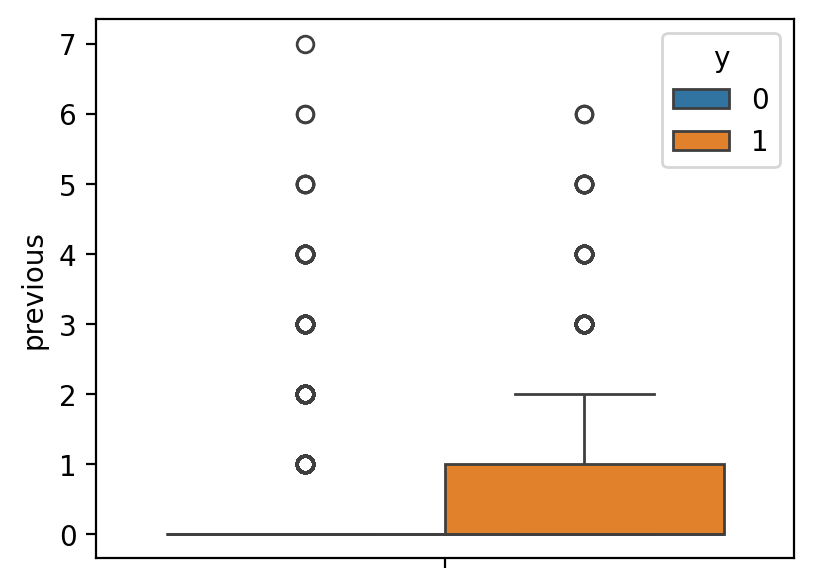

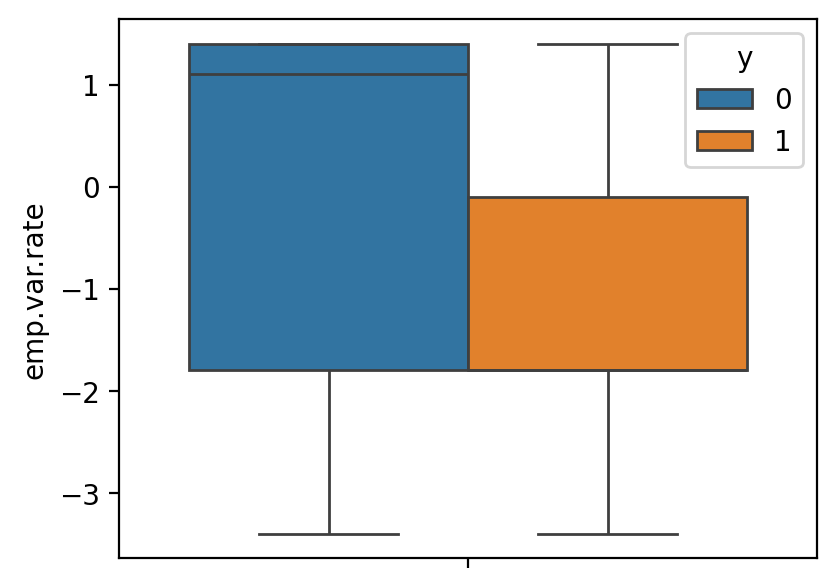

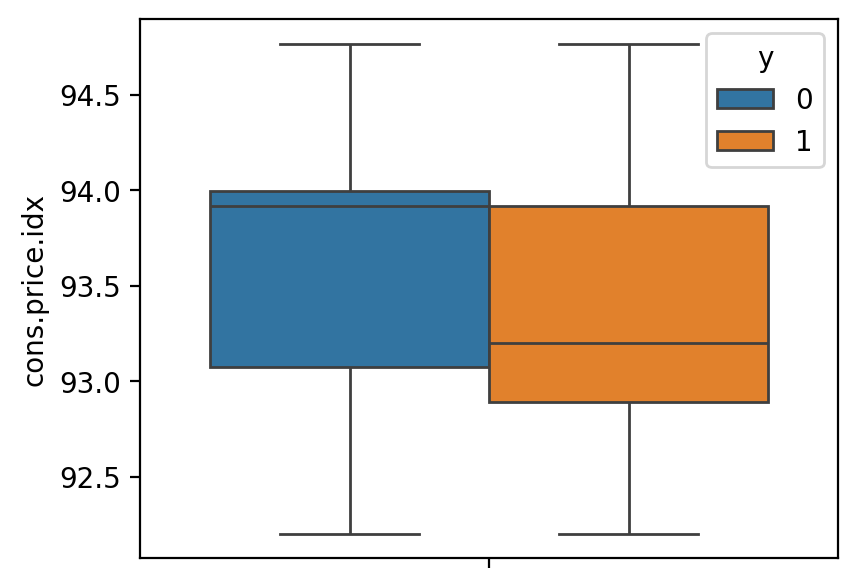

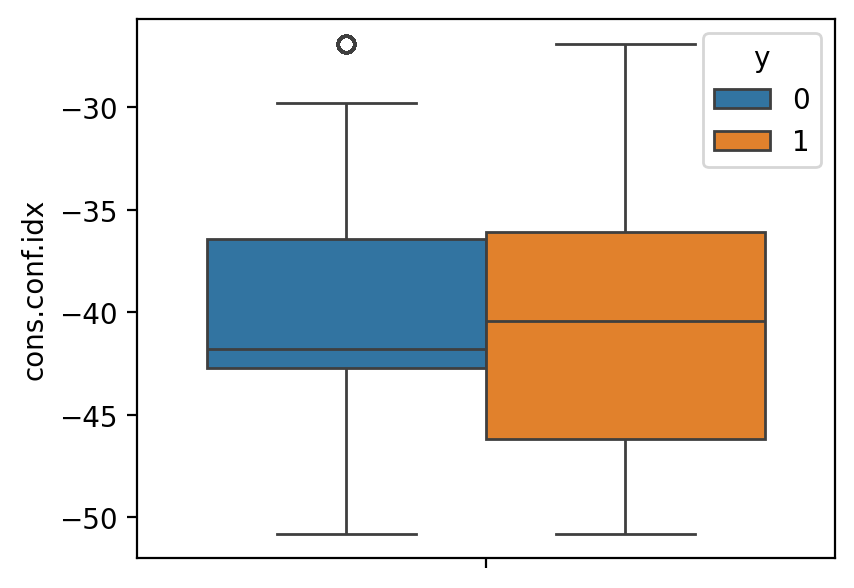

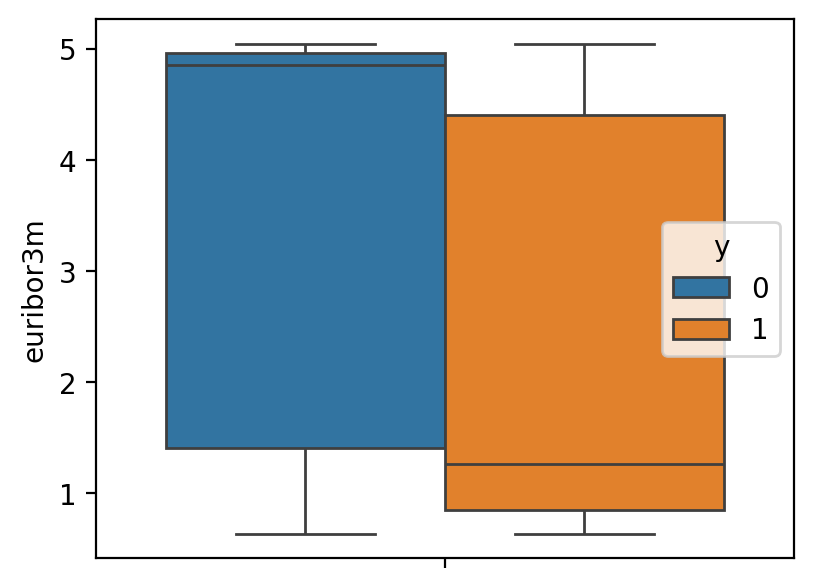

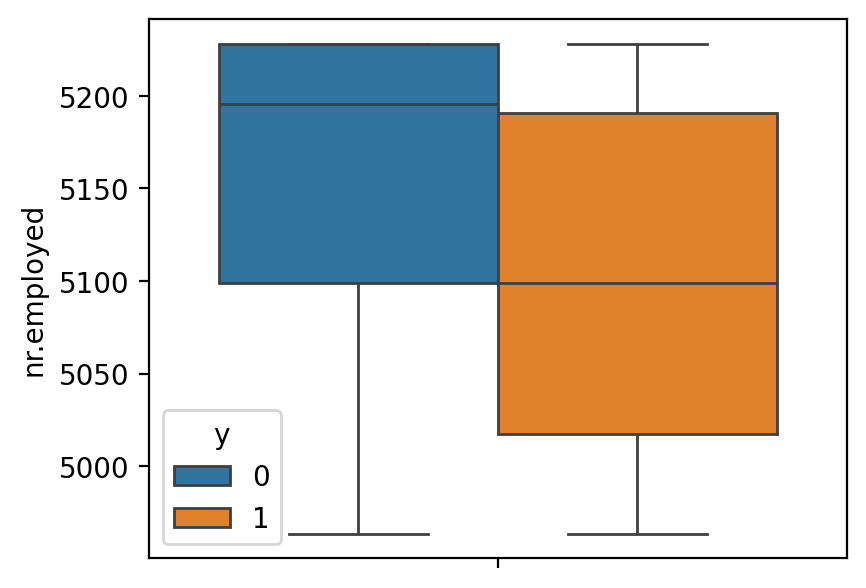

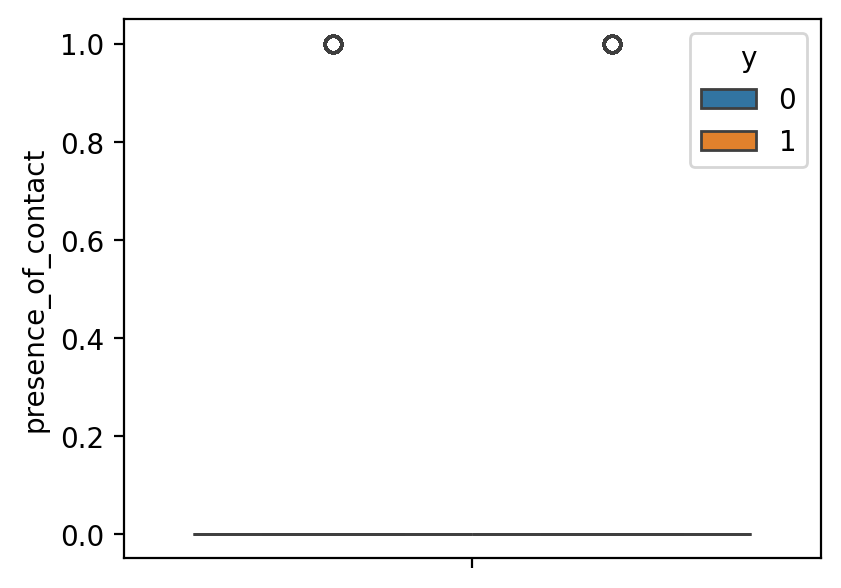

In [386]:
#Посмотрим зависимость с помощью scatterplot
for col in df_num_columns.drop("y", axis=1).columns:
    fig = plt.figure(figsize=(4.5, 3.5), dpi=200)
    sns.boxplot(data=df_num_columns, y=col, hue="y")
    plt.show()
#Видно, что распределения отличаются, на данный момент можно сделать вывод, что все приззнаки важны

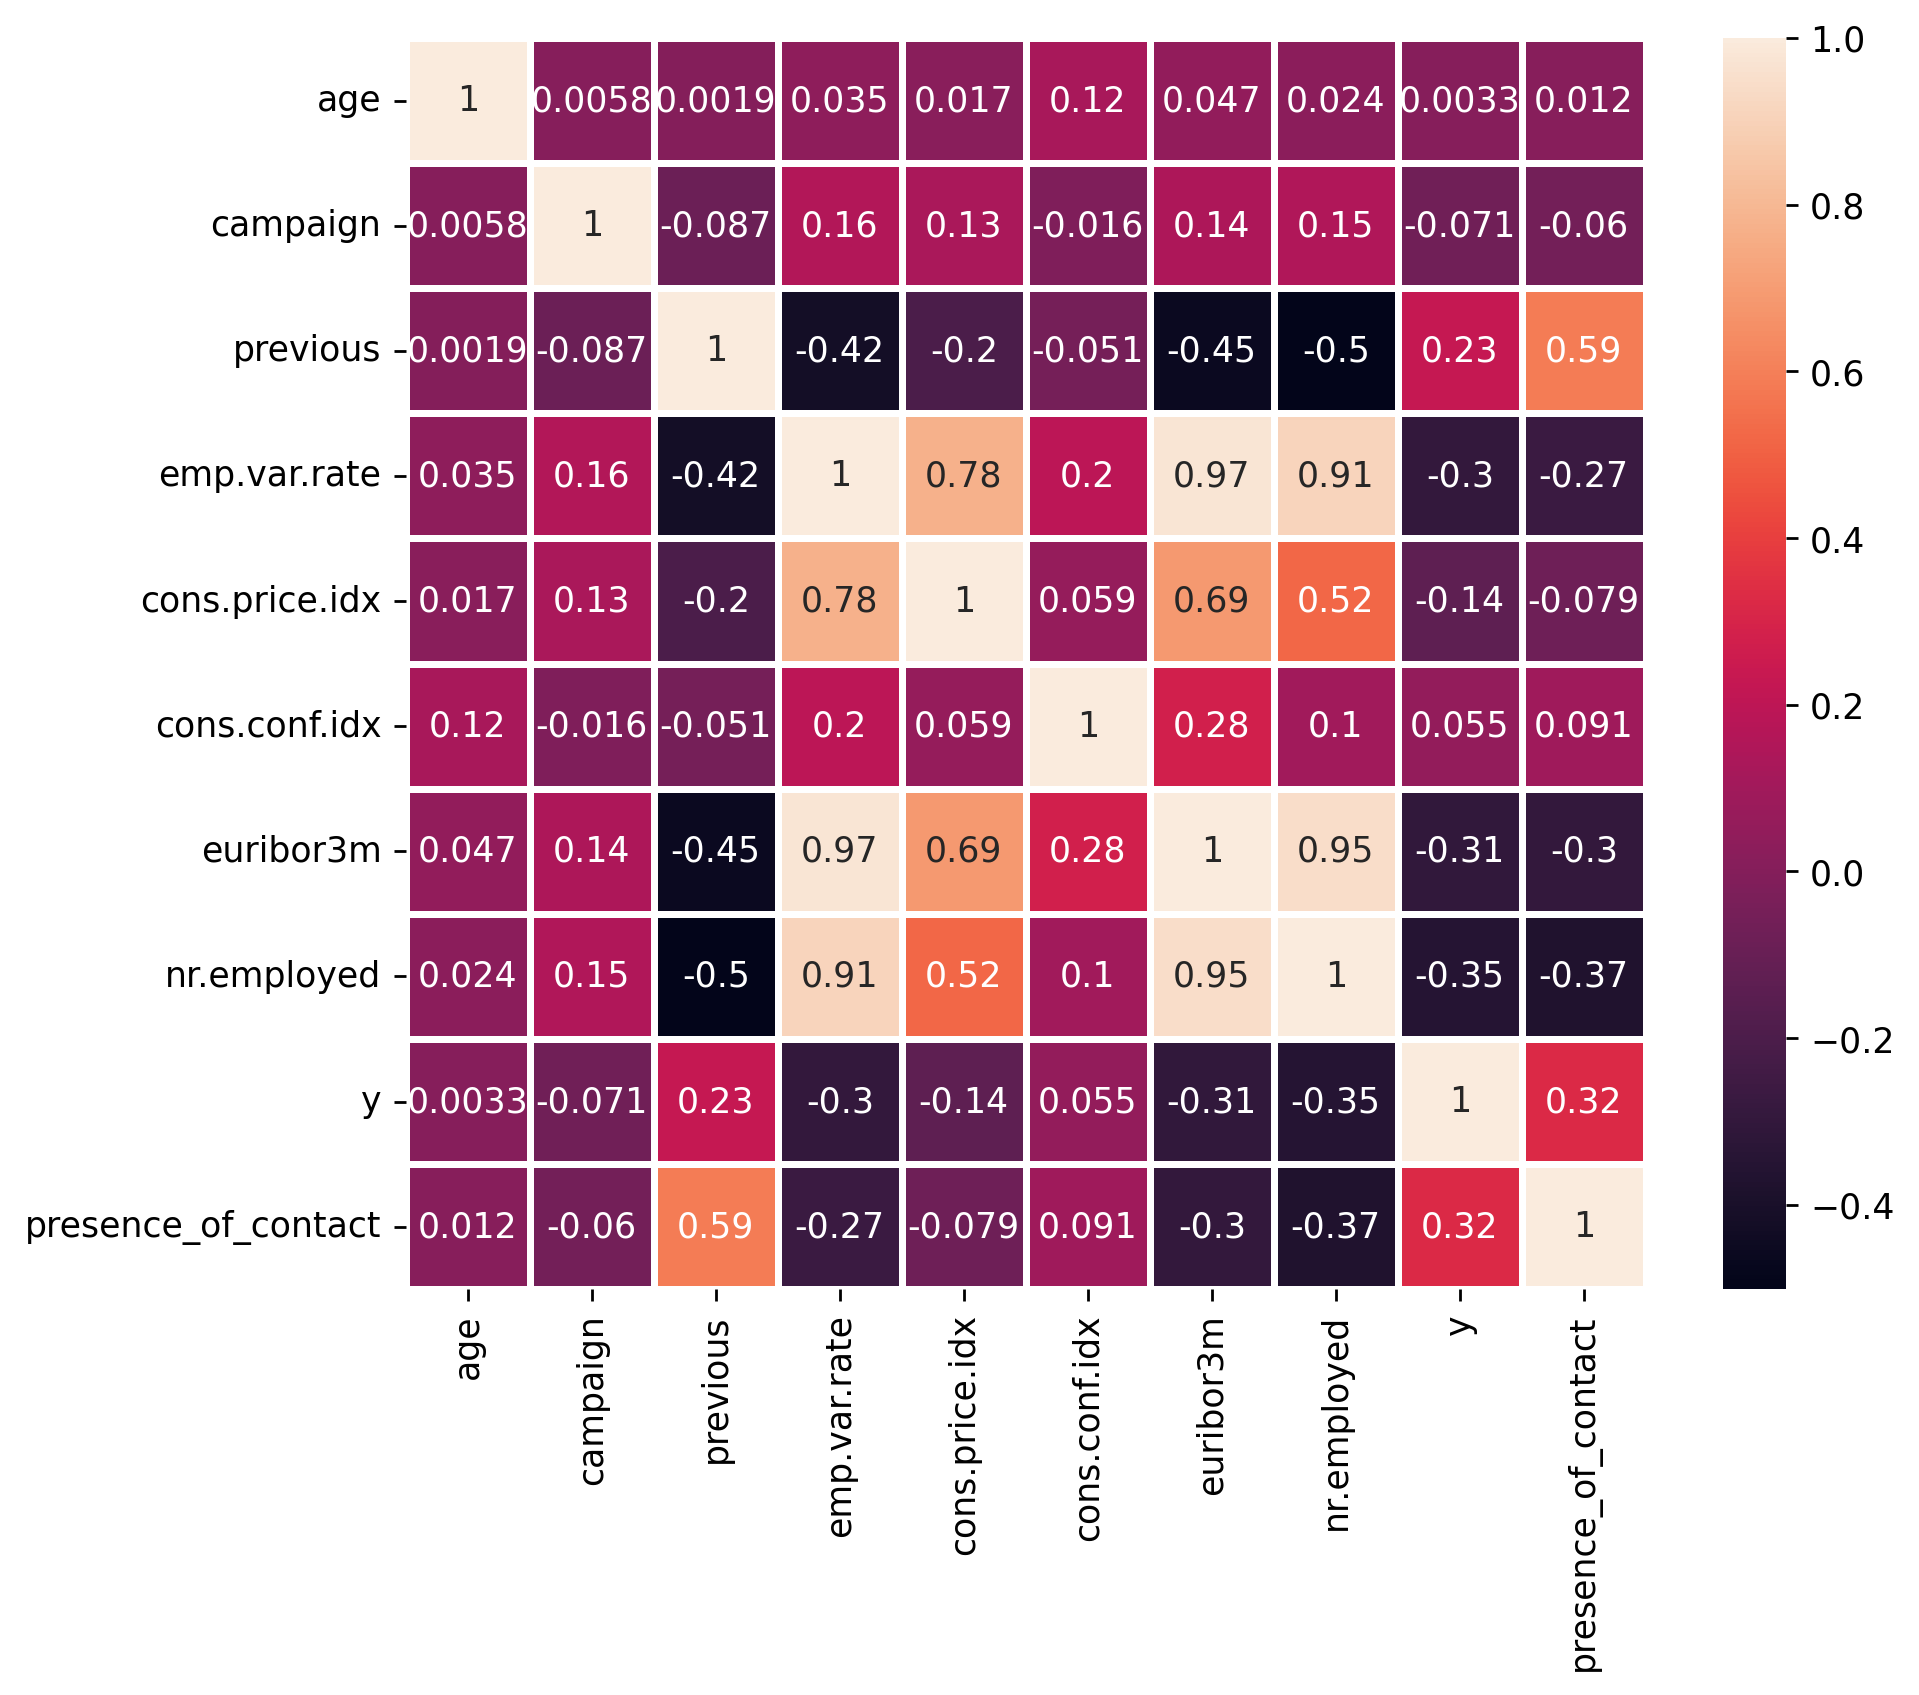

In [387]:
#Нарисуем тепловую карту
fig = plt.figure(figsize=(8, 6.5), dpi=250)
sns.heatmap(df_num_columns.corr(), annot=True, linewidths=2)
plt.show()

In [388]:
#На тепловой карте видно, что есть признаки, которые сильно коррелирую друг с другом, такие признаки стоит удалить
num_columns = df_num_columns.drop("y", axis=1).columns
dict_corr = dict()
for i in range(len(num_columns)):
    for j in range(i, len(num_columns)):
        if i != j:
            dict_corr[f"{num_columns[i]}-{num_columns[j]}"] = round(float(df_num_columns[[num_columns[i], num_columns[j]]].corr().iloc[0][1]), 3)

In [389]:
sorted_items = sorted(dict_corr.items(), key=lambda item: item[1])
sorted_items

[('previous-nr.employed', -0.501),
 ('previous-euribor3m', -0.455),
 ('previous-emp.var.rate', -0.421),
 ('nr.employed-presence_of_contact', -0.373),
 ('euribor3m-presence_of_contact', -0.297),
 ('emp.var.rate-presence_of_contact', -0.271),
 ('previous-cons.price.idx', -0.203),
 ('campaign-previous', -0.087),
 ('cons.price.idx-presence_of_contact', -0.079),
 ('campaign-presence_of_contact', -0.06),
 ('previous-cons.conf.idx', -0.051),
 ('campaign-cons.conf.idx', -0.016),
 ('age-previous', 0.002),
 ('age-campaign', 0.006),
 ('age-presence_of_contact', 0.012),
 ('age-cons.price.idx', 0.017),
 ('age-nr.employed', 0.024),
 ('age-emp.var.rate', 0.035),
 ('age-euribor3m', 0.047),
 ('cons.price.idx-cons.conf.idx', 0.059),
 ('cons.conf.idx-presence_of_contact', 0.091),
 ('cons.conf.idx-nr.employed', 0.101),
 ('age-cons.conf.idx', 0.121),
 ('campaign-cons.price.idx', 0.128),
 ('campaign-euribor3m', 0.14),
 ('campaign-nr.employed', 0.152),
 ('campaign-emp.var.rate', 0.159),
 ('emp.var.rate-cons.

### Результаты проверки мультиколлениарности
- 4 признаки сильно коррелируют друг с другом
- emp.var.rate-cons.price.idx, 0.775
- emp.var.rate-nr.employed, 0.907
- euribor3m-nr.employed, 0.945
- emp.var.rate-euribor3m, 0.972

**Критерий выброса признака** - выбросим тот признак, которую хуже распределен для целевой переменной

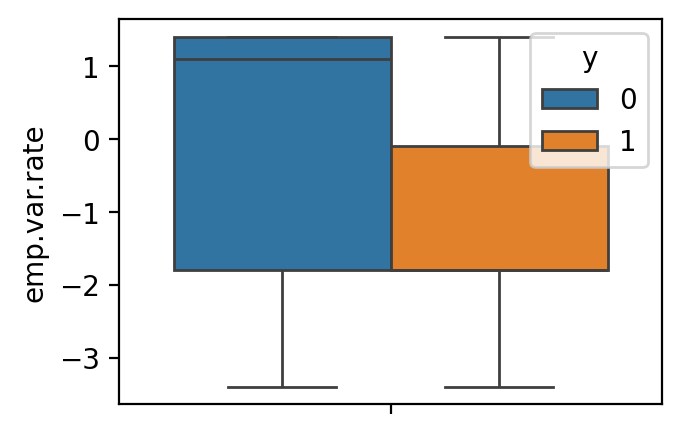

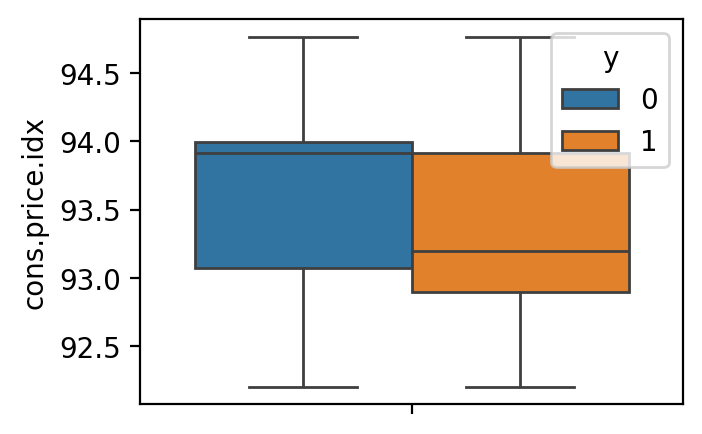

In [390]:
#Первая пара признака emp.var.rate-cons.price.idx
for col in ["emp.var.rate", "cons.price.idx"]:
    fig = plt.figure(figsize=(3.5, 2.5), dpi=200)
    sns.boxplot(data=df_num_columns, y=col, hue="y")
    plt.show()

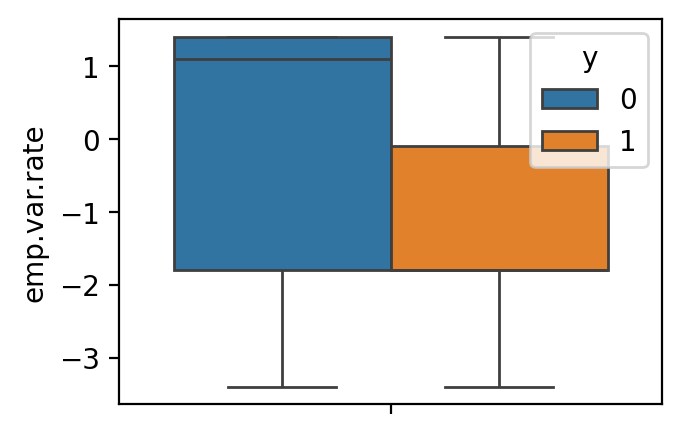

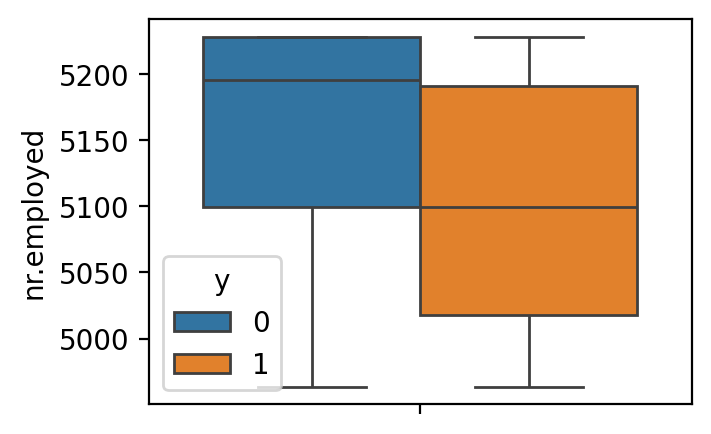

In [391]:
#Вторая пара признака mp.var.rate-nr.employed
for col in ["emp.var.rate", "nr.employed"]:
    fig = plt.figure(figsize=(3.5, 2.5), dpi=200)
    sns.boxplot(data=df_num_columns, y=col, hue="y")
    plt.show()

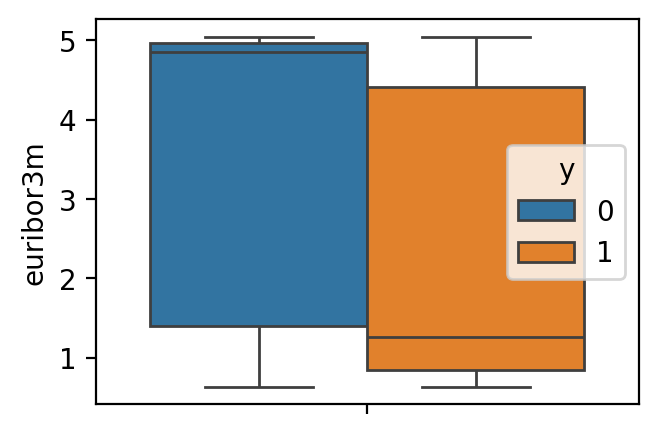

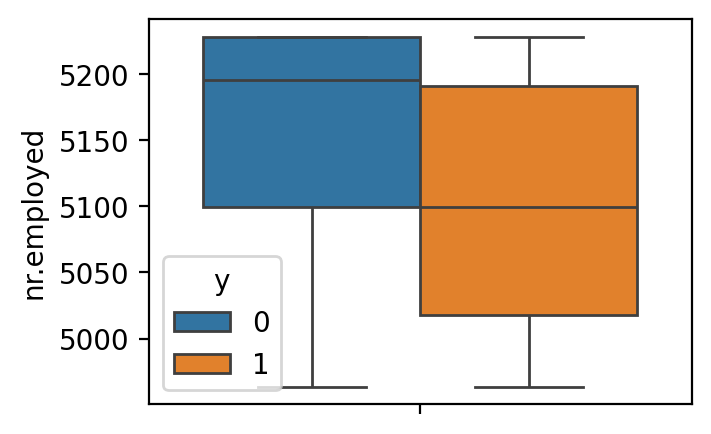

In [392]:
#Третья пара признака euribor3m-nr.employed
for col in ["euribor3m", "nr.employed"]:
    fig = plt.figure(figsize=(3.5, 2.5), dpi=200)
    sns.boxplot(data=df_num_columns, y=col, hue="y")
    plt.show()

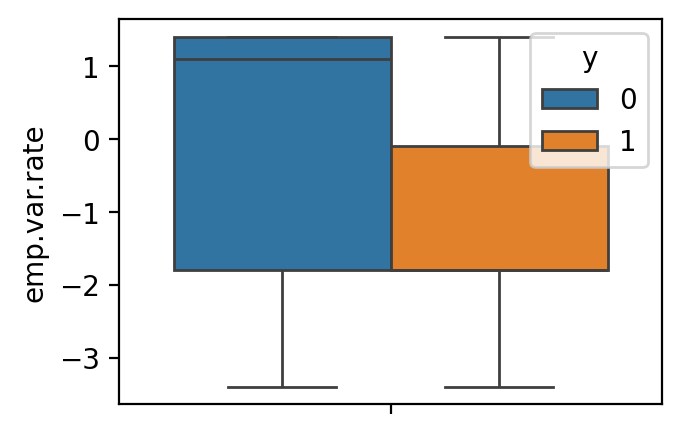

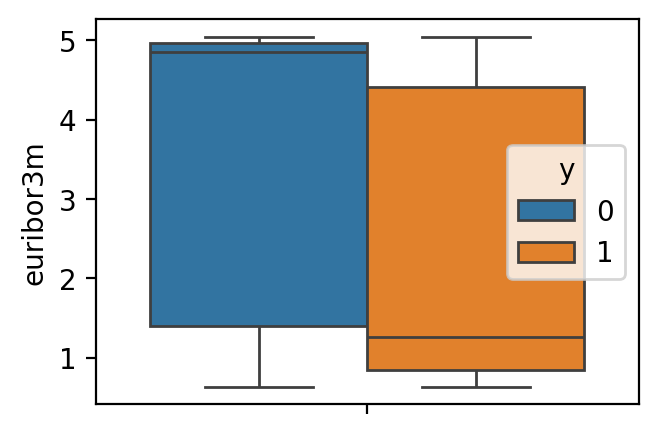

In [393]:
#Четвертая пара признака emp.var.rate-euribor3m
for col in ["emp.var.rate", "euribor3m"]:
    fig = plt.figure(figsize=(3.5, 2.5), dpi=200)
    sns.boxplot(data=df_num_columns, y=col, hue="y")
    plt.show()

### Результат
- emp.var.rate - данная колонка будет удалена, так как она коррелирует сразу с тремя колонками
- nr.employed - данная колонка также коррелирует с двумя колонками

In [394]:
df_num_columns.drop(["emp.var.rate", "nr.employed"], axis=1, inplace=True)
print("Колонки emp.var.rate и nr.employed удалены!")

Колонки emp.var.rate и nr.employed удалены!


In [395]:
num_columns = df_num_columns.drop("y", axis=1).columns
dict_corr = dict()
for i in range(len(num_columns)):
    for j in range(i, len(num_columns)):
        if i != j:
            dict_corr[f"{num_columns[i]}-{num_columns[j]}"] = round(float(df_num_columns[[num_columns[i], num_columns[j]]].corr().iloc[0][1]), 3)

In [396]:
#Коррилируующие колонки удалены
sorted_items = sorted(dict_corr.items(), key=lambda item: item[1])
sorted_items

[('previous-euribor3m', -0.455),
 ('euribor3m-presence_of_contact', -0.297),
 ('previous-cons.price.idx', -0.203),
 ('campaign-previous', -0.087),
 ('cons.price.idx-presence_of_contact', -0.079),
 ('campaign-presence_of_contact', -0.06),
 ('previous-cons.conf.idx', -0.051),
 ('campaign-cons.conf.idx', -0.016),
 ('age-previous', 0.002),
 ('age-campaign', 0.006),
 ('age-presence_of_contact', 0.012),
 ('age-cons.price.idx', 0.017),
 ('age-euribor3m', 0.047),
 ('cons.price.idx-cons.conf.idx', 0.059),
 ('cons.conf.idx-presence_of_contact', 0.091),
 ('age-cons.conf.idx', 0.121),
 ('campaign-cons.price.idx', 0.128),
 ('campaign-euribor3m', 0.14),
 ('cons.conf.idx-euribor3m', 0.278),
 ('previous-presence_of_contact', 0.587),
 ('cons.price.idx-euribor3m', 0.688)]

### Проведение 3-х экспериментов
- Добавление признаков с помощью PolynomialFeatures
- Добавление признаков исключительно с помощью генерации степеней(без коомбинаций признаков)
- Добавление только степеней вещественных признаков

In [397]:
#Импортирование необходимых библиотек
#1 Формирование признаков с помощью PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

X, y = df_num_columns.drop("y", axis=1), df_num_columns["y"]
cv = KFold(n_splits=10, shuffle=True, random_state=42)
train_score_list_1, test_score_list_1, val_average_score_1 = [], [], []
for degree in range(1, 6):
    transformer = PolynomialFeatures(degree=degree, include_bias=False)
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)
    X_train_poly = transformer.fit_transform(X_train)
    X_test_poly = transformer.transform(X_test)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_poly)
    X_test_scaled = scaler.transform(X_test_poly)
    print(f"Количетсво признаков: {X_train_scaled.shape[1]}")

    model = LogisticRegression()
    model.fit(X_train_scaled, y_train)
    train_score_list_1.append(accuracy_score(y_train, model.predict(X_train_scaled)))
    test_score_list_1.append(accuracy_score(y_test, model.predict(X_test_scaled)))

    pipe = Pipeline([("poly", PolynomialFeatures(degree=degree, include_bias=False)),
                    ("scaler", StandardScaler()),
                    ("model", LogisticRegression())])
    
    

    val_score = cross_val_score(estimator=pipe, X=X, y=y, scoring="accuracy", cv=cv, n_jobs=-1)
    val_average_score_1.append(float(np.mean(val_score)))

Количетсво признаков: 7
Количетсво признаков: 35
Количетсво признаков: 119
Количетсво признаков: 329
Количетсво признаков: 791


train errors: [0.9003302894890227, 0.899747425684865, 0.9001683828767567, 0.9001036202318503, 0.8997150443624118]
test errors: [0.8965416747619973, 0.8955702350884011, 0.8955702350884011, 0.8955702350884011, 0.8949873712842432]
val average errors: [0.8992617586871056, 0.8986546088825129, 0.8985817166953544, 0.8985088834920019, 0.8985817697807796]


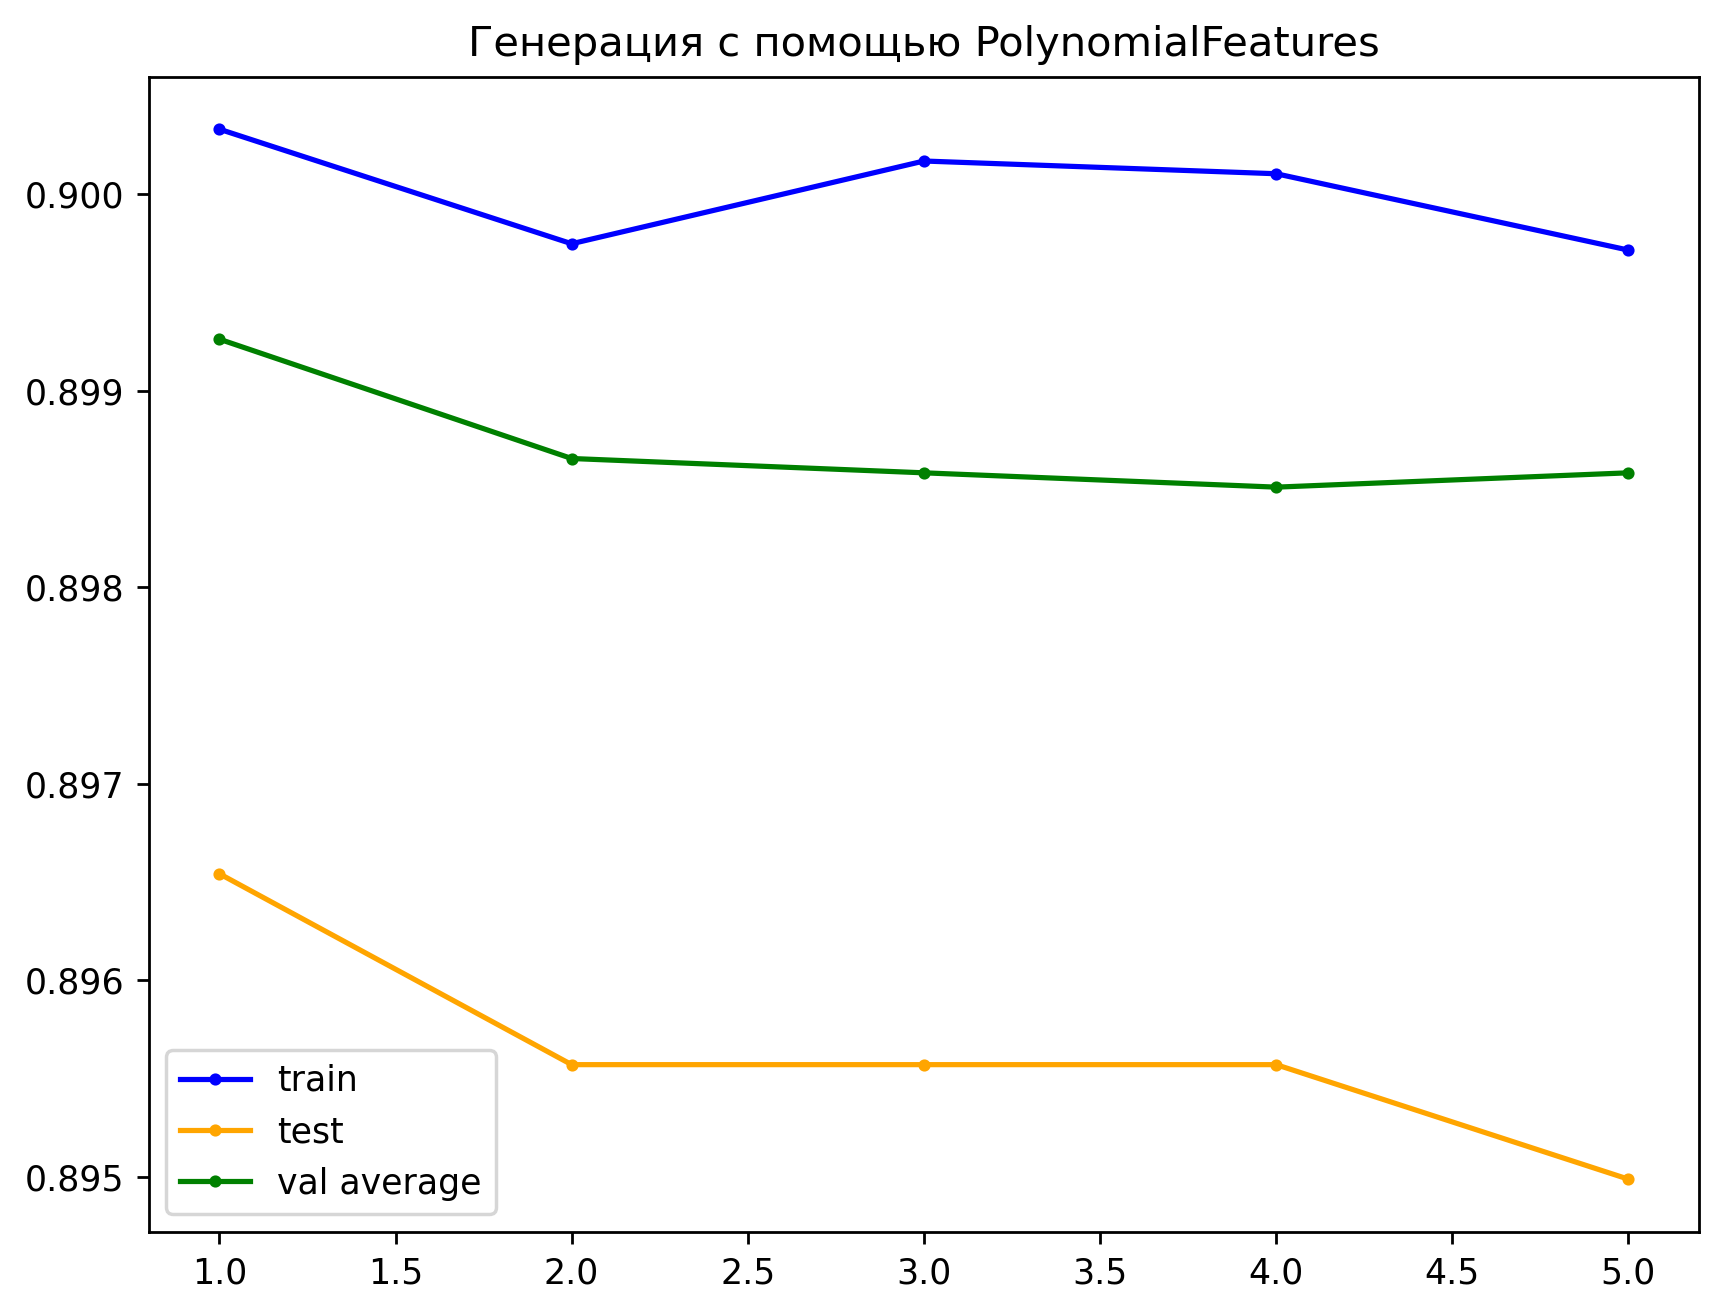

In [398]:
print(f"train errors: {train_score_list_1}", f"test errors: {test_score_list_1}",  f"val average errors: {val_average_score_1}", sep="\n")

fig = plt.figure(figsize=(8, 6), dpi=250)
plt.title("Генерация с помощью PolynomialFeatures")
plt.plot(list(range(1, 6)), train_score_list_1, ms=5, color="blue", label="train", marker=".")
plt.plot(list(range(1, 6)), test_score_list_1, ms=5, color="orange", label="test", marker=".")
plt.plot(list(range(1, 6)), val_average_score_1, ms=5, color="green", label="val average", marker=".")
plt.legend()
plt.show()

In [399]:
#2 Добавление только степеней колонок, без коомбинаций между ними

X, y = df_num_columns.drop("y", axis=1), df_num_columns["y"]
cv = KFold(n_splits=10, shuffle=True, random_state=42)
train_score_list_2, test_score_list_2, val_average_score_2 = [], [], []
X_copy = X.copy()
for degree in range(1, 6):
    if degree != 1:
        for col in df_num_columns.drop("y", axis=1).columns:
            X_copy[f"{col}_{degree}"] = X[col]**degree
    X_train, X_test, y_train, y_test = train_test_split(X_copy, y, shuffle=True, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print(f"Количетсво признаков: {X_train_scaled.shape[1]}")

    model = LogisticRegression()
    model.fit(X_train_scaled, y_train)
    train_score_list_2.append(accuracy_score(y_train, model.predict(X_train_scaled)))
    test_score_list_2.append(accuracy_score(y_test, model.predict(X_test_scaled)))
    
    val_score_list = []
    for train_index, test_index in cv.split(X_copy):
        X_train_val, X_test_val = X_copy.iloc[train_index], X_copy.iloc[test_index]
        y_train_val, y_test_val = y.iloc[train_index], y.iloc[test_index]
        scaler_val = StandardScaler()
        X_train_val_scaled = scaler_val.fit_transform(X_train_val)
        X_test_val_scaled = scaler_val.transform(X_test_val)
        model_val = LogisticRegression()
        model_val.fit(X_train_val_scaled, y_train_val)
        val_score_list.append(accuracy_score(y_test_val, model_val.predict(X_test_val_scaled)))

    val_average_score_2.append(float(np.mean(val_score_list)))

Количетсво признаков: 7
Количетсво признаков: 14
Количетсво признаков: 21
Количетсво признаков: 28
Количетсво признаков: 35


train errors: [0.9003302894890227, 0.9000712389093971, 0.8999417136195842, 0.8999740949420374, 0.899747425684865]
test errors: [0.8965416747619973, 0.8964445307946377, 0.8954730911210413, 0.8952788031863221, 0.8953759471536817]
val average errors: [0.8992617586871056, 0.8988488425548813, 0.898630278062637, 0.8986303016561592, 0.8985574507576647]


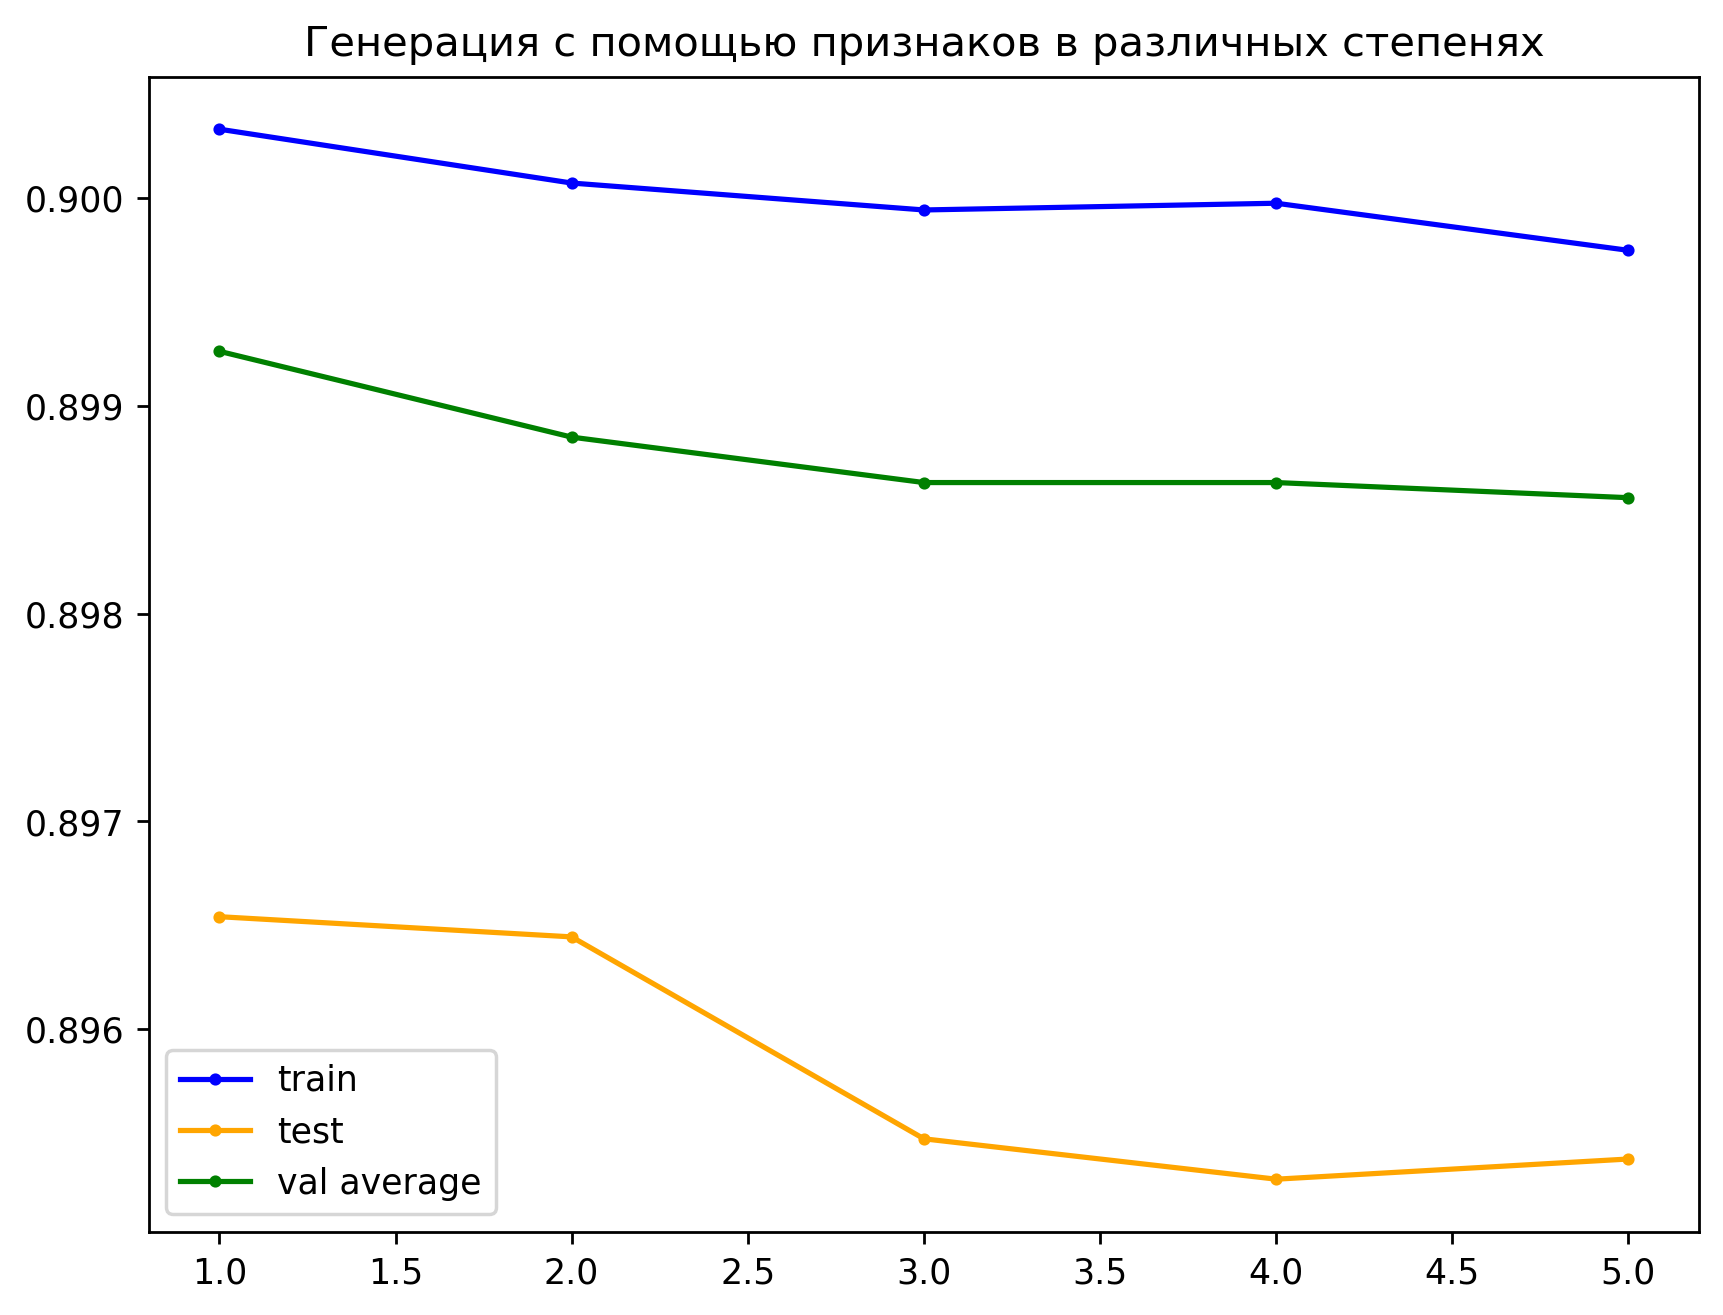

In [400]:
print(f"train errors: {train_score_list_2}", f"test errors: {test_score_list_2}",  f"val average errors: {val_average_score_2}", sep="\n")

fig = plt.figure(figsize=(8, 6), dpi=250)
plt.title("Генерация с помощью признаков в различных степенях")
plt.plot(list(range(1, 6)), train_score_list_2, ms=5, color="blue", label="train", marker=".")
plt.plot(list(range(1, 6)), test_score_list_2, ms=5, color="orange", label="test", marker=".")
plt.plot(list(range(1, 6)), val_average_score_2, ms=5, color="green", label="val average", marker=".")
plt.legend()
plt.show()

In [401]:
#Импортирование необходимых библиотек
#3 Добавление только вещественных степеней колонок, без коомбинаций между ними

X, y = df_num_columns.drop("y", axis=1), df_num_columns["y"]
cv = KFold(n_splits=10, shuffle=True, random_state=42)
train_score_list_3, test_score_list_3, val_average_score_3 = [], [], []
X_copy = X.copy()
for degree in range(1, 6):
    if degree != 1:
        for col in ["age", "campaign", "cons.price.idx", "cons.conf.idx", "euribor3m"]:
            X_copy[f"{col}_{degree}"] = X[col]**degree
    X_train, X_test, y_train, y_test = train_test_split(X_copy, y, shuffle=True, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print(f"Количетсво признаков: {X_train_scaled.shape[1]}")

    model = LogisticRegression()
    model.fit(X_train_scaled, y_train)
    train_score_list_3.append(accuracy_score(y_train, model.predict(X_train_scaled)))
    test_score_list_3.append(accuracy_score(y_test, model.predict(X_test_scaled)))
    
    val_score_list = []
    for train_index, test_index in cv.split(X_copy):
        X_train_val, X_test_val = X_copy.iloc[train_index], X_copy.iloc[test_index]
        y_train_val, y_test_val = y.iloc[train_index], y.iloc[test_index]
        scaler_val = StandardScaler()
        X_train_val_scaled = scaler_val.fit_transform(X_train_val)
        X_test_val_scaled = scaler_val.transform(X_test_val)
        model_val = LogisticRegression()
        model_val.fit(X_train_val_scaled, y_train_val)
        val_score_list.append(accuracy_score(y_test_val, model_val.predict(X_test_val_scaled)))

    val_average_score_3.append(float(np.mean(val_score_list)))

Количетсво признаков: 7
Количетсво признаков: 12
Количетсво признаков: 17
Количетсво признаков: 22
Количетсво признаков: 27


train errors: [0.9003302894890227, 0.899747425684865, 0.8996826630399586, 0.8995531377501457, 0.8997798070073182]
test errors: [0.8965416747619973, 0.8965416747619973, 0.8962502428599184, 0.8958616669904799, 0.8960559549251992]
val average errors: [0.8992617586871056, 0.8988974098205441, 0.8987274066955819, 0.8985331199377885, 0.8987517080235554]


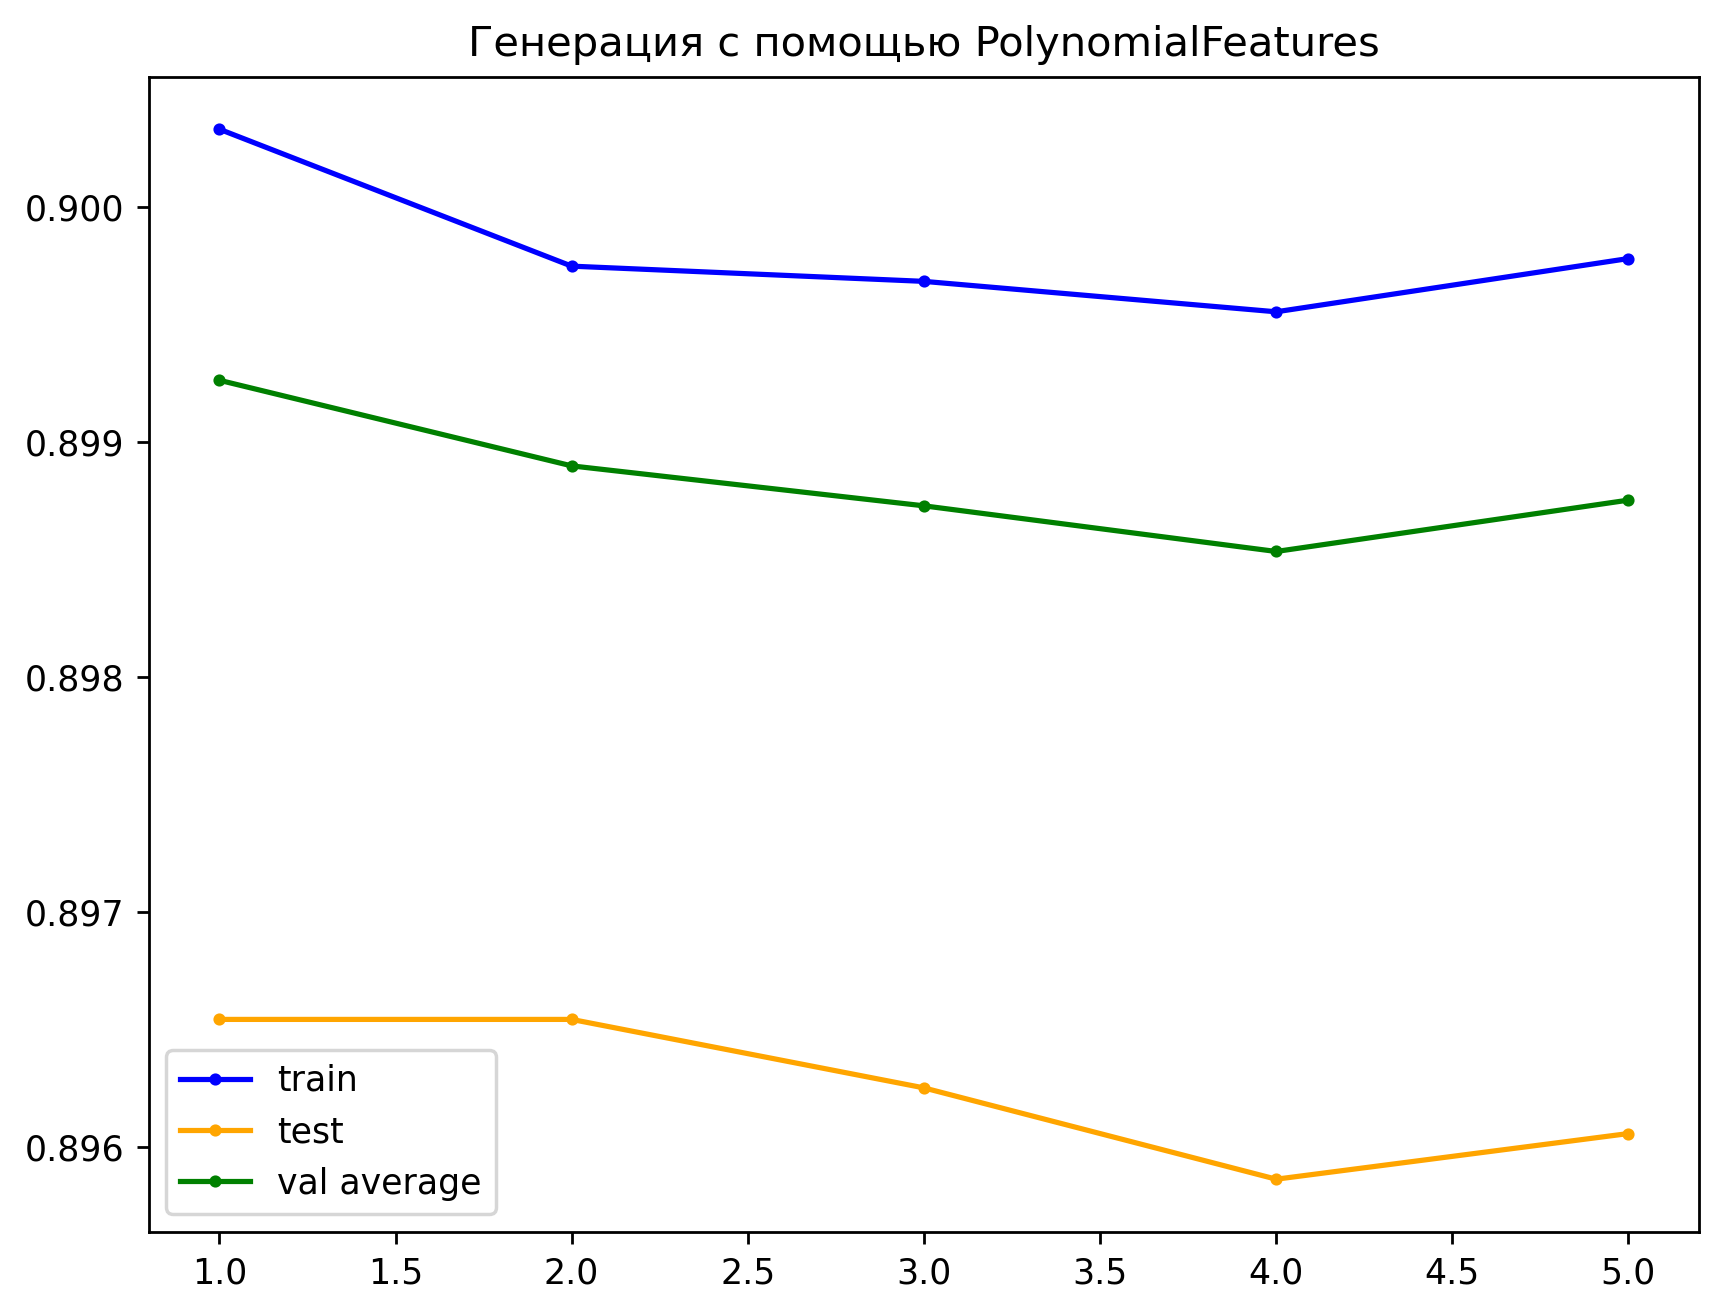

In [402]:
print(f"train errors: {train_score_list_3}", f"test errors: {test_score_list_3}",  f"val average errors: {val_average_score_3}", sep="\n")

fig = plt.figure(figsize=(8, 6), dpi=250)
plt.title("Генерация с помощью PolynomialFeatures")
plt.plot(list(range(1, 6)), train_score_list_3, ms=5, color="blue", label="train", marker=".")
plt.plot(list(range(1, 6)), test_score_list_3, ms=5, color="orange", label="test", marker=".")
plt.plot(list(range(1, 6)), val_average_score_3, ms=5, color="green", label="val average", marker=".")
plt.legend()
plt.show()

### Результат
Эксперимент показал, что добавление полиномильных признаков только портит модель

По крайней мере для accuracy

### Обработка категориальных признаков

In [403]:
#Соединим категориальные колонки с целевой переменной, чтобы было проще работать
df_cat_columns = pd.concat([df_cat_columns, target], axis=1)

In [404]:
#Посмотрим на основные статистики
df_cat_columns.describe(include=object)
#Явно пропусков не видно, хотя они есть

job  marital          education default housing   loan   contact  \
count    41176    41176              41176   41176   41176  41176     41176   
unique      12        4                  8       3       3      3         2   
top     admin.  married  university.degree      no     yes     no  cellular   
freq     10419    24921              12164   32577   21571  33938     26135   

        month day_of_week     poutcome  
count   41176       41176        41176  
unique     10           5            3  
top       may         thu  nonexistent  
freq    13767        8618        35551

### Посмотрим на распределение категорильных признаков

In [405]:
def draw_countplot(col, df):
    print(df[col].value_counts(normalize=True))
    fig = plt.figure(figsize=(5, 4), dpi=250)
    plt.title(f"Распределение категорий признака {col}")
    plt.ylabel("Количество")
    sns.countplot(data=df, x=col, palette="hls")
    plt.xticks(rotation=45)
    plt.show()

job
admin.           0.253036
blue-collar      0.224718
technician       0.163663
services         0.096343
management       0.071012
retired          0.041723
entrepreneur     0.035360
self-employed    0.034510
housemaid        0.025743
unemployed       0.024626
student          0.021250
unknown          0.008014
Name: proportion, dtype: float64


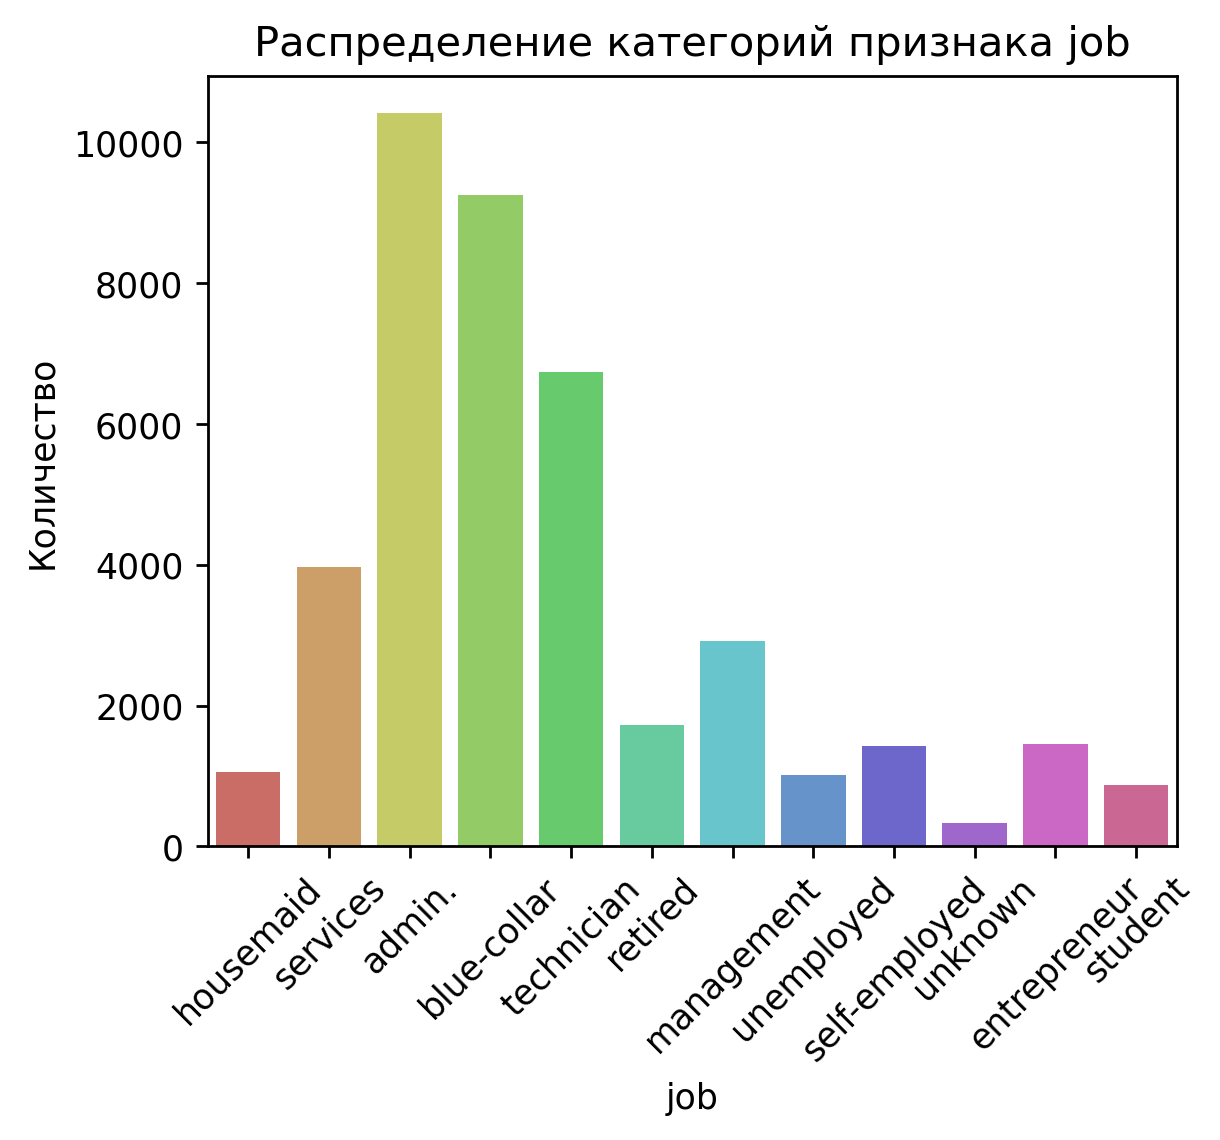

marital
married     0.605231
single      0.280843
divorced    0.111983
unknown     0.001943
Name: proportion, dtype: float64


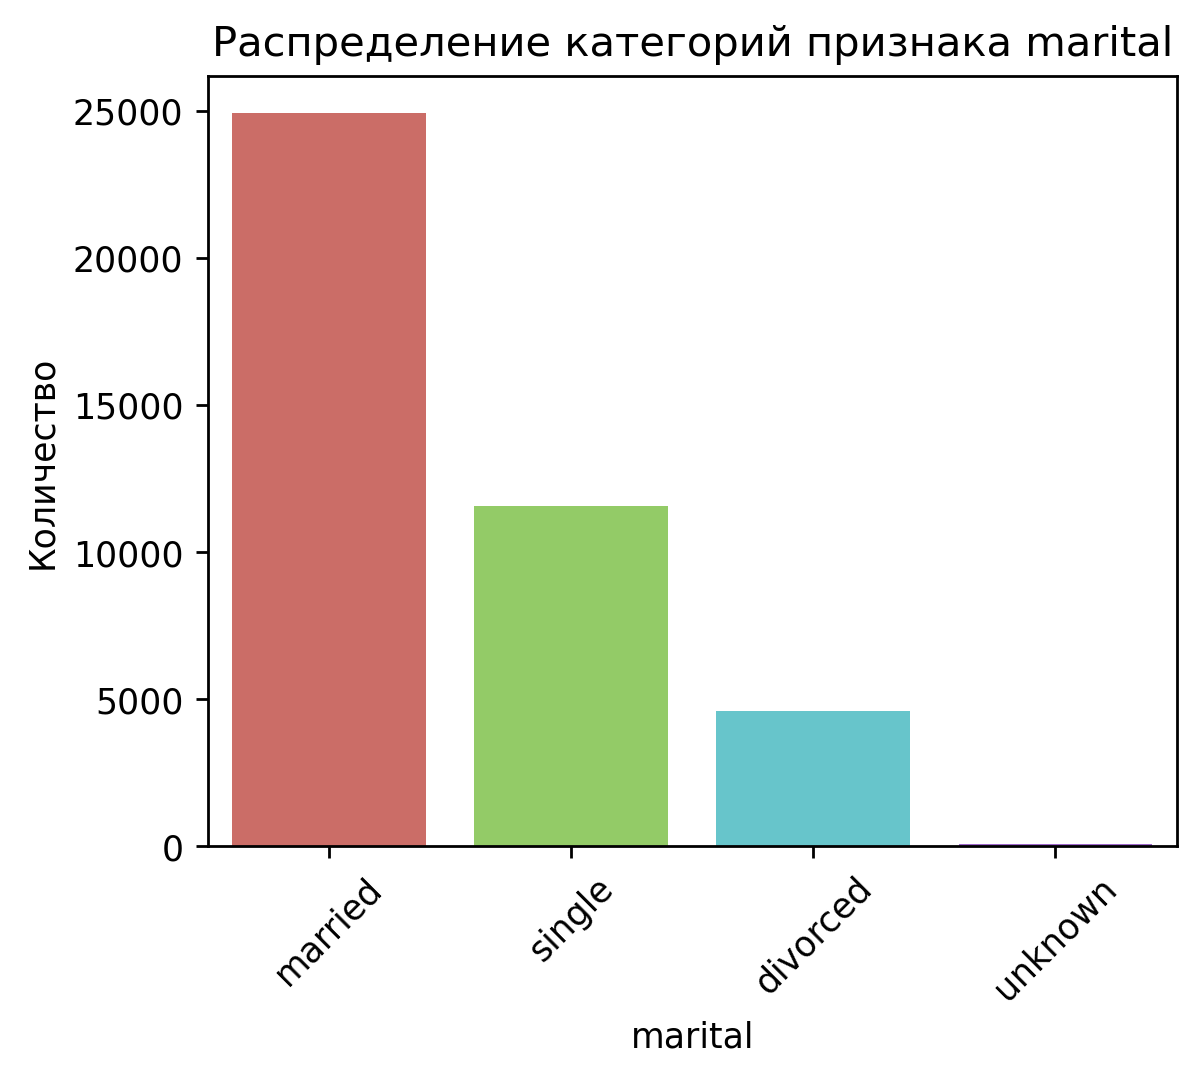

education
university.degree      0.295415
high.school            0.231008
basic.9y               0.146809
professional.course    0.127259
basic.4y               0.101418
basic.6y               0.055639
unknown                0.042015
illiterate             0.000437
Name: proportion, dtype: float64


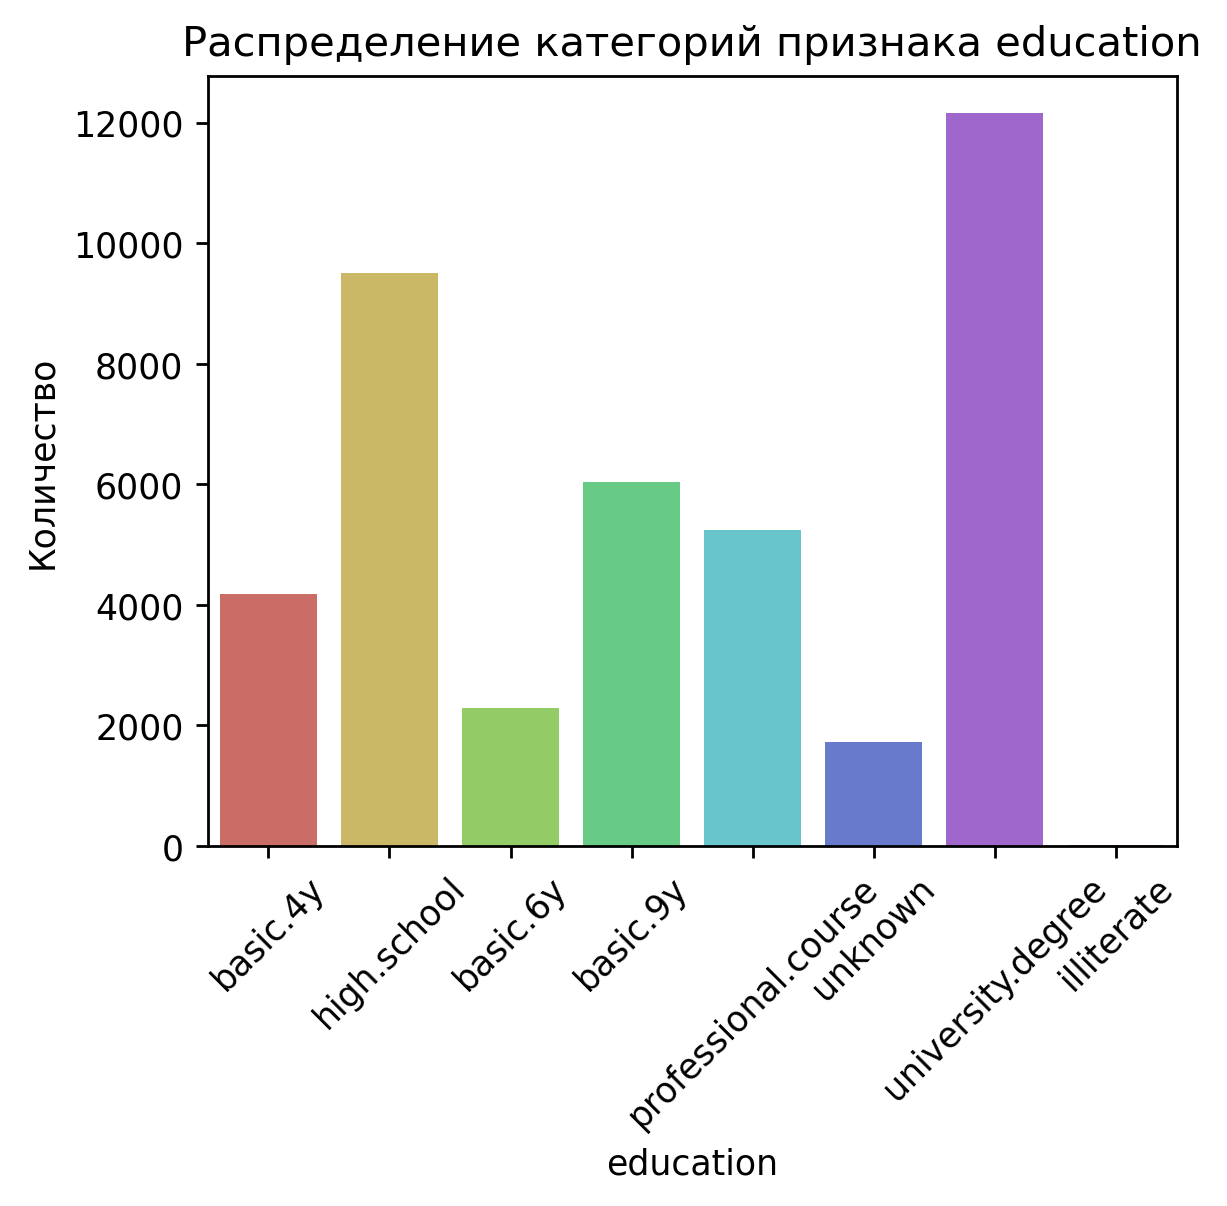

default
no         0.791165
unknown    0.208762
yes        0.000073
Name: proportion, dtype: float64


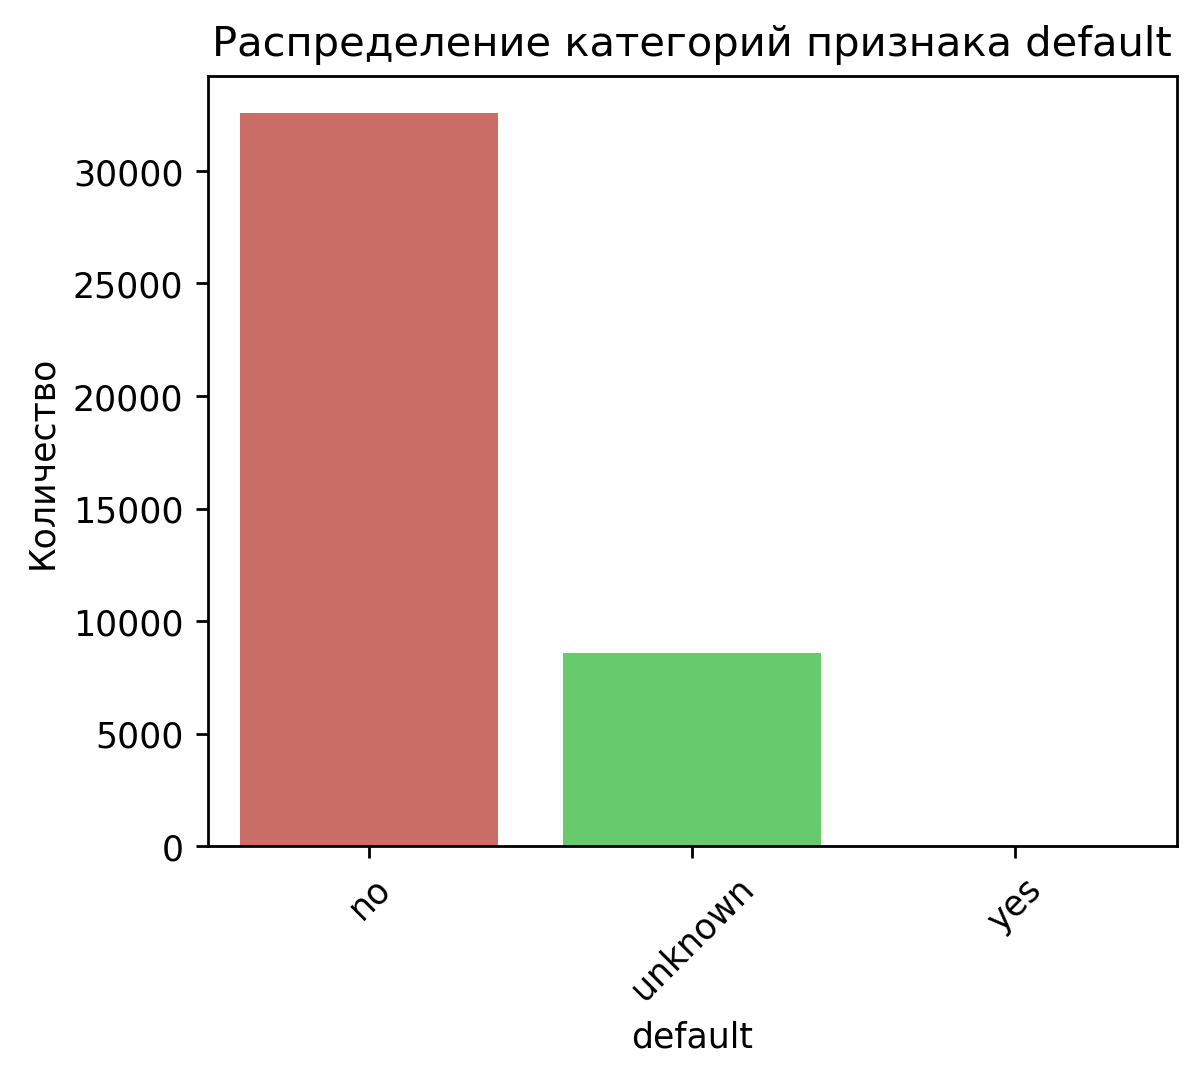

housing
yes        0.523873
no         0.452084
unknown    0.024043
Name: proportion, dtype: float64


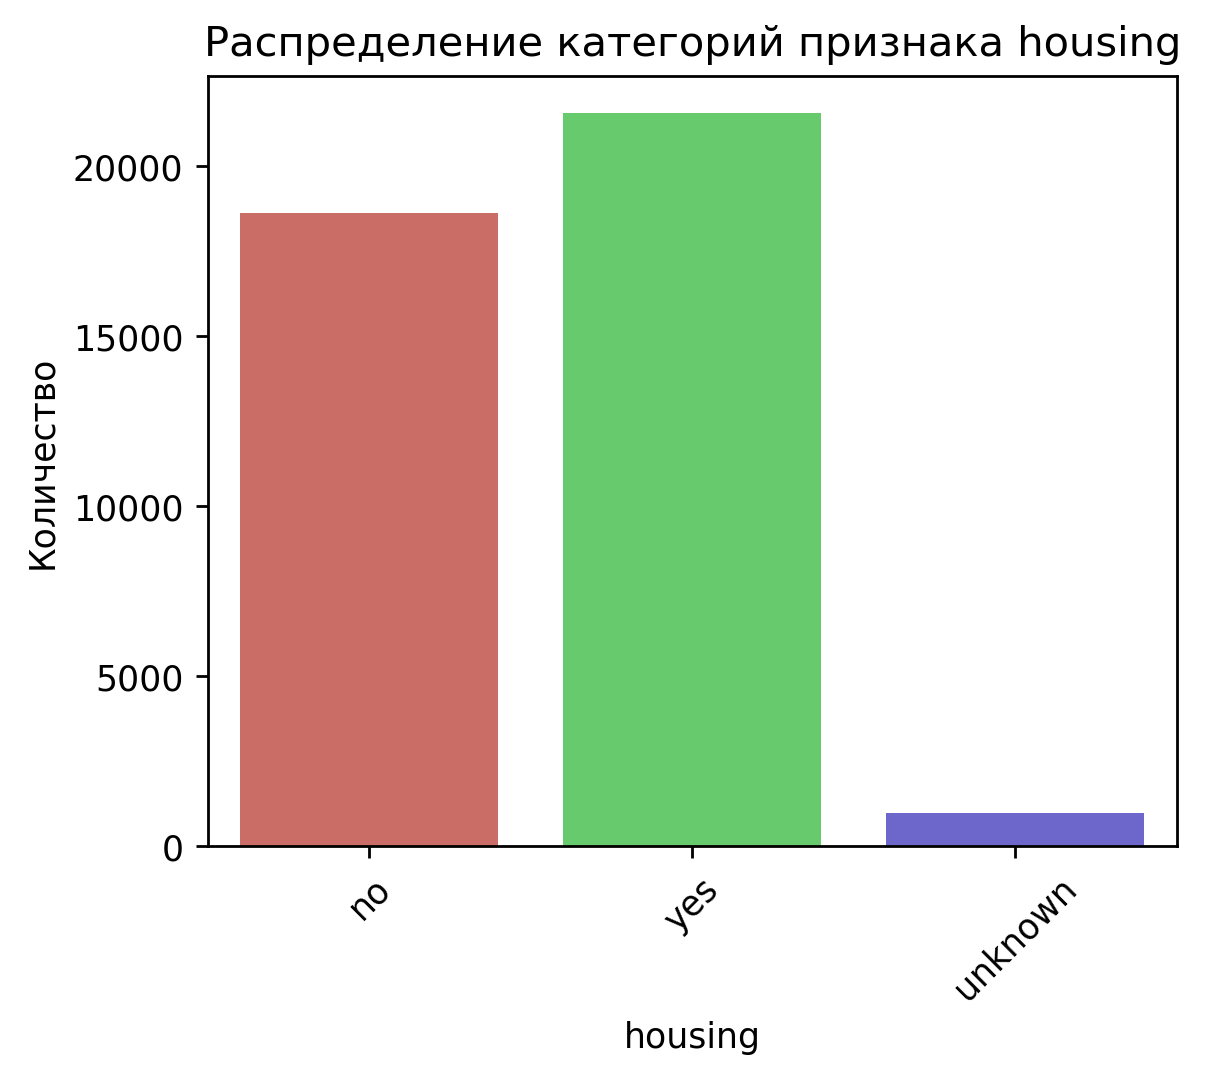

loan
no         0.824218
yes        0.151739
unknown    0.024043
Name: proportion, dtype: float64


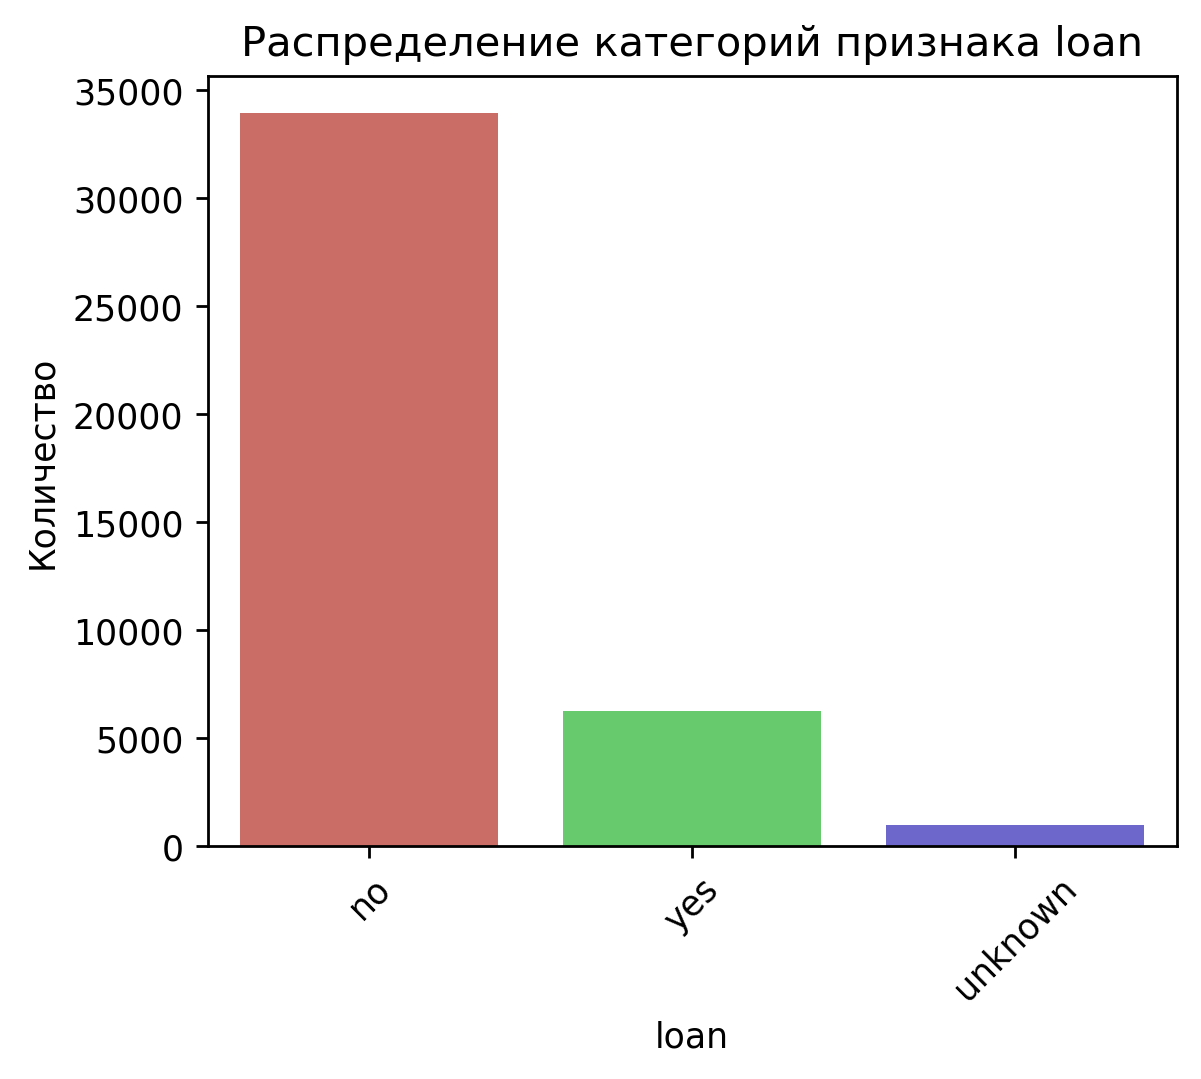

contact
cellular     0.634714
telephone    0.365286
Name: proportion, dtype: float64


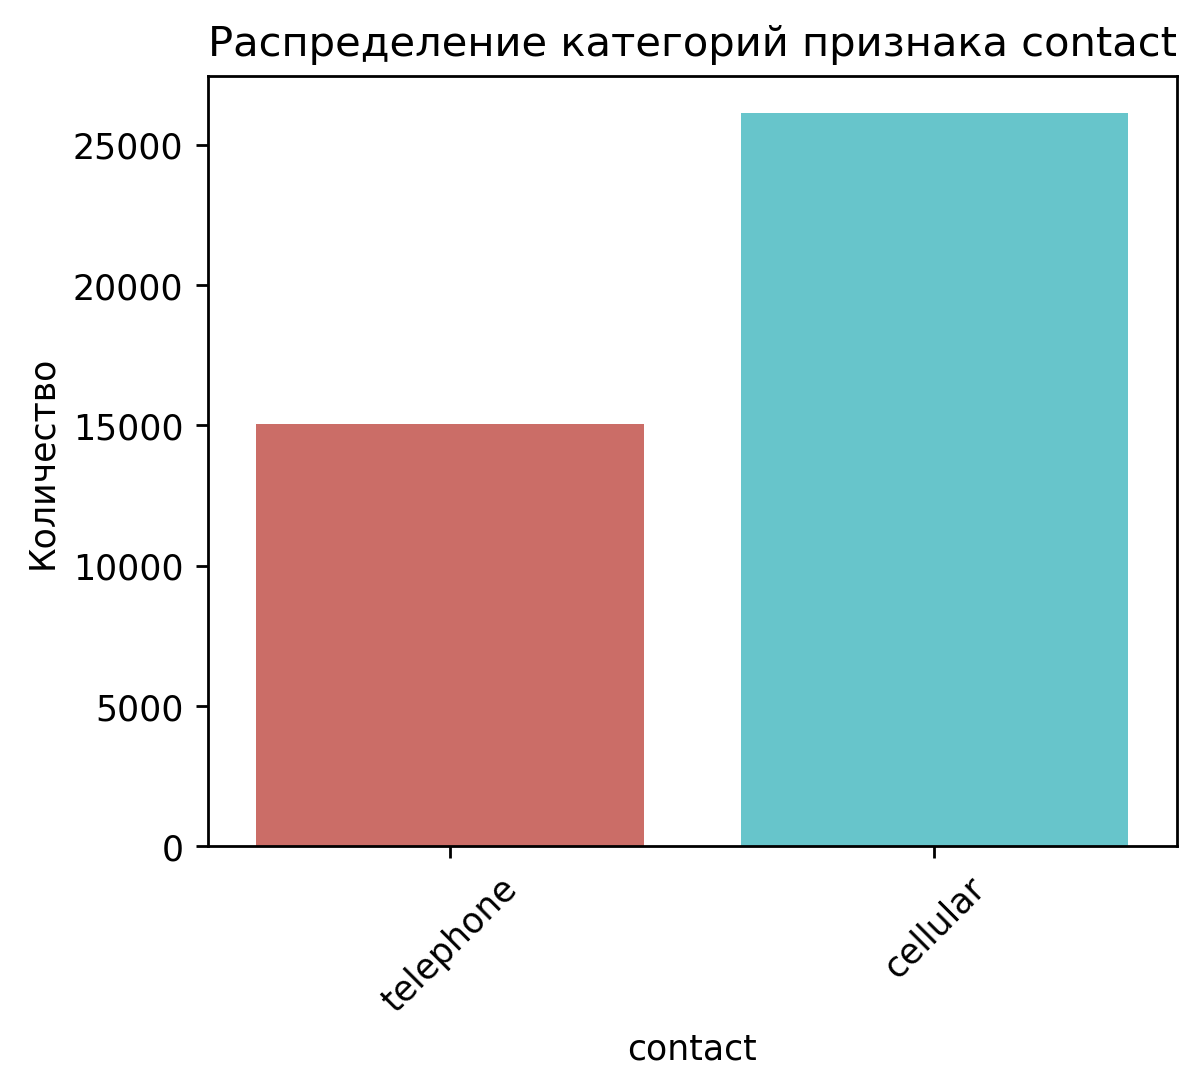

month
may    0.334345
jul    0.174106
aug    0.149990
jun    0.129153
nov    0.099573
apr    0.063896
oct    0.017413
sep    0.013843
mar    0.013260
dec    0.004420
Name: proportion, dtype: float64


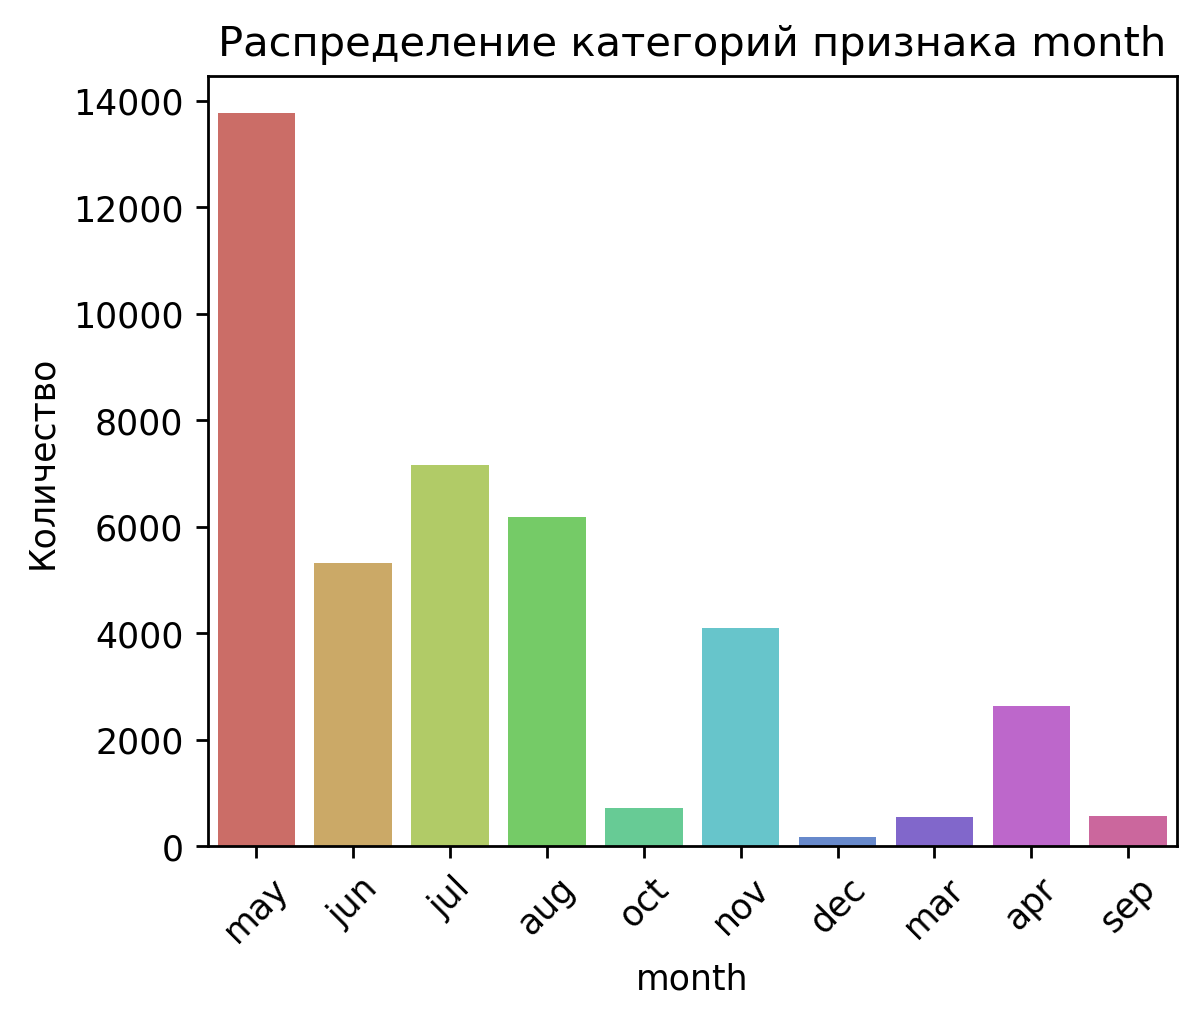

day_of_week
thu    0.209297
mon    0.206722
wed    0.197542
tue    0.196377
fri    0.190062
Name: proportion, dtype: float64


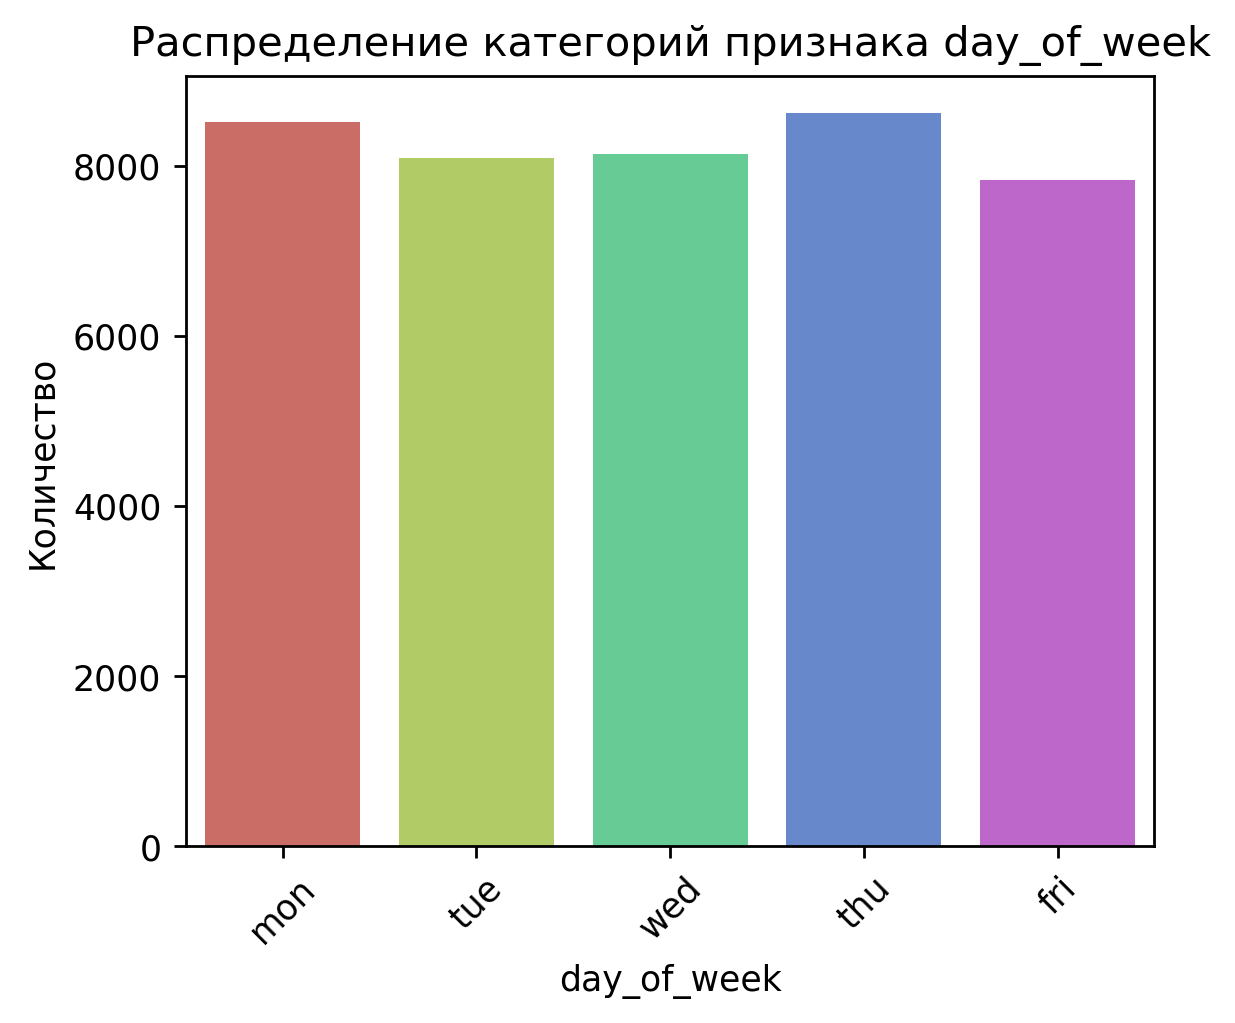

poutcome
nonexistent    0.863391
failure        0.103264
success        0.033345
Name: proportion, dtype: float64


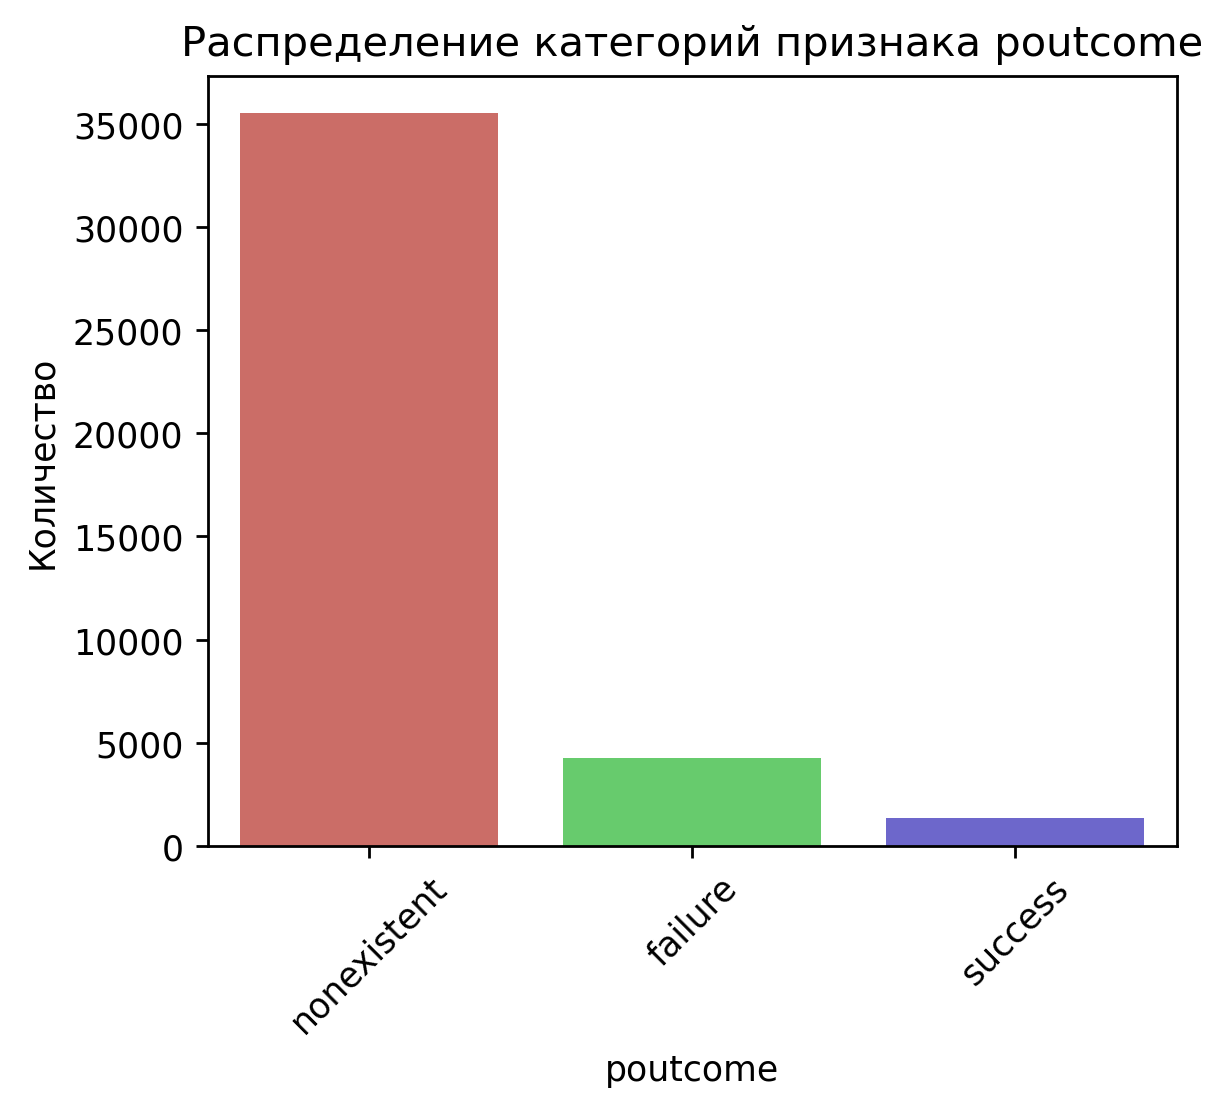

In [406]:
for col in df_cat_columns.drop("y", axis=1):
    draw_countplot(col, df_cat_columns)

### Посмотрим на распределение для положительных целевых переменным и отрицательных

In [407]:
def draw_countplot_y(col, df):
    print(df[col].value_counts(normalize=True))

    fig = plt.figure(figsize=(5, 4), dpi=250)
    sns.countplot(data=df, x=col, hue="y", palette={0: "red", 1: "green"})
    plt.xticks(rotation=45)
    plt.legend(title='Подписался на депозит?', labels=['Нет (0)', 'Да (1)'])
    plt.show()

job
admin.           0.253036
blue-collar      0.224718
technician       0.163663
services         0.096343
management       0.071012
retired          0.041723
entrepreneur     0.035360
self-employed    0.034510
housemaid        0.025743
unemployed       0.024626
student          0.021250
unknown          0.008014
Name: proportion, dtype: float64


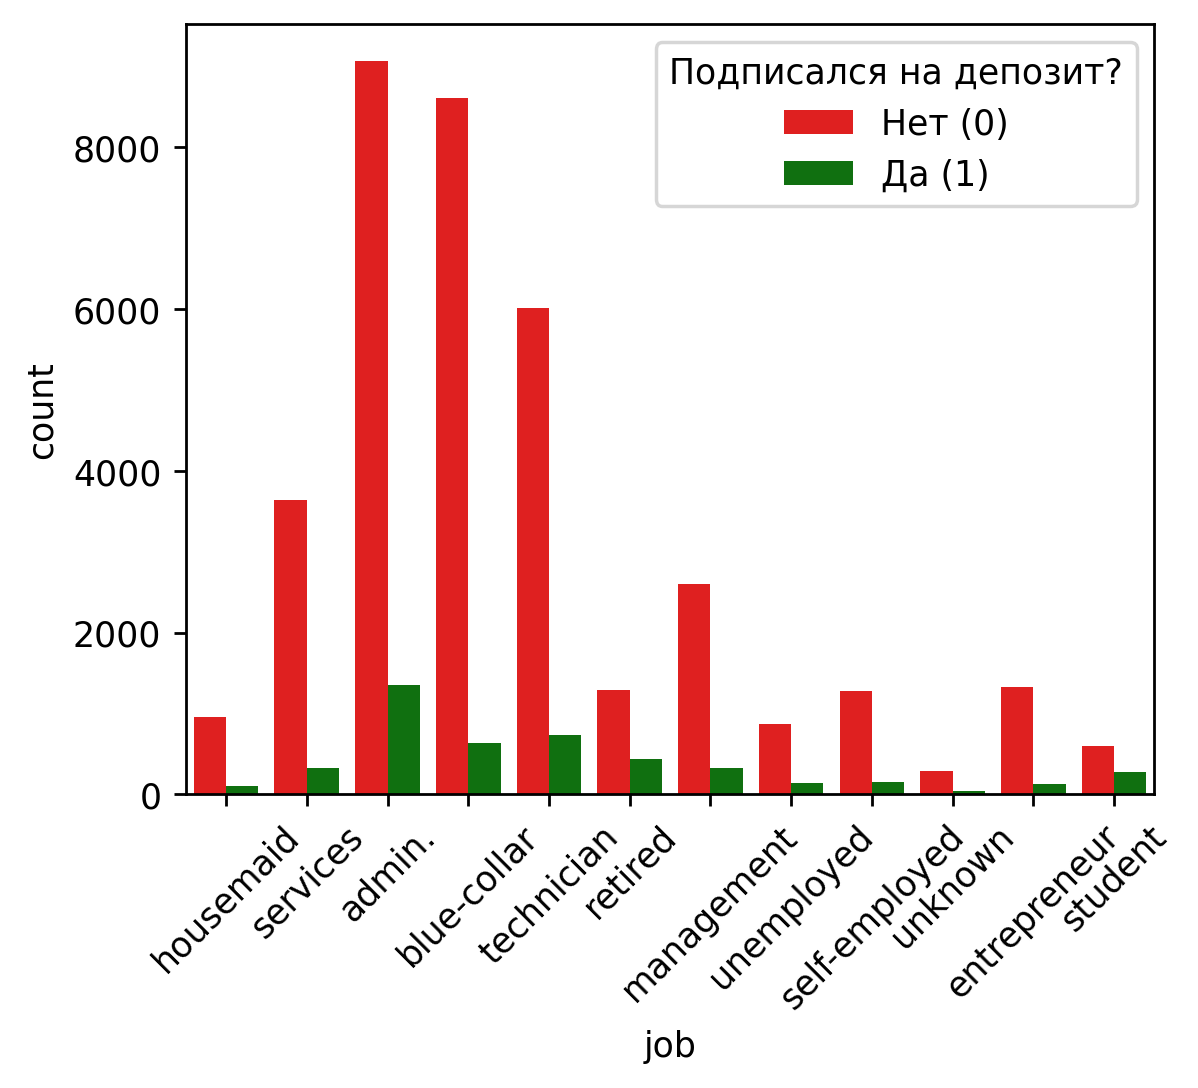

marital
married     0.605231
single      0.280843
divorced    0.111983
unknown     0.001943
Name: proportion, dtype: float64


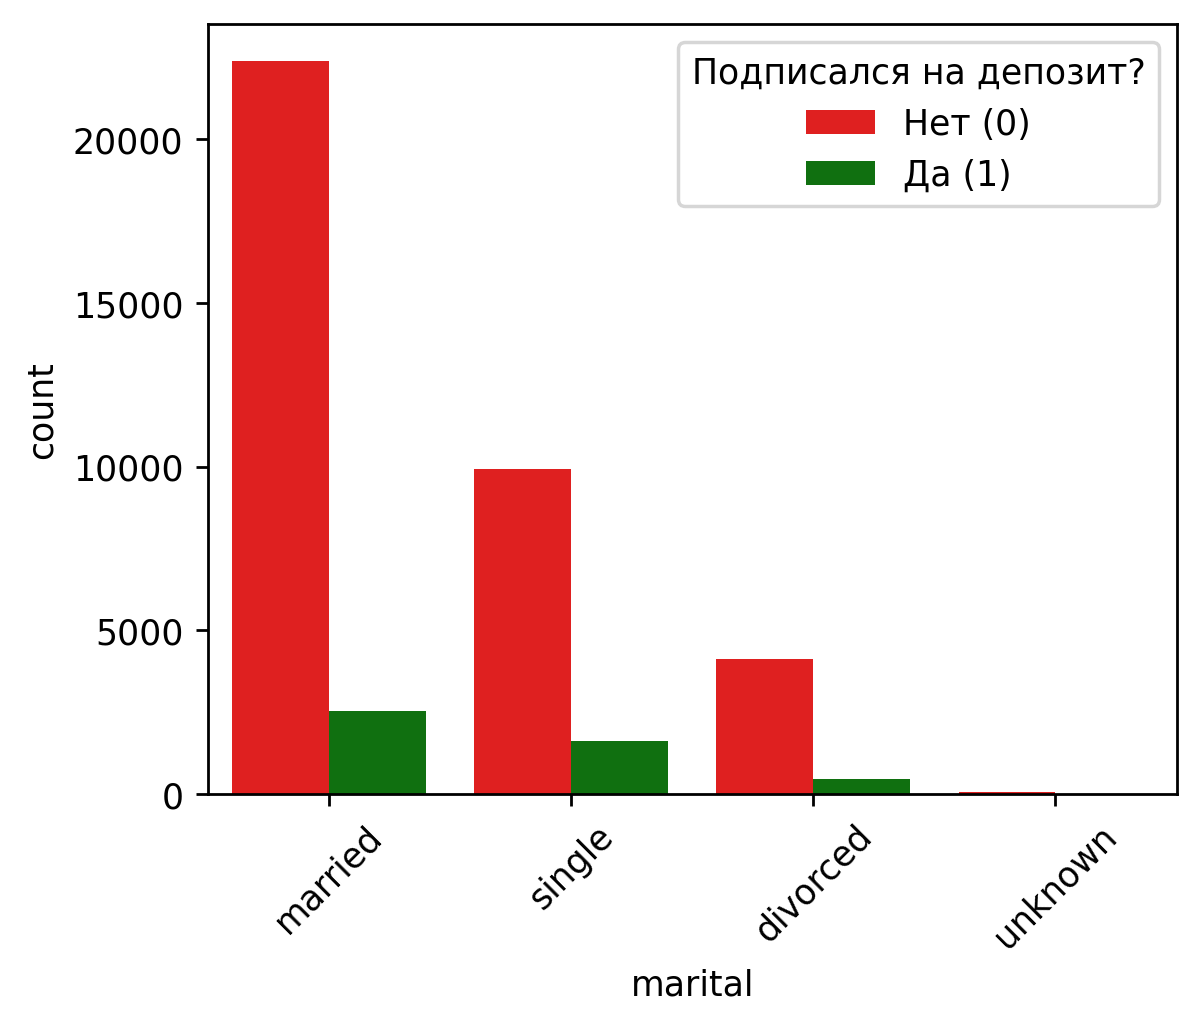

education
university.degree      0.295415
high.school            0.231008
basic.9y               0.146809
professional.course    0.127259
basic.4y               0.101418
basic.6y               0.055639
unknown                0.042015
illiterate             0.000437
Name: proportion, dtype: float64


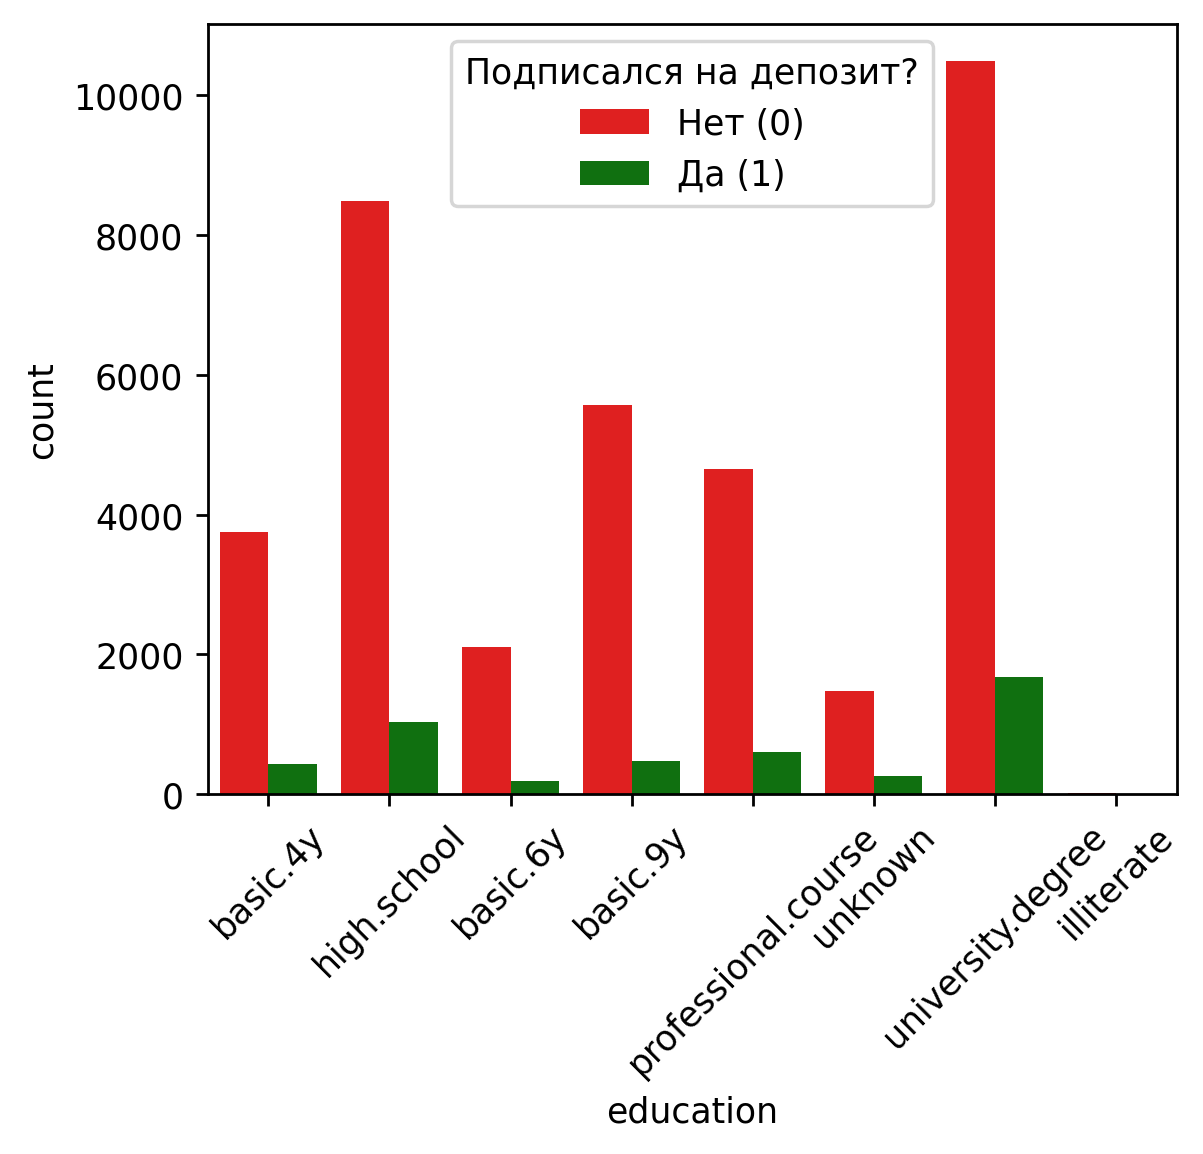

default
no         0.791165
unknown    0.208762
yes        0.000073
Name: proportion, dtype: float64


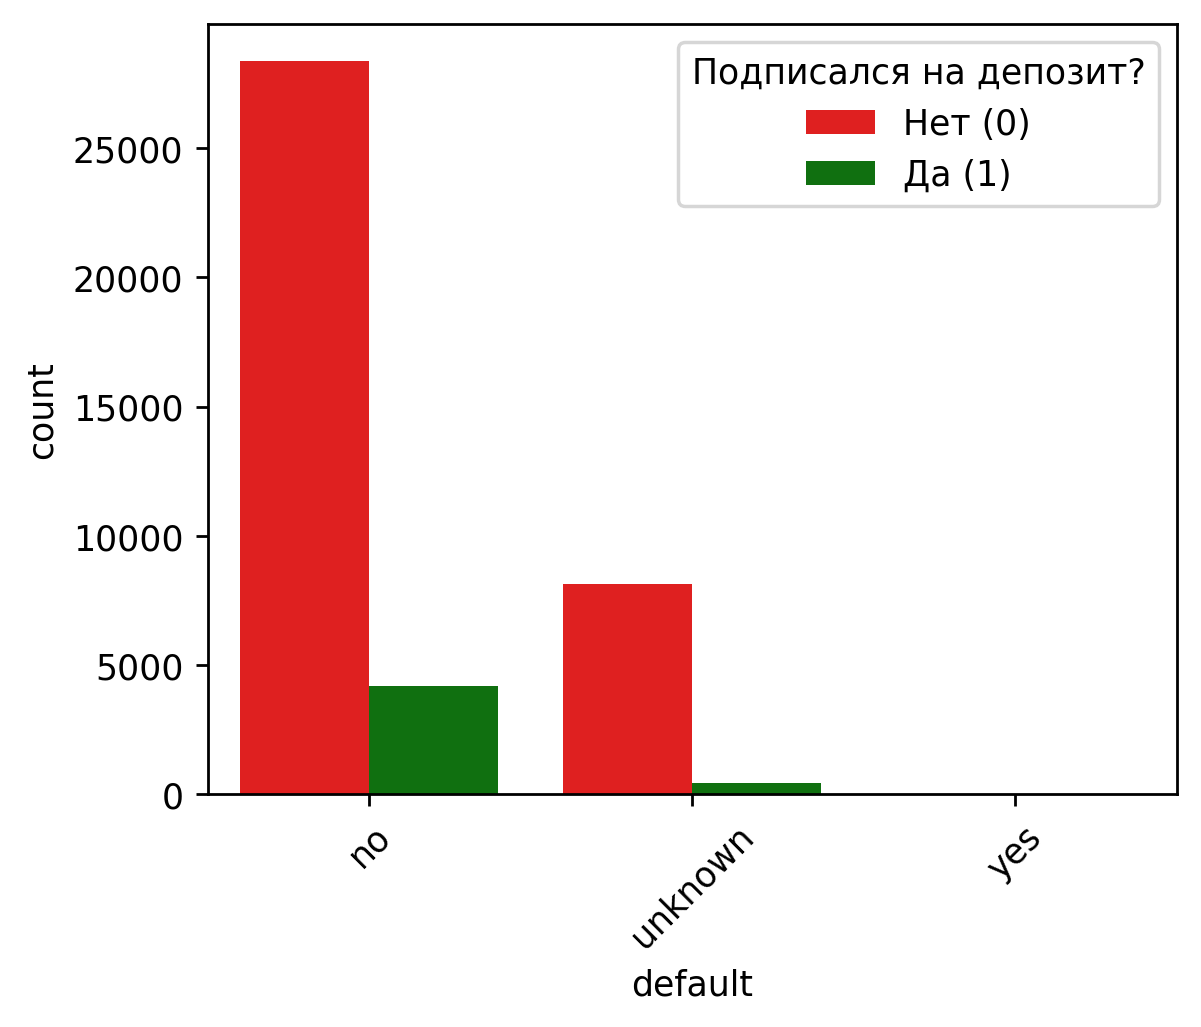

housing
yes        0.523873
no         0.452084
unknown    0.024043
Name: proportion, dtype: float64


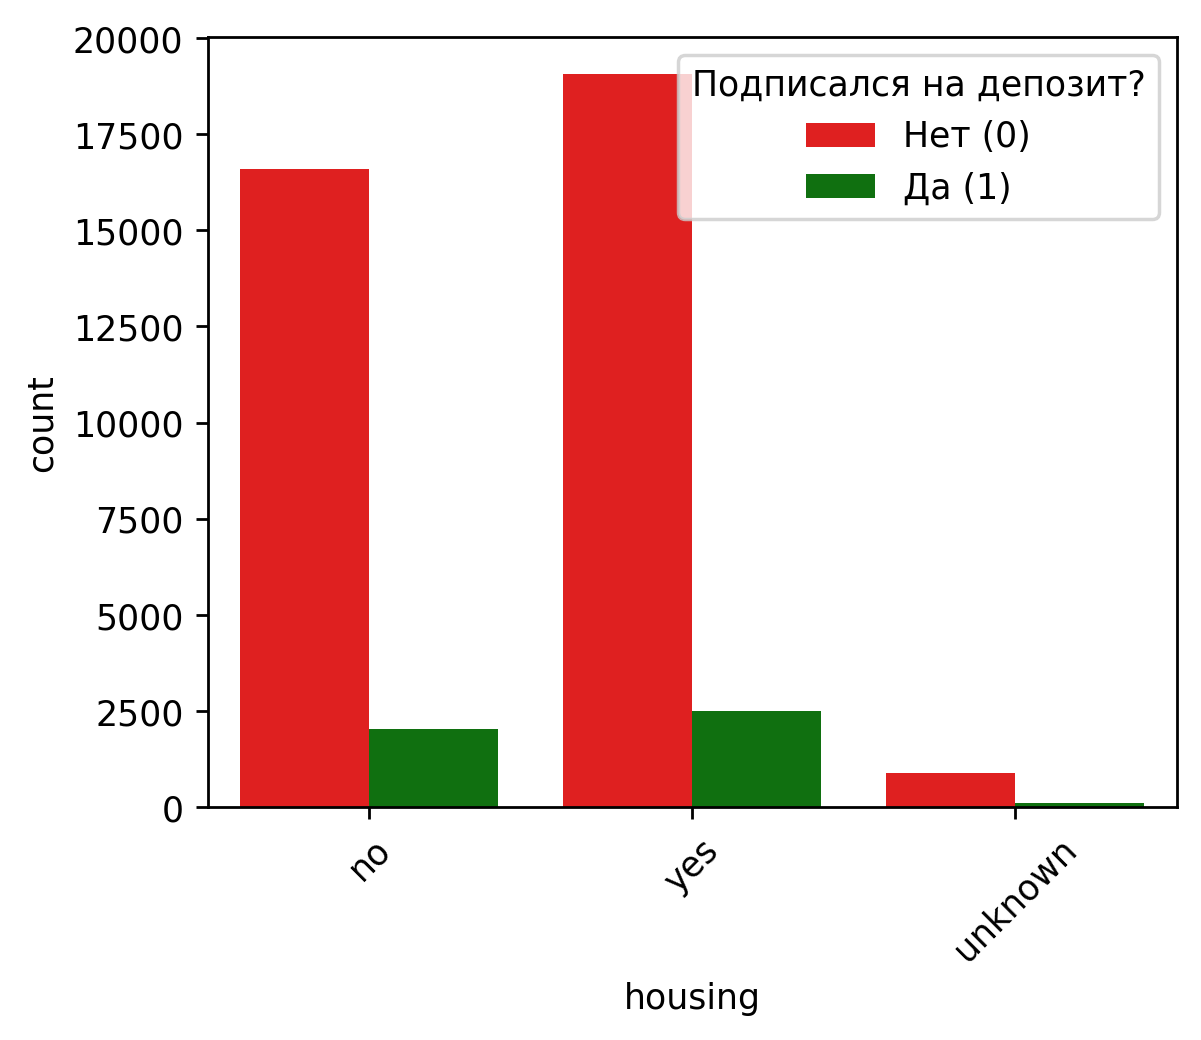

loan
no         0.824218
yes        0.151739
unknown    0.024043
Name: proportion, dtype: float64


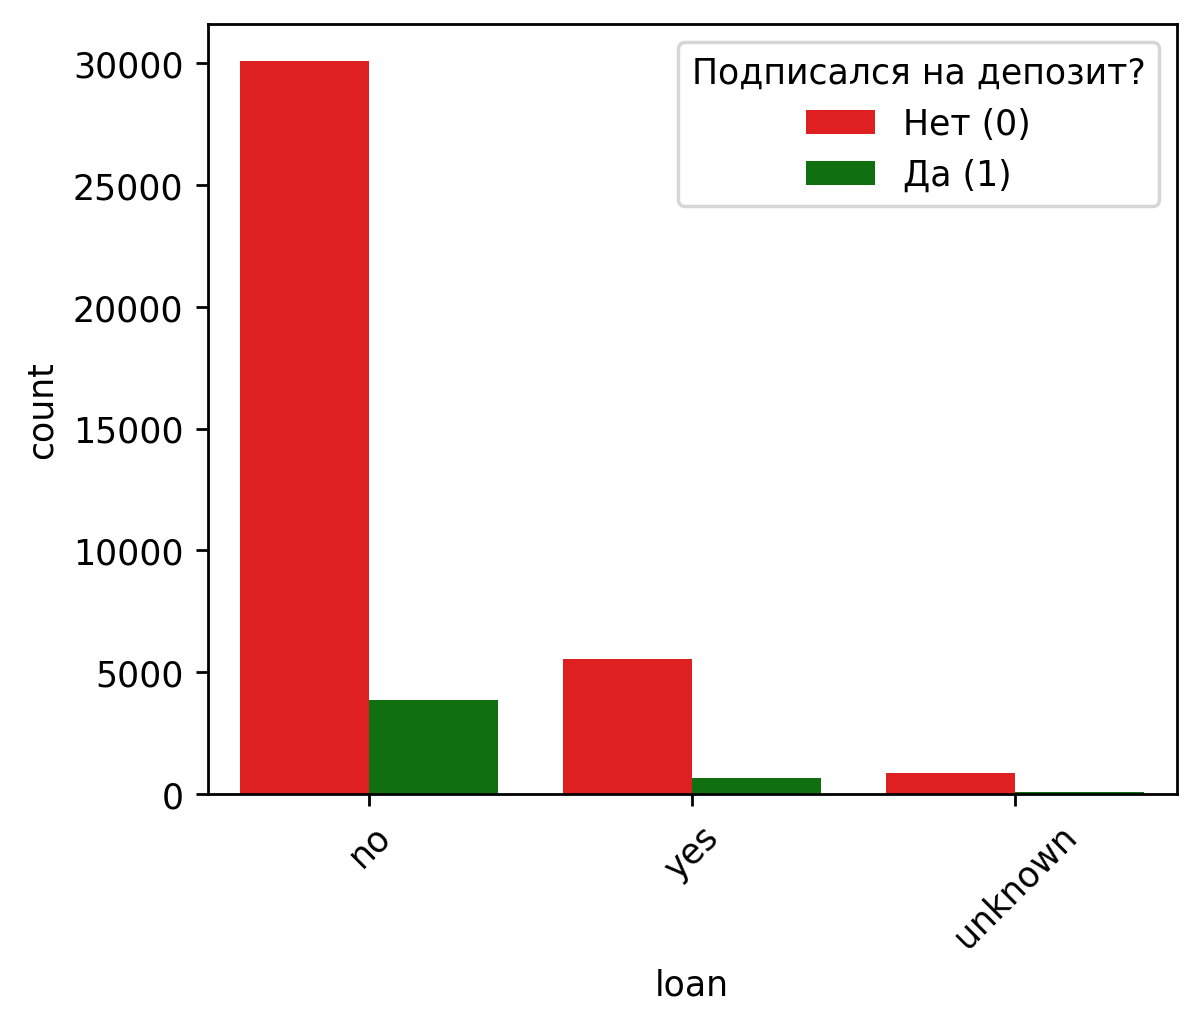

contact
cellular     0.634714
telephone    0.365286
Name: proportion, dtype: float64


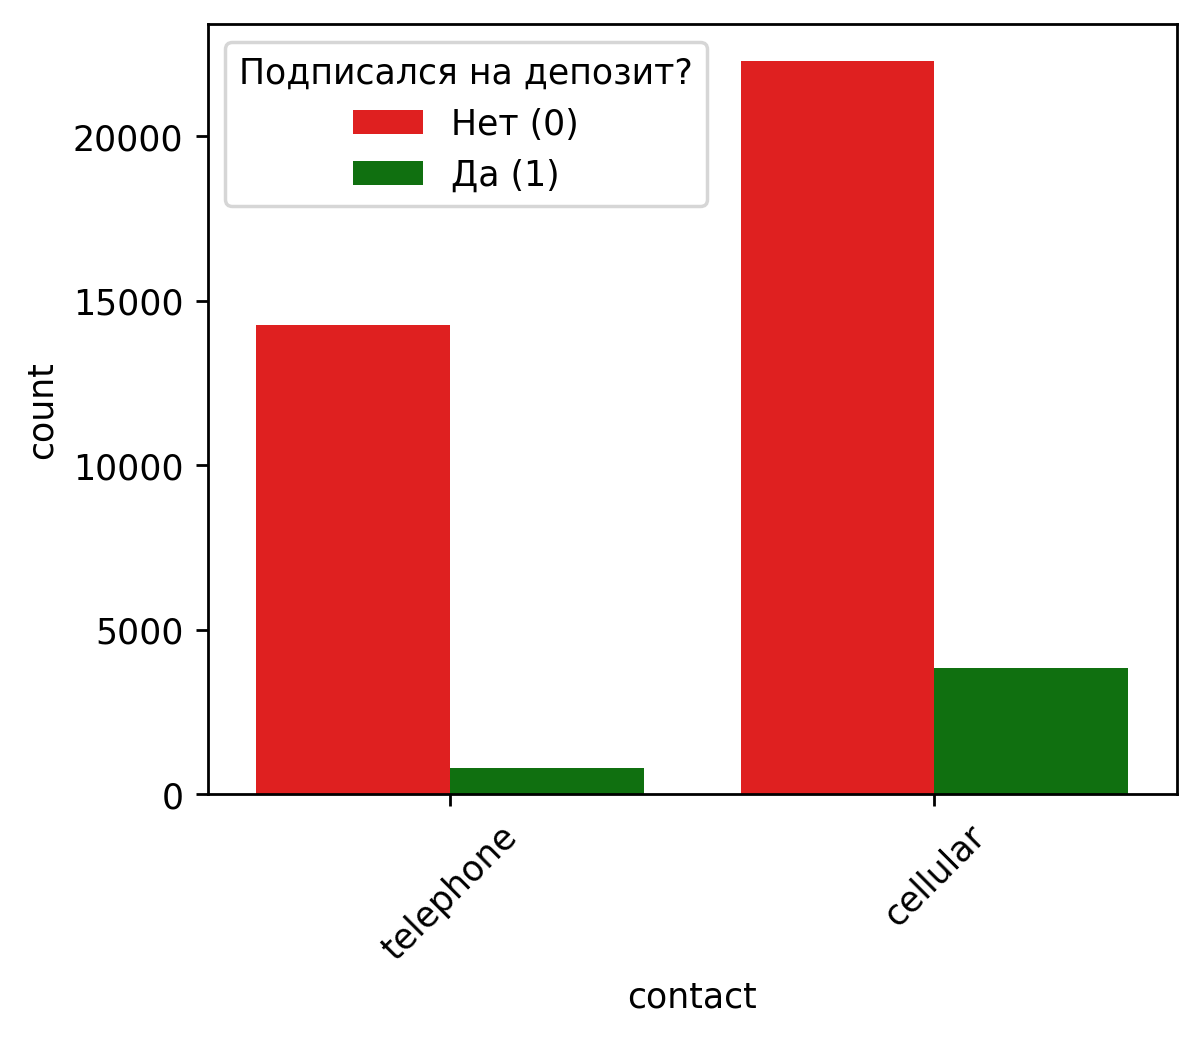

month
may    0.334345
jul    0.174106
aug    0.149990
jun    0.129153
nov    0.099573
apr    0.063896
oct    0.017413
sep    0.013843
mar    0.013260
dec    0.004420
Name: proportion, dtype: float64


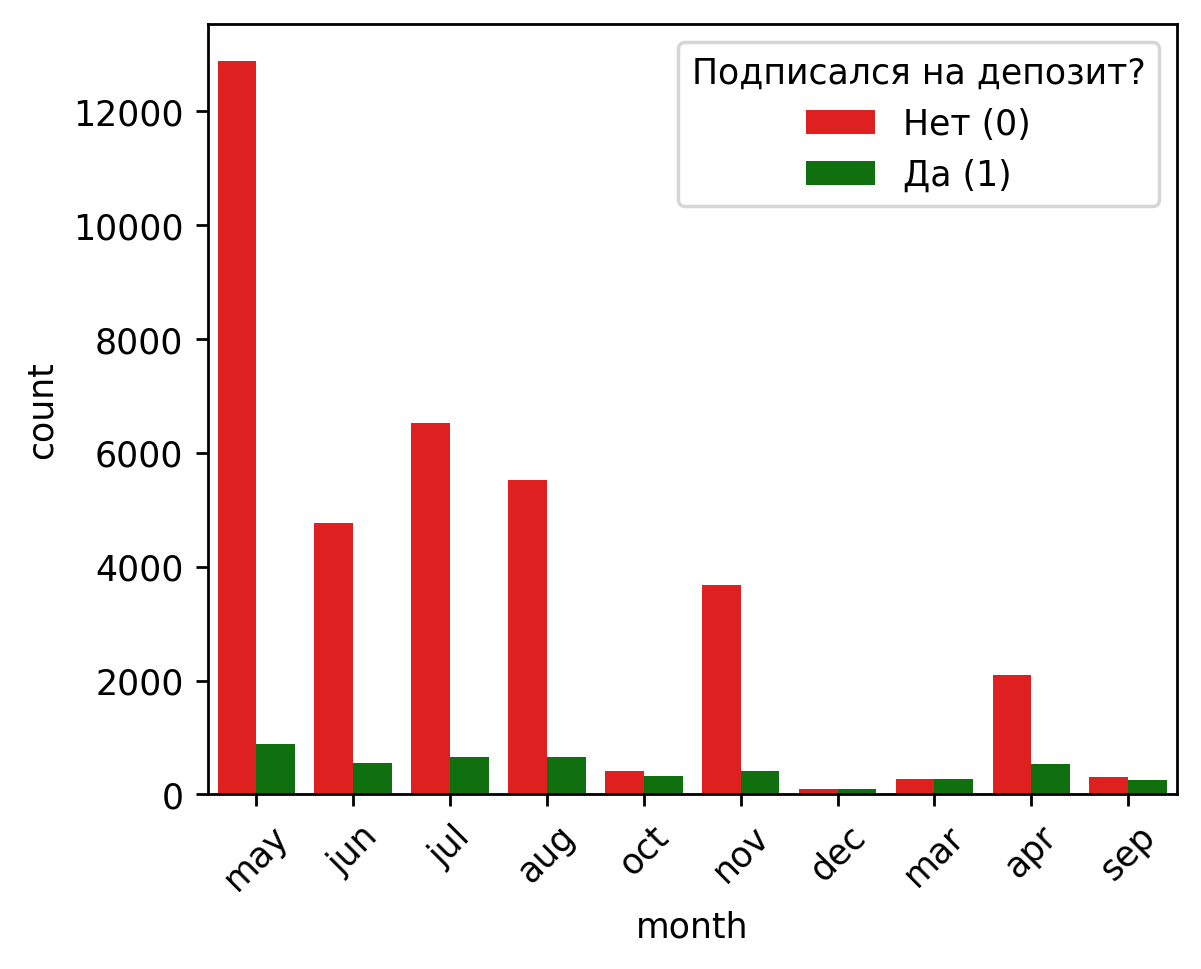

day_of_week
thu    0.209297
mon    0.206722
wed    0.197542
tue    0.196377
fri    0.190062
Name: proportion, dtype: float64


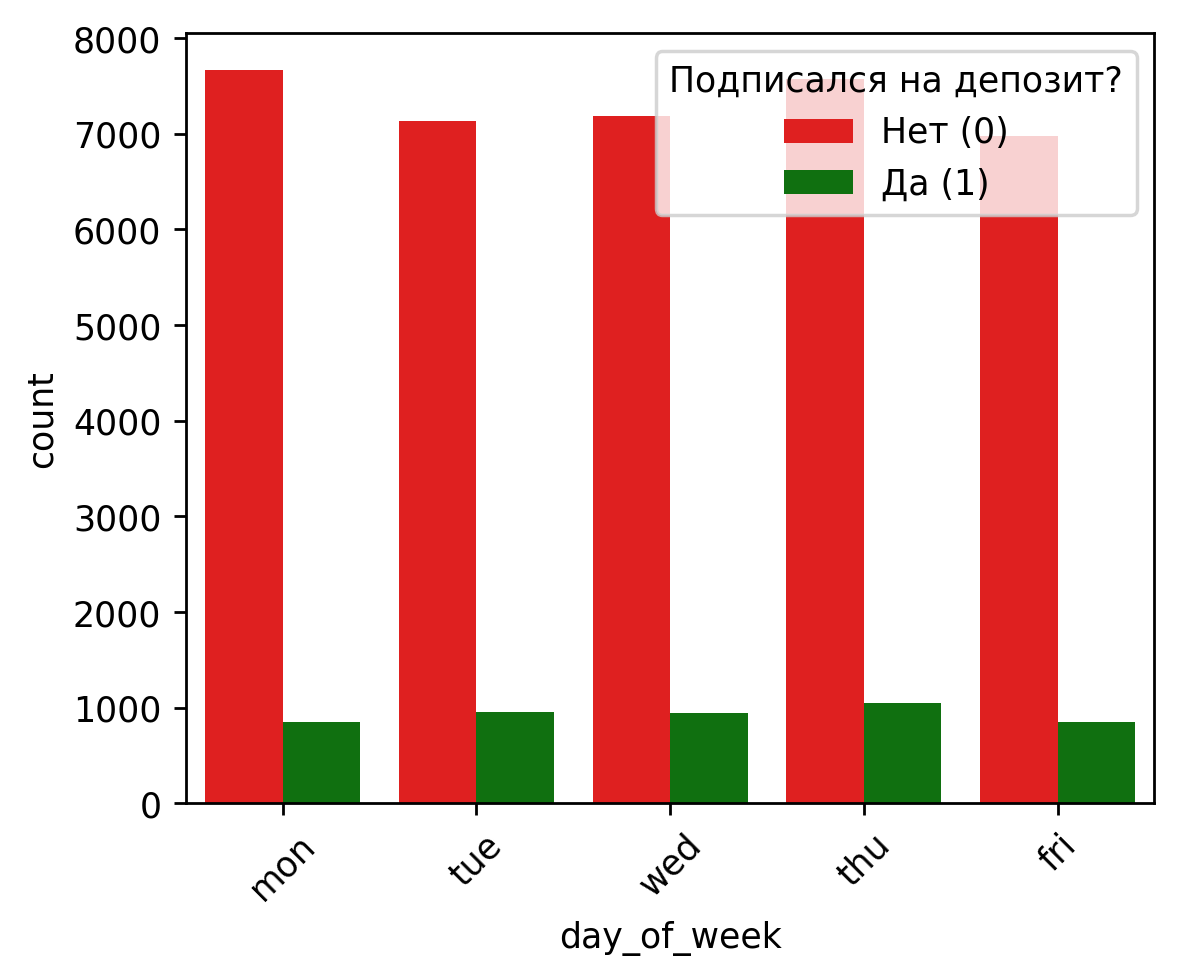

poutcome
nonexistent    0.863391
failure        0.103264
success        0.033345
Name: proportion, dtype: float64


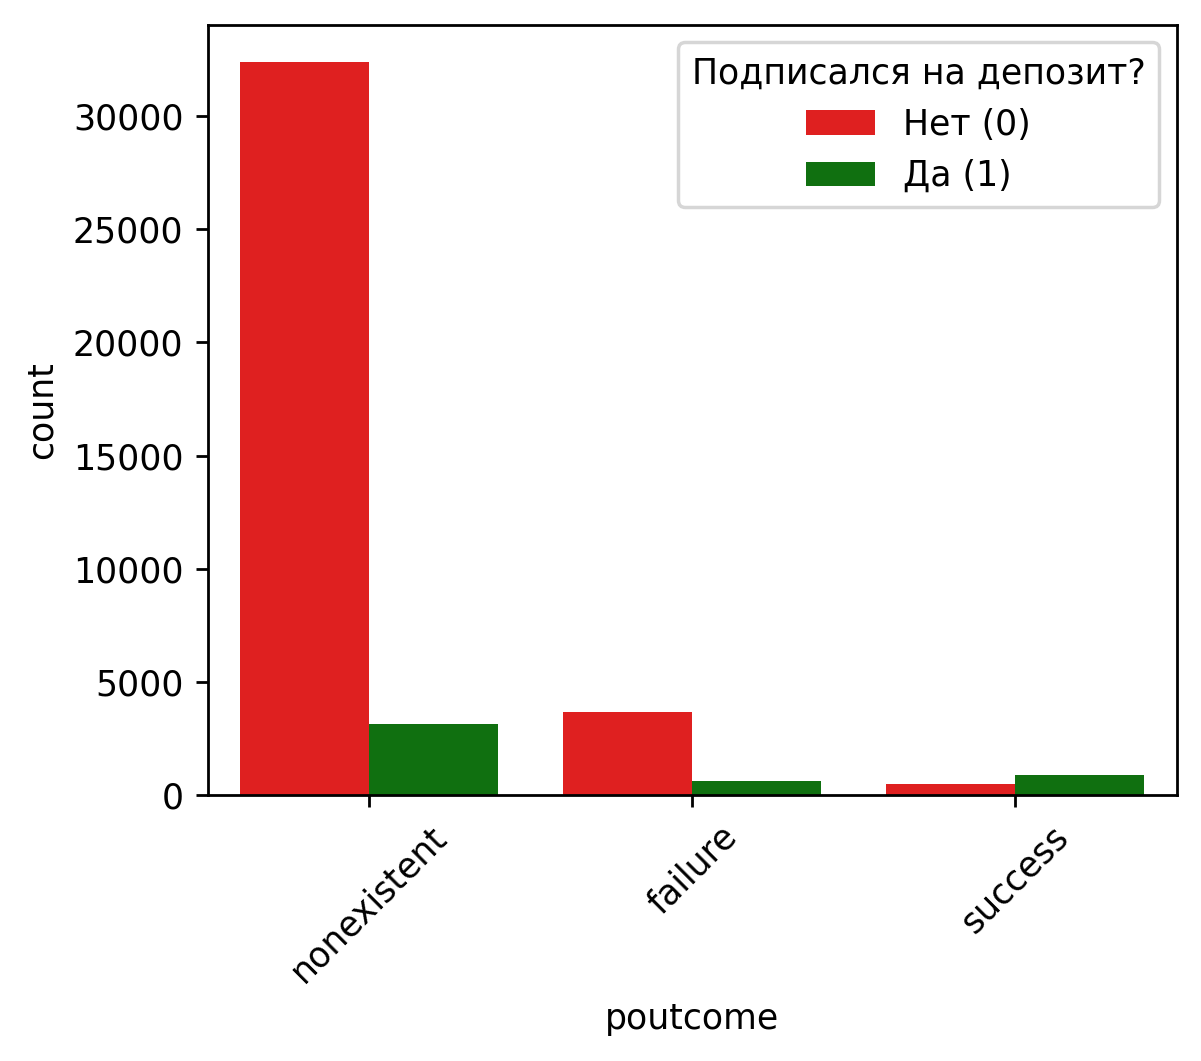

In [408]:
for col in df_cat_columns.drop("y", axis=1):
    draw_countplot_y(col, df_cat_columns)

In [409]:
#Признак day_of_week распреден одинаков
#Используем таблицу сопряженности
print(pd.crosstab(df['day_of_week'], df['y'], normalize='index'))

y                   0         1
day_of_week                    
fri          0.891899  0.108101
mon          0.900493  0.099507
thu          0.878858  0.121142
tue          0.882142  0.117858
wed          0.883329  0.116671


In [410]:
#Удалим данный признак, так как распределение одинаковое(практически)
df_cat_columns.drop("day_of_week", axis=1, inplace=True)
print("Категория day_of_week была удалена!")

Категория day_of_week была удалена!


In [411]:
percentage_ratio = df.groupby("job")["y"].value_counts(normalize=True).unstack()
percentage_ratio = percentage_ratio.sort_values(by=1, ascending=False)
percentage_ratio.index

Index(['student', 'retired', 'unemployed', 'admin.', 'management', 'unknown',
       'technician', 'self-employed', 'housemaid', 'entrepreneur', 'services',
       'blue-collar'],
      dtype='object', name='job')

In [412]:
def plot_conversion_by_category(col, df):
    percentage_ratio = df.groupby("job")["y"].value_counts(normalize=True).unstack()
    percentage_ratio = percentage_ratio.sort_values(by=1, ascending=False)
    
    fig = plt.figure(figsize=(5, 4), dpi=250)
    plt.title(f"Процентное положительное соотношение колонки {col}")
    plt.xlabel(f"Категории признака {col}")
    plt.ylabel(f"Процентное соотношение признака {col} для y=1")
    sns.barplot(x=percentage_ratio.index, y=percentage_ratio[1], palette='viridis')
    plt.xticks(rotation=45)
    plt.show()

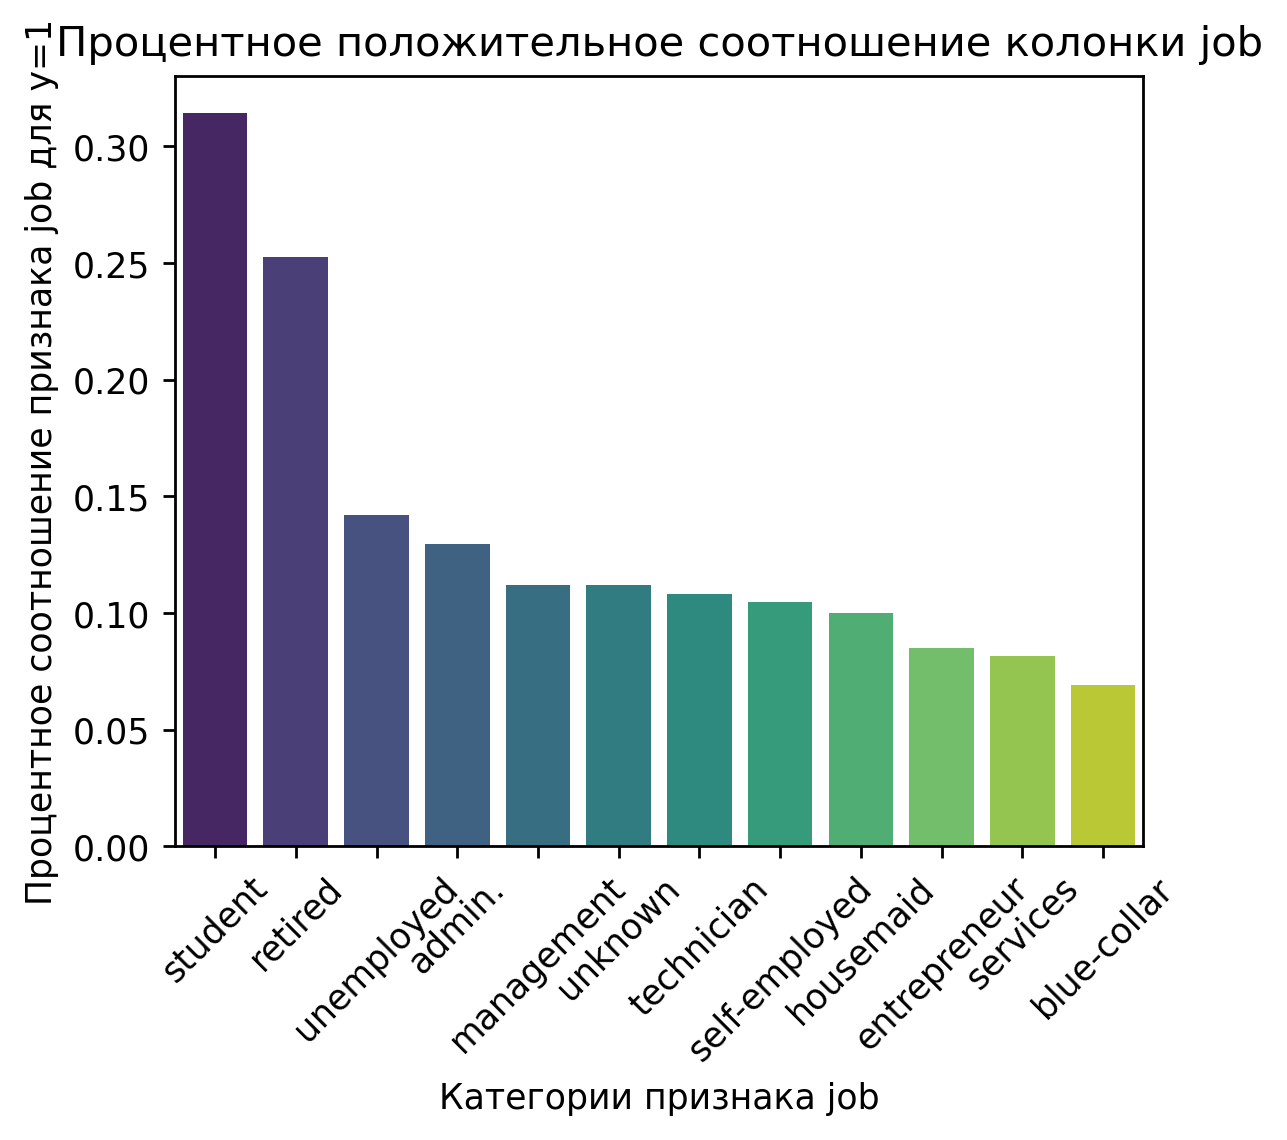

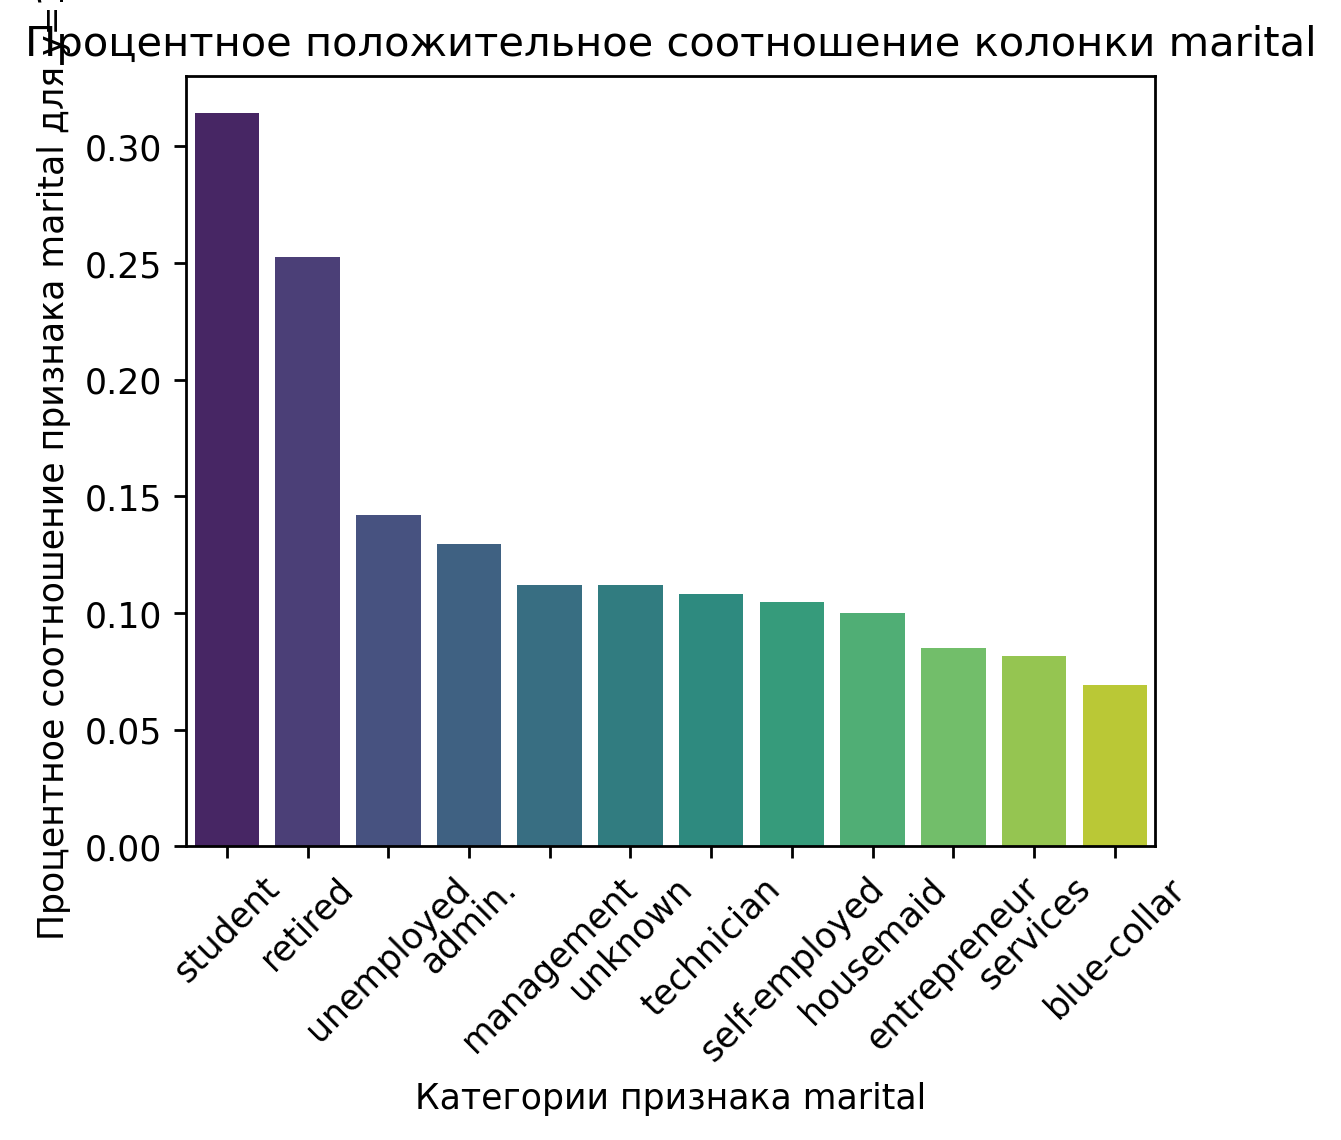

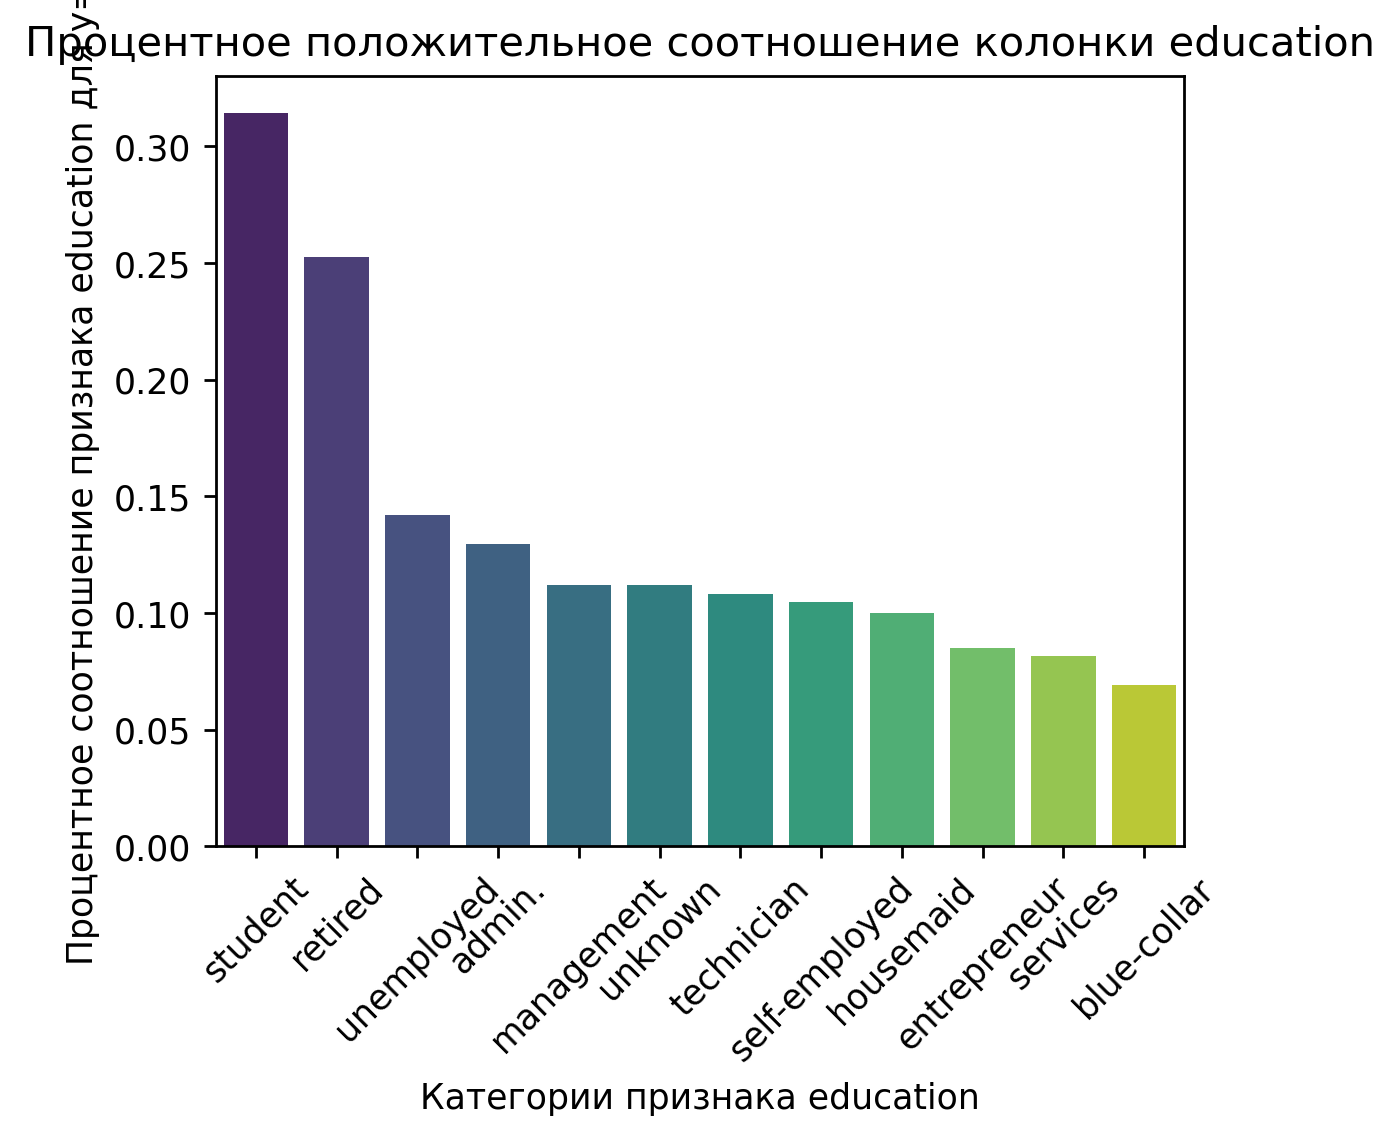

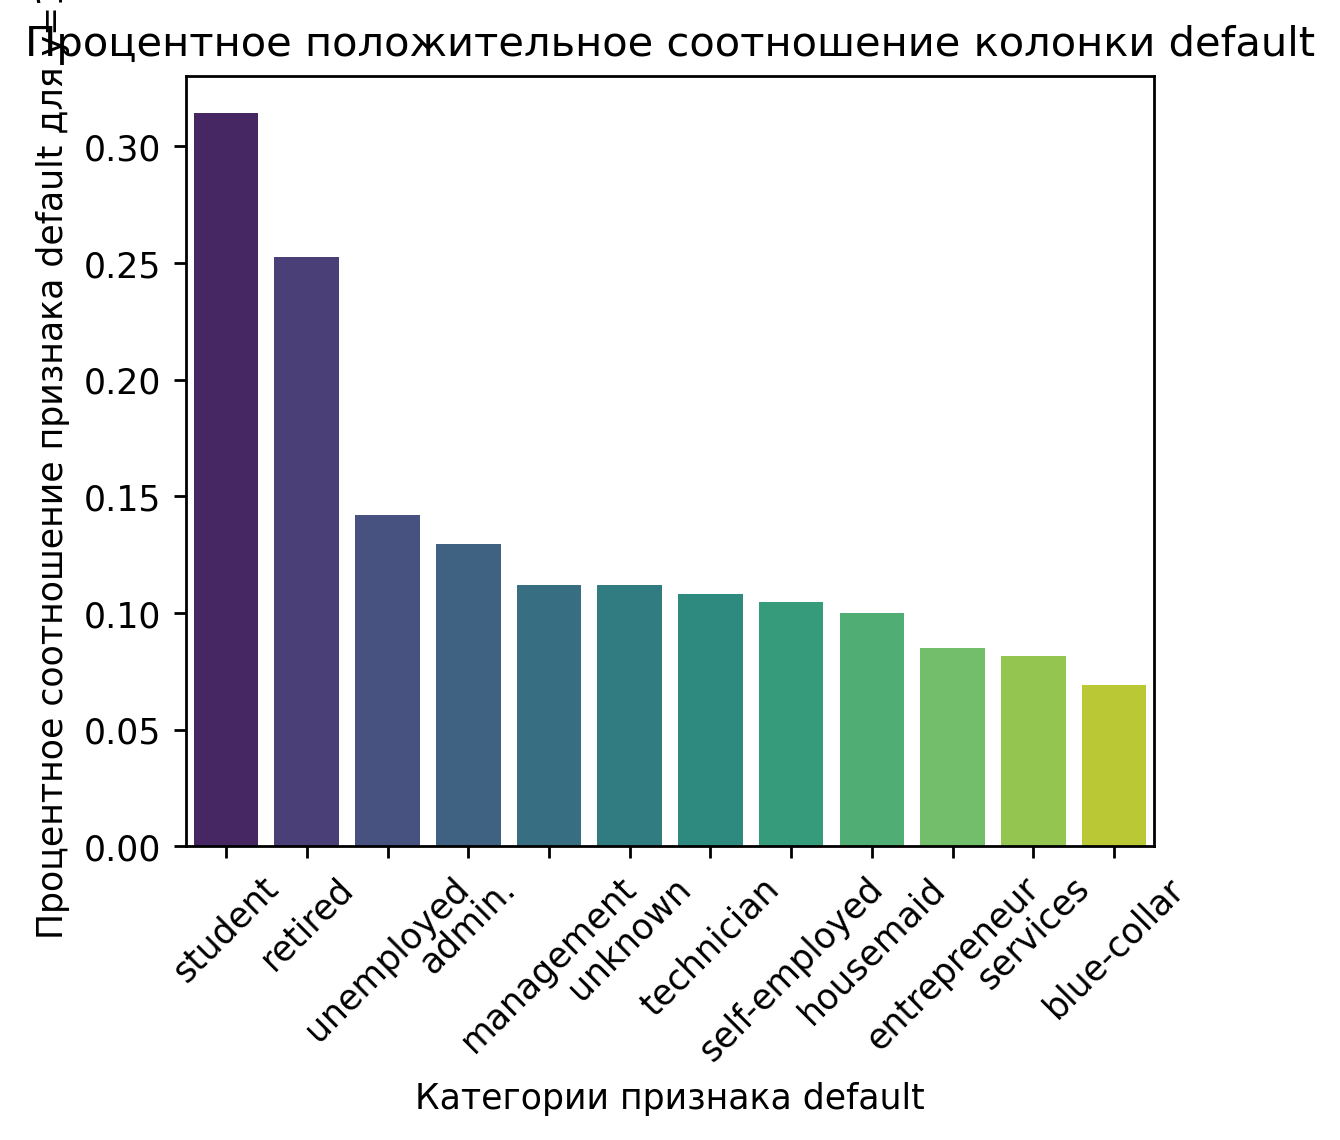

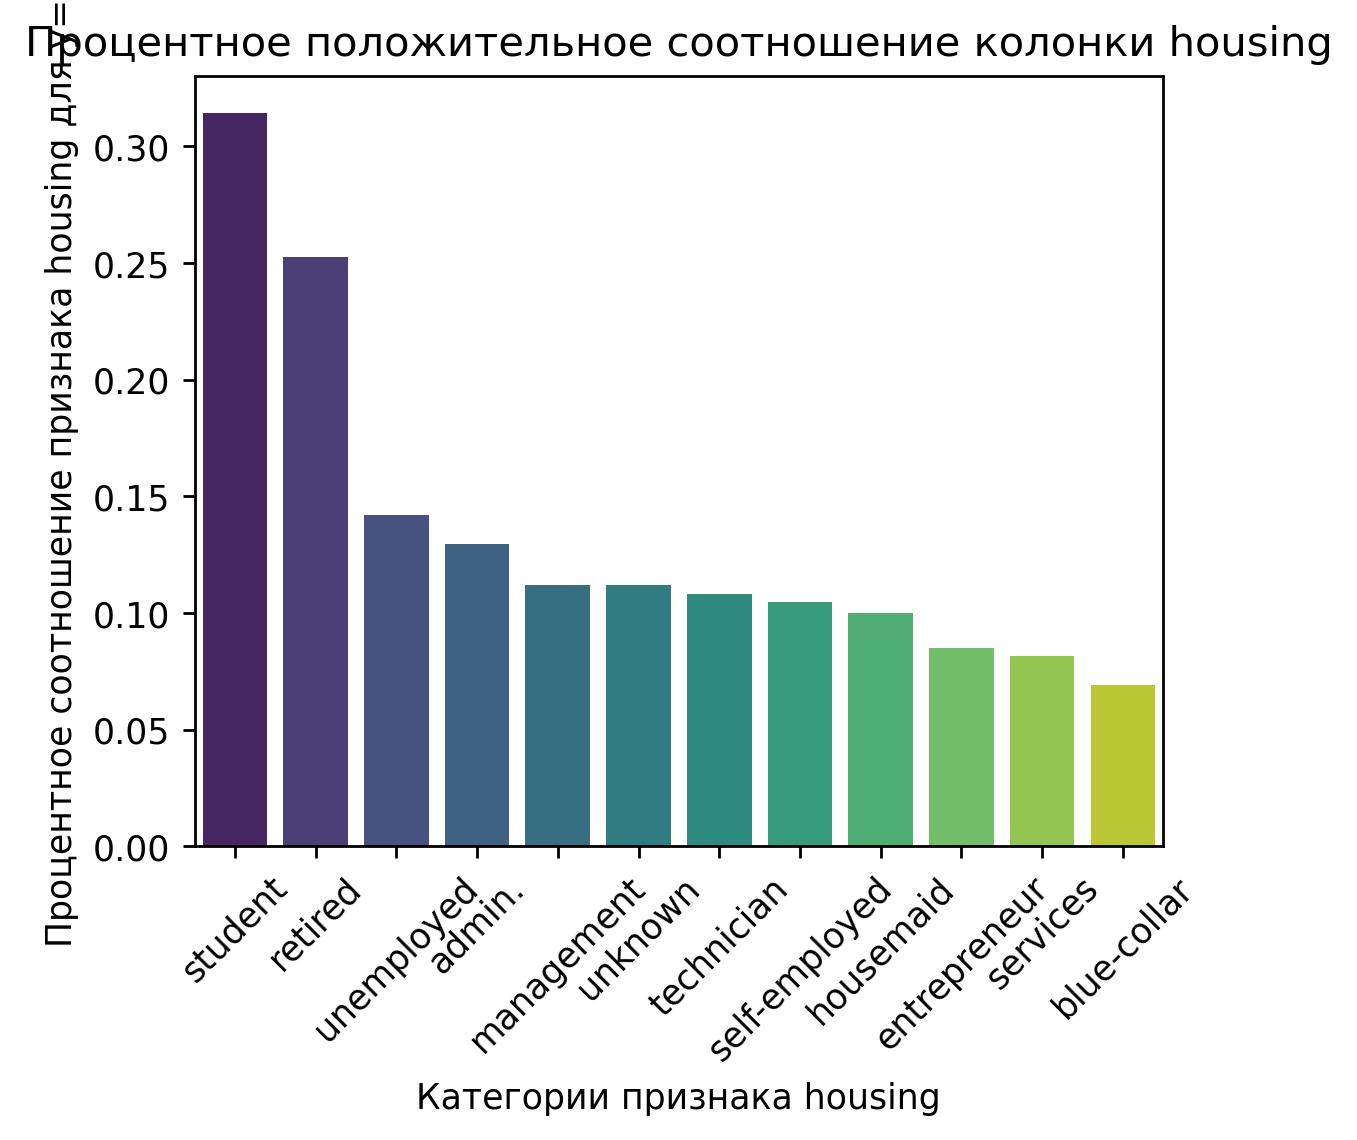

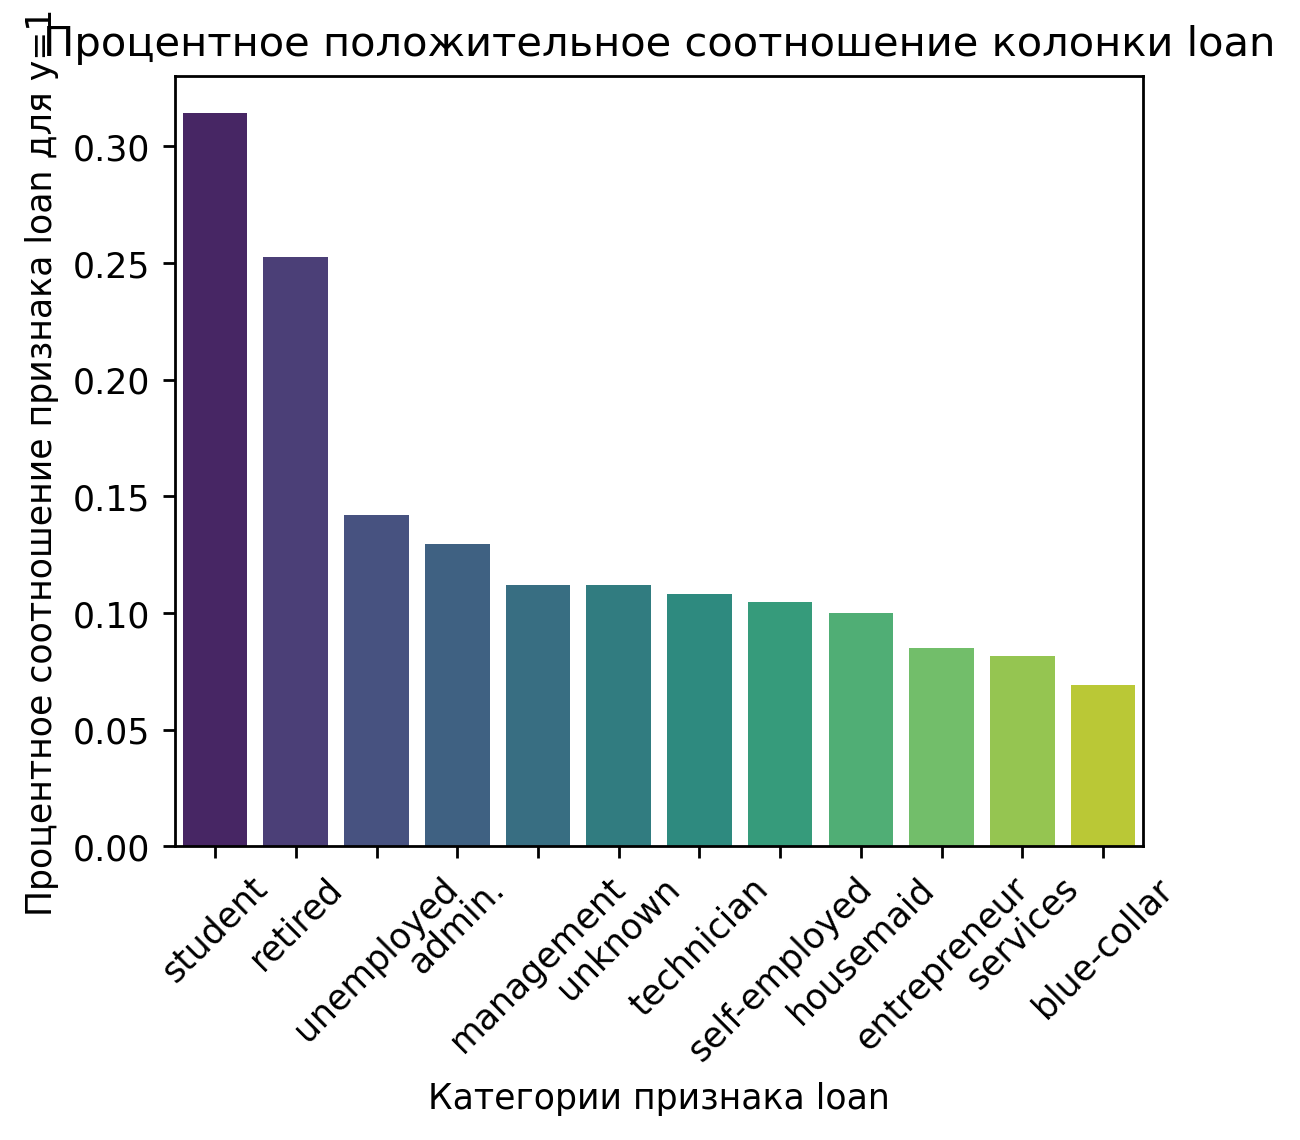

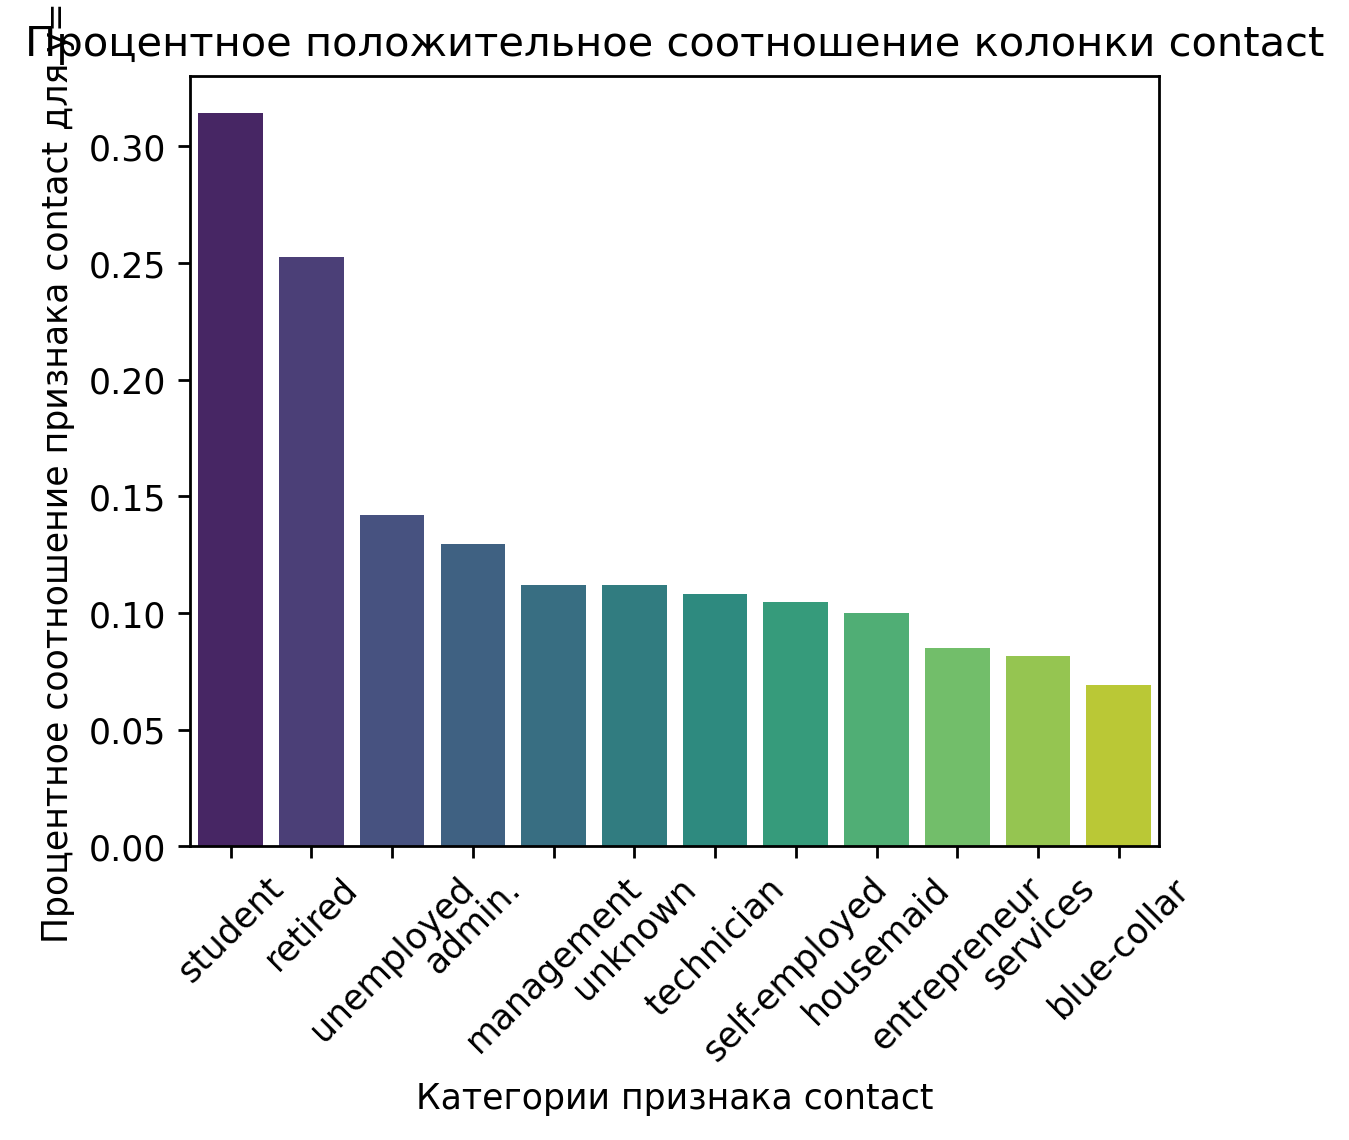

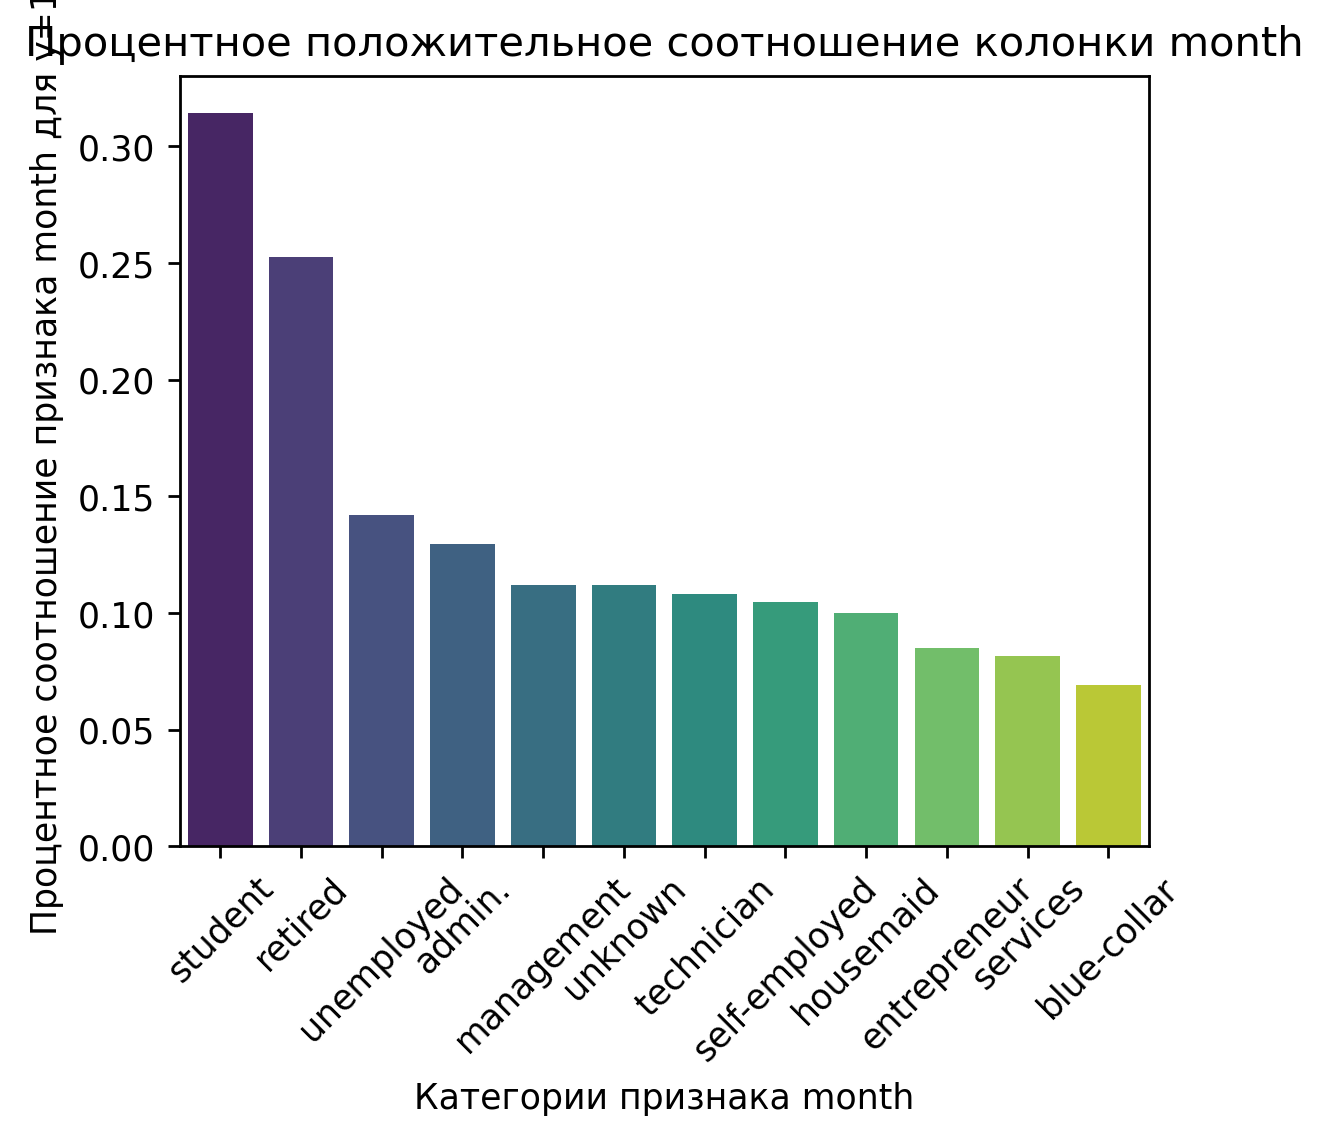

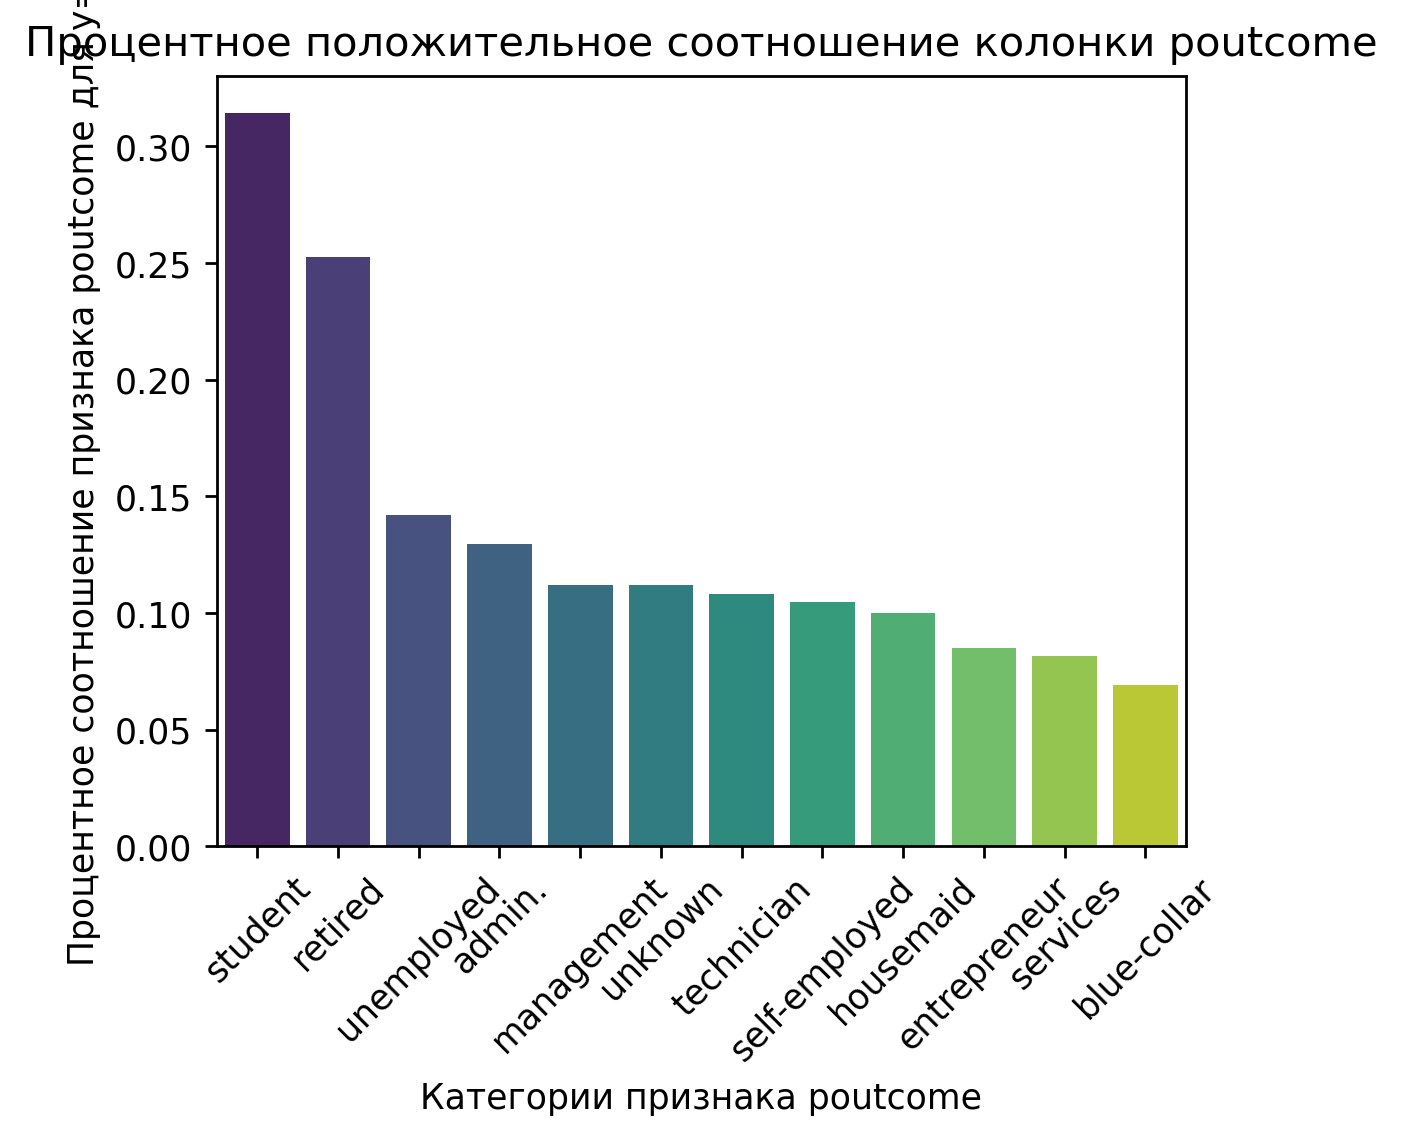

In [413]:
for col in df_cat_columns.drop("y", axis=1).columns:
    plot_conversion_by_category(col, df_cat_columns)

### Результат
Все категории в различных признаках имеют разное распределение, поэтому данные признаки оставляем

In [414]:
df_cat_columns.drop("y", axis=1, inplace=True)
print("Признак y удален!")

Признак y удален!


In [415]:
df_cat_columns.describe()

job  marital          education default housing   loan   contact  \
count    41176    41176              41176   41176   41176  41176     41176   
unique      12        4                  8       3       3      3         2   
top     admin.  married  university.degree      no     yes     no  cellular   
freq     10419    24921              12164   32577   21571  33938     26135   

        month     poutcome  
count   41176        41176  
unique     10            3  
top       may  nonexistent  
freq    13767        35551

In [416]:
preprocessing_df = pd.concat([df_num_columns, df_cat_columns], axis=1)
preprocessing_df.reset_index(drop=True, inplace=True)


cv = KFold(n_splits=5, shuffle=True, random_state=42)

for col in df_cat_columns.columns:
    if preprocessing_df[col].nunique() <= 5:
        ohe = pd.get_dummies(data=preprocessing_df[col], prefix=col, drop_first=True, dtype=int)
        preprocessing_df = pd.concat([preprocessing_df, ohe], axis=1)
        preprocessing_df.drop(col, axis=1, inplace=True)
    else:
        encoded_col_name = f'{col}_mean_encoded'
        preprocessing_df[encoded_col_name] = 0.0
        for train_index, val_index in cv.split(preprocessing_df[col]):
            mte_val = preprocessing_df.iloc[train_index].groupby(col)["y"].mean()
            map_values = preprocessing_df.loc[val_index, col].map(mte_val)
            noise = np.random.uniform(0.99, 1.01, size=len(map_values))

            preprocessing_df.loc[val_index, encoded_col_name] = map_values * noise

        #Если в какой-то фолд попали не все категории при группировке, то в некоторых строках возникнут пропуски
        #Тогда заполним их средним по y
        mean = preprocessing_df["y"].mean()
        preprocessing_df[encoded_col_name].fillna(mean, inplace=True)

        preprocessing_df.drop(col, axis=1, inplace=True)
print("Все колонки были закодированы!")

Все колонки были закодированы!


In [417]:
preprocessing_df.dtypes

age                       float64
campaign                  float64
previous                    int64
cons.price.idx            float64
cons.conf.idx             float64
euribor3m                 float64
y                           int64
presence_of_contact         int64
job_mean_encoded          float64
marital_married             int64
marital_single              int64
marital_unknown             int64
education_mean_encoded    float64
default_unknown             int64
default_yes                 int64
housing_unknown             int64
housing_yes                 int64
loan_unknown                int64
loan_yes                    int64
contact_telephone           int64
month_mean_encoded        float64
poutcome_nonexistent        int64
poutcome_success            int64
dtype: object

In [418]:
int(preprocessing_df.isna().sum().sum())

0

In [419]:
num_columns = preprocessing_df.drop("y", axis=1).columns
dict_corr = dict()
for i in range(len(num_columns)):
    for j in range(i, len(num_columns)):
        if i != j:
            dict_corr[f"{num_columns[i]}-{num_columns[j]}"] = round(float(preprocessing_df[[num_columns[i], num_columns[j]]].corr().iloc[0][1]), 3)

In [420]:
sorted_items = sorted(dict_corr.items(), key=lambda item: item[1])
sorted_items

[('previous-poutcome_nonexistent', -0.879),
 ('marital_married-marital_single', -0.774),
 ('presence_of_contact-poutcome_nonexistent', -0.491),
 ('poutcome_nonexistent-poutcome_success', -0.467),
 ('previous-euribor3m', -0.455),
 ('age-marital_single', -0.441),
 ('euribor3m-month_mean_encoded', -0.383),
 ('euribor3m-presence_of_contact', -0.297),
 ('euribor3m-poutcome_success', -0.281),
 ('previous-contact_telephone', -0.213),
 ('cons.price.idx-month_mean_encoded', -0.207),
 ('previous-cons.price.idx', -0.203),
 ('month_mean_encoded-poutcome_nonexistent', -0.202),
 ('contact_telephone-month_mean_encoded', -0.191),
 ('euribor3m-job_mean_encoded', -0.178),
 ('housing_unknown-housing_yes', -0.165),
 ('housing_yes-loan_unknown', -0.165),
 ('education_mean_encoded-default_unknown', -0.141),
 ('job_mean_encoded-marital_married', -0.136),
 ('marital_married-education_mean_encoded', -0.129),
 ('marital_single-default_unknown', -0.124),
 ('default_unknown-month_mean_encoded', -0.121),
 ('presen

In [421]:
#После кодировки появились 4 пары сильно коррелирующих признаков
first_pair = ["previous", "poutcome_nonexistent"] # -0.879
second_pair = ["marital_married", "marital_single"] # -0.774
third_pair = ["presence_of_contact", "poutcome_success"] # 0.95
fourth_pair = ["housing_unknown", "loan_unknown"] # 1.0

In [422]:
preprocessing_df.drop(["previous", "marital_married", "presence_of_contact", "housing_unknown"], axis=1, inplace=True)
print("Колонки успешно удалены!")

Колонки успешно удалены!


In [423]:
num_columns = preprocessing_df.drop("y", axis=1).columns
dict_corr = dict()
for i in range(len(num_columns)):
    for j in range(i, len(num_columns)):
        if i != j:
            dict_corr[f"{num_columns[i]}-{num_columns[j]}"] = round(float(preprocessing_df[[num_columns[i], num_columns[j]]].corr().iloc[0][1]), 3)

In [424]:
sorted_items = sorted(dict_corr.items(), key=lambda item: item[1])
sorted_items

[('poutcome_nonexistent-poutcome_success', -0.467),
 ('age-marital_single', -0.441),
 ('euribor3m-month_mean_encoded', -0.383),
 ('euribor3m-poutcome_success', -0.281),
 ('cons.price.idx-month_mean_encoded', -0.207),
 ('month_mean_encoded-poutcome_nonexistent', -0.202),
 ('contact_telephone-month_mean_encoded', -0.191),
 ('euribor3m-job_mean_encoded', -0.178),
 ('housing_yes-loan_unknown', -0.165),
 ('education_mean_encoded-default_unknown', -0.141),
 ('marital_single-default_unknown', -0.124),
 ('default_unknown-month_mean_encoded', -0.121),
 ('contact_telephone-poutcome_success', -0.112),
 ('cons.price.idx-job_mean_encoded', -0.11),
 ('euribor3m-marital_single', -0.109),
 ('job_mean_encoded-poutcome_nonexistent', -0.101),
 ('education_mean_encoded-contact_telephone', -0.101),
 ('job_mean_encoded-default_unknown', -0.1),
 ('job_mean_encoded-contact_telephone', -0.096),
 ('housing_yes-contact_telephone', -0.084),
 ('cons.price.idx-housing_yes', -0.082),
 ('campaign-month_mean_encoded',

In [425]:
#Разделение данных
X, y = preprocessing_df.drop("y", axis=1), preprocessing_df["y"]

In [426]:
preprocessing_df.to_csv("bank-additional-full-preprocessing", sep=";")
print("Обработанный датафрейм сохранён!")

Обработанный датафрейм сохранён!


In [427]:
#Попробуем найти коррелирующие признаки с помощью линейной коомбинации других
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def check_vif(X_df):

    vif_data = pd.DataFrame()
    vif_data["feature"] = X_df.columns
    
    X_with_const = add_constant(X_df)

    vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i + 1) for i in range(X_df.shape[1])]
    
    print("Фактор инфляции дисперсии (VIF)")
    print(vif_data.sort_values(by="VIF", ascending=False).round(2))
    
    high_vif_features = vif_data[vif_data["VIF"] > 5]
    if not high_vif_features.empty:
        print("\n--- Признаки с высоким VIF (> 5) ---")
        print(high_vif_features.sort_values(by="VIF", ascending=False).round(2))
    else:
        print("\nВ данных не обнаружено признаков с высоким VIF (> 5).")

check_vif(X)

Фактор инфляции дисперсии (VIF)
                   feature   VIF
4                euribor3m  3.28
2           cons.price.idx  3.04
14       contact_telephone  1.81
16    poutcome_nonexistent  1.57
3            cons.conf.idx  1.47
17        poutcome_success  1.41
15      month_mean_encoded  1.32
0                      age  1.31
6           marital_single  1.30
5         job_mean_encoded  1.16
8   education_mean_encoded  1.10
9          default_unknown  1.10
11             housing_yes  1.04
12            loan_unknown  1.03
1                 campaign  1.03
13                loan_yes  1.01
7          marital_unknown  1.00
10             default_yes  1.00

В данных не обнаружено признаков с высоким VIF (> 5).


### Посмотрим на результаты нашей базовой модели

In [428]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, log_loss, roc_auc_score, precision_recall_curve

splitter = KFold(n_splits=50, shuffle=True, random_state=42)

precision_list, recall_list, accuracy_list, f1_list, log_loss_list, roc_auc_list = [], [], [], [], [], []


for train_index, val_index in splitter.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    base_model = LogisticRegression()

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    base_model.fit(X_train_scaled, y_train)

    precision_list.append(precision_score(y_val, base_model.predict(X_val_scaled)))
    recall_list.append(recall_score(y_val, base_model.predict(X_val_scaled)))
    accuracy_list.append(accuracy_score(y_val, base_model.predict(X_val_scaled)))
    f1_list.append(f1_score(y_val, base_model.predict(X_val_scaled)))
    log_loss_list.append(log_loss(y_val, base_model.predict(X_val_scaled)))
    roc_auc_list.append(roc_auc_score(y_val, base_model.predict_proba(X_val_scaled)[:, 1]))

print(f"mean_precision_score: {round(float(np.mean(precision_list)), 4)}")
print(f"mean_recall_score: {round(float(np.mean(recall_list)), 4)}")
print(f"mean_accuracy_score: {round(float(np.mean(accuracy_list)), 4)}")
print(f"mean_f1_score: {round(float(np.mean(f1_list)), 4)}")
print(f"mean_log_loss_score: {round(float(np.mean(log_loss_list)), 4)}")
print(f"mean_roc_auc_score: {round(float(np.mean(roc_auc_list)), 4)}")
    

mean_precision_score: 0.6368
mean_recall_score: 0.218
mean_accuracy_score: 0.8979
mean_f1_score: 0.3231
mean_log_loss_score: 3.6809
mean_roc_auc_score: 0.7846


### Результат
- Модель имеет низкий f1-score на базовых настройках
- Модель имеет низкий recall, это большой минус, так как из-за дисбаланса классов, модель игнорируем класс 1
### Действия
- Перебрать различные гиперпараметры, для максимизиации f1_score
- Выбрать лучший порог отсечения для максимизиации f1_score

### Перебор гиперпараметров по сетке

In [429]:
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([("scaler", StandardScaler()),
                ("model", LogisticRegression(max_iter=6000))])

param_grid = {
        'model__penalty': ['l1'],
        'model__solver': ['liblinear', 'saga'],
        'model__C': np.linspace(0.001, 0.01, 10),
    }

grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)


In [430]:
%%time
grid.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: total: 531 ms
Wall time: 6.61 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(max_iter=6000))]),
             n_jobs=-1,
             param_grid={'model__C': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 ]),
                         'model__penalty': ['l1'],
                         'model__solver': ['liblinear', 'saga']},
             scoring='f1', verbose=1)

In [431]:

print("Лучшие параметры:", grid.best_params_)
print("Лучший f1 на CV:", grid.best_score_)

Лучшие параметры: {'model__C': np.float64(0.002), 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Лучший f1 на CV: 0.14646294627203155


In [432]:
#Просмотр основных метрик
splitter = KFold(n_splits=50, shuffle=True, random_state=42)

precision_list, recall_list, accuracy_list, f1_list, log_loss_list, roc_auc_list = [], [], [], [], [], []


for train_index, val_index in splitter.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    base_model = LogisticRegression(C=328, penalty="l2", solver="lbfgs")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    base_model.fit(X_train_scaled, y_train)

    precision_list.append(precision_score(y_val, base_model.predict(X_val_scaled)))
    recall_list.append(recall_score(y_val, base_model.predict(X_val_scaled)))
    accuracy_list.append(accuracy_score(y_val, base_model.predict(X_val_scaled)))
    f1_list.append(f1_score(y_val, base_model.predict(X_val_scaled)))
    log_loss_list.append(log_loss(y_val, base_model.predict(X_val_scaled)))
    roc_auc_list.append(roc_auc_score(y_val, base_model.predict_proba(X_val_scaled)[:, 1]))

print(f"mean_precision_score: {round(float(np.mean(precision_list)), 4)}")
print(f"mean_recall_score: {round(float(np.mean(recall_list)), 4)}")
print(f"mean_accuracy_score: {round(float(np.mean(accuracy_list)), 4)}")
print(f"mean_f1_score: {round(float(np.mean(f1_list)), 4)}")
print(f"mean_log_loss_score: {round(float(np.mean(log_loss_list)), 4)}")
print(f"mean_roc_auc_score: {round(float(np.mean(roc_auc_list)), 4)}")

mean_precision_score: 0.6372
mean_recall_score: 0.2184
mean_accuracy_score: 0.8979
mean_f1_score: 0.3236
mean_log_loss_score: 3.6791
mean_roc_auc_score: 0.7846


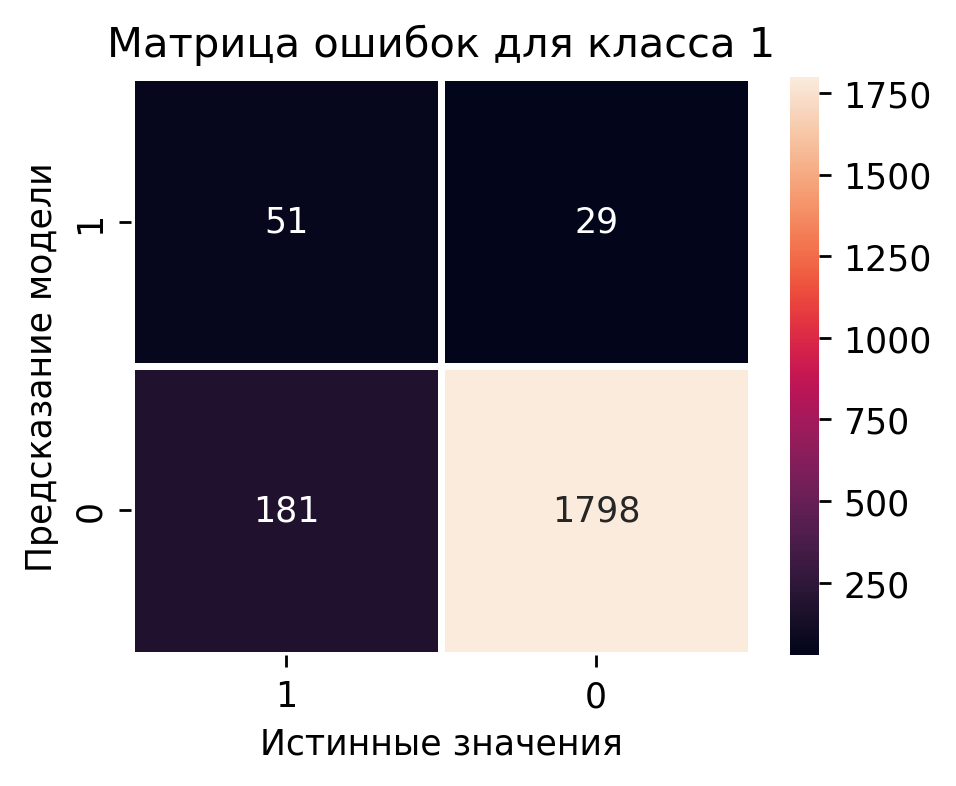

In [433]:
# Посмотрим матрицу ошибок
#Матрица ошибок, ручная реализация
tn_array, fp_array, fn_array, tp_array = [], [], [], []

splitter = KFold(n_splits=20, shuffle=True, random_state=42)


for train_index, val_index in splitter.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]


    model = LogisticRegression()
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    model.fit(X_train_scaled, y_train)

    tp = np.sum( (y_val == 1) & (model.predict(X_val_scaled) == 1) )
    fp = np.sum( (y_val == 0) & (model.predict(X_val_scaled) == 1) )
    fn = np.sum( (y_val == 1) & (model.predict(X_val_scaled) == 0) )
    tn = np.sum( (y_val == 0) & (model.predict(X_val_scaled) == 0) )

    tn_array.append(tn)
    fp_array.append(fp)
    fn_array.append(fn)
    tp_array.append(tp)
    
tn_average, fp_average, fn_average, tp_average = round(float(np.mean(tn_array))), round(float(np.mean(fp_array))), round(float(np.mean(fn_array))), round(float(np.mean(tp_array)))

conf_matrix = np.array([
    [tp_average, fp_average],
    [fn_average, tn_average]
])

fg = plt.figure(figsize=(4, 3), dpi=250)
plt.title("Матрица ошибок для класса 1")
sns.heatmap(conf_matrix, annot=True, linewidths=2, xticklabels=[1, 0], yticklabels=[1, 0], fmt='g')
plt.ylabel("Предсказание модели")
plt.xlabel("Истинные значения")

plt.show()

# Проблема

#### Модель имеет слабый recall, задача - найти как можно больше людей, чтобы они взяли депозит

##### План:

- Подбор лучших различных порогов отсечения
- Выбор лучшего из них

Основные метрики для порога 0.05
--------------------------------------------------------------
mean_precision_score: 0.1596
mean_recall_score: 0.8623
mean_accuracy_score: 0.4728
mean_f1_score: 0.2692
mean_log_loss_score: 19.0013
mean_roc_auc_score: 0.7844
--------------------------------------------------------------


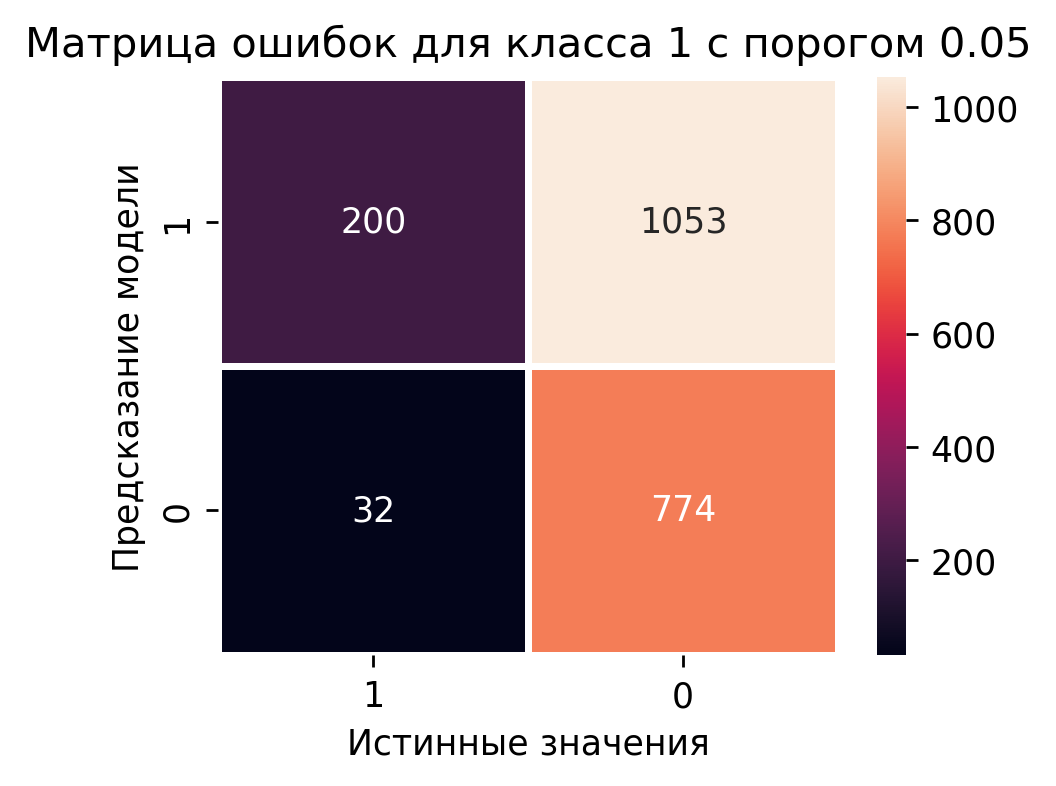

Основные метрики для порога 0.1
--------------------------------------------------------------
mean_precision_score: 0.2753
mean_recall_score: 0.6839
mean_accuracy_score: 0.7615
mean_f1_score: 0.3922
mean_log_loss_score: 8.5977
mean_roc_auc_score: 0.7844
--------------------------------------------------------------


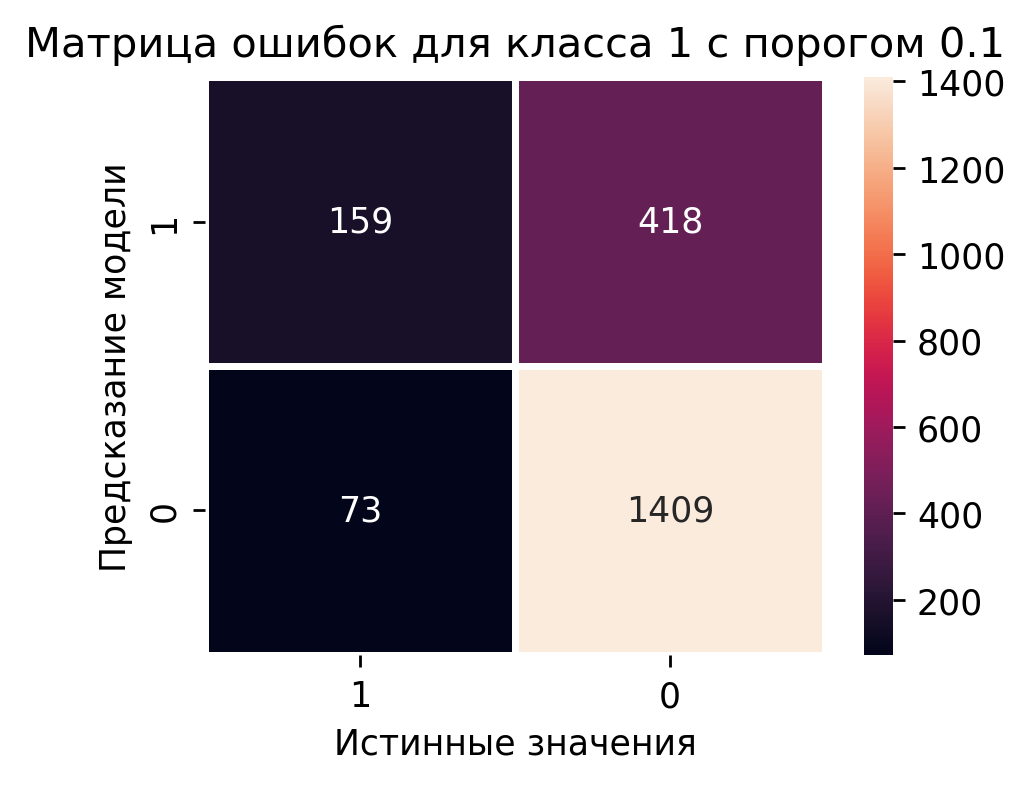

Основные метрики для порога 0.15
--------------------------------------------------------------
mean_precision_score: 0.3561
mean_recall_score: 0.6086
mean_accuracy_score: 0.832
mean_f1_score: 0.4489
mean_log_loss_score: 6.0566
mean_roc_auc_score: 0.7844
--------------------------------------------------------------


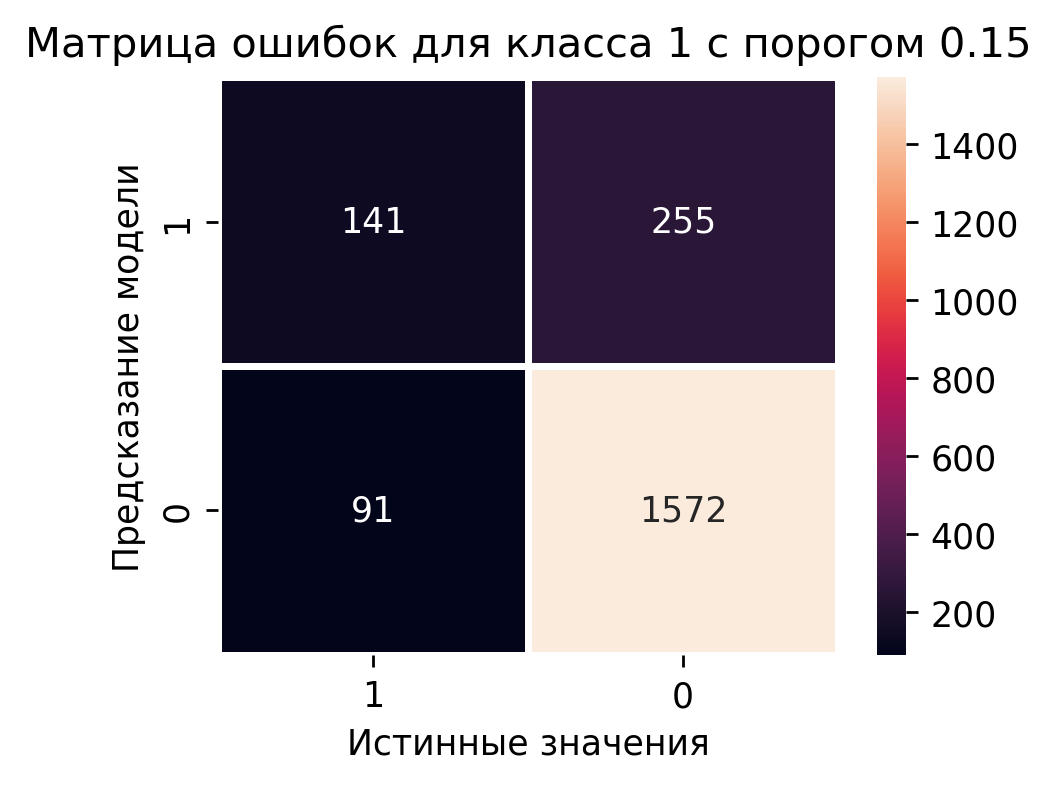

Основные метрики для порога 0.2
--------------------------------------------------------------
mean_precision_score: 0.4425
mean_recall_score: 0.5191
mean_accuracy_score: 0.8724
mean_f1_score: 0.4774
mean_log_loss_score: 4.6
mean_roc_auc_score: 0.7844
--------------------------------------------------------------


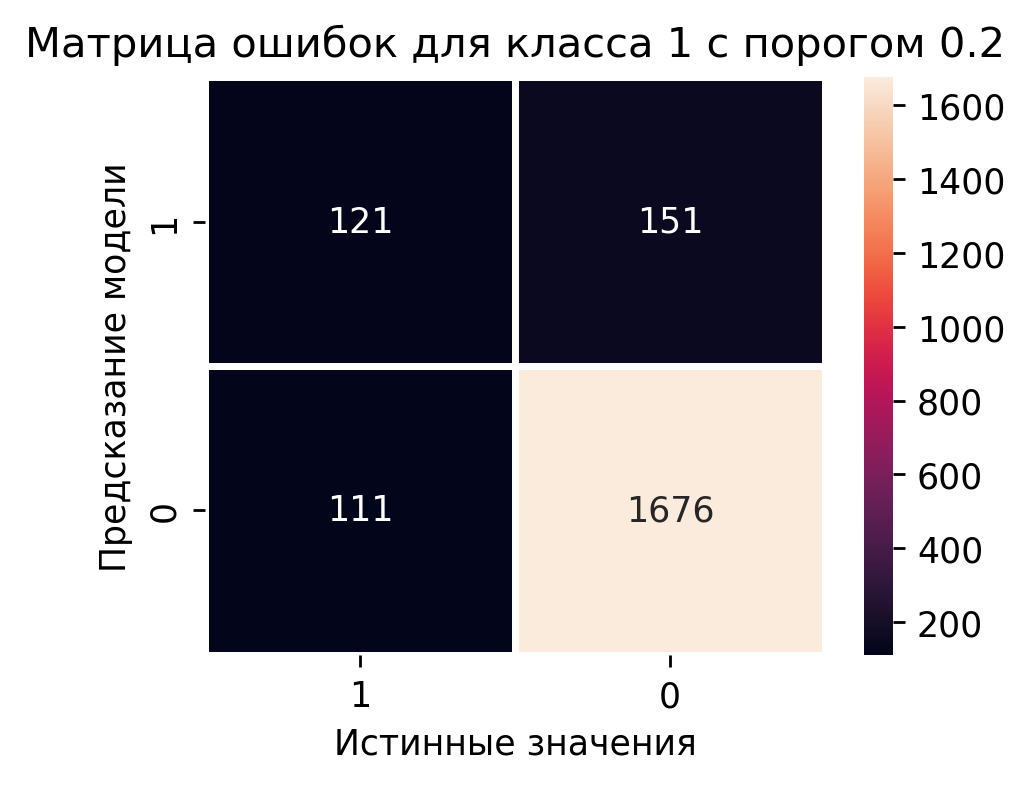

Основные метрики для порога 0.25
--------------------------------------------------------------
mean_precision_score: 0.4829
mean_recall_score: 0.4115
mean_accuracy_score: 0.8843
mean_f1_score: 0.4441
mean_log_loss_score: 4.1702
mean_roc_auc_score: 0.7844
--------------------------------------------------------------


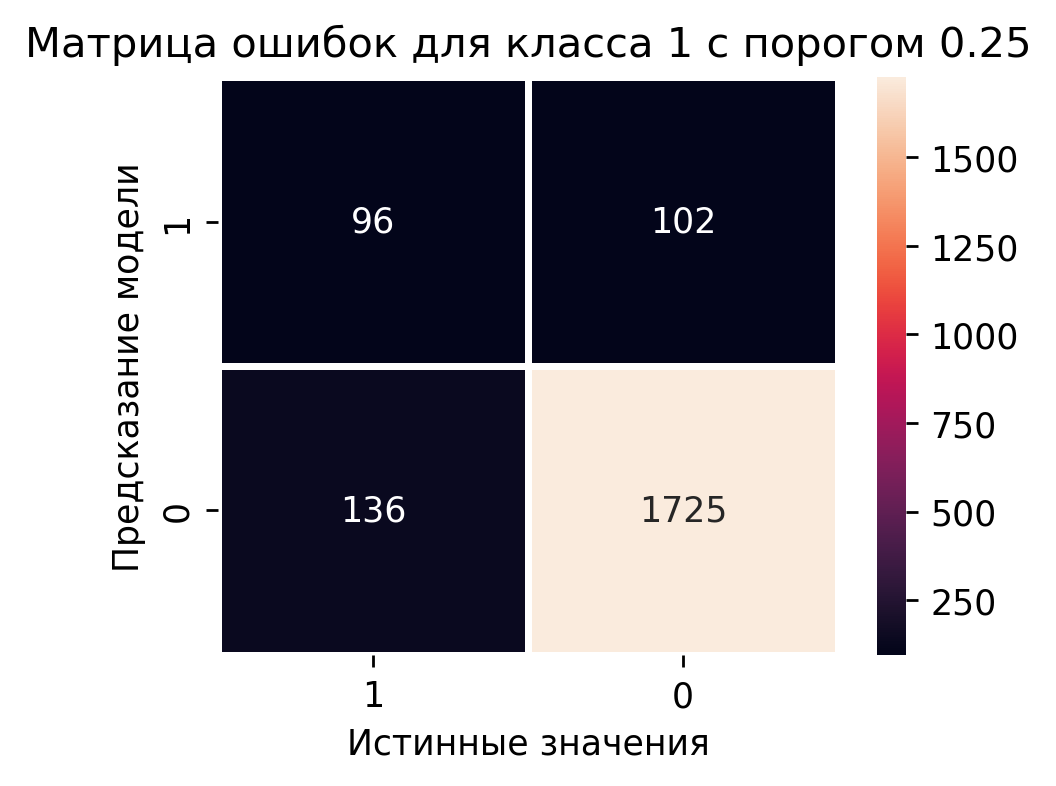

Основные метрики для порога 0.3
--------------------------------------------------------------
mean_precision_score: 0.5157
mean_recall_score: 0.3684
mean_accuracy_score: 0.89
mean_f1_score: 0.4294
mean_log_loss_score: 3.9654
mean_roc_auc_score: 0.7844
--------------------------------------------------------------


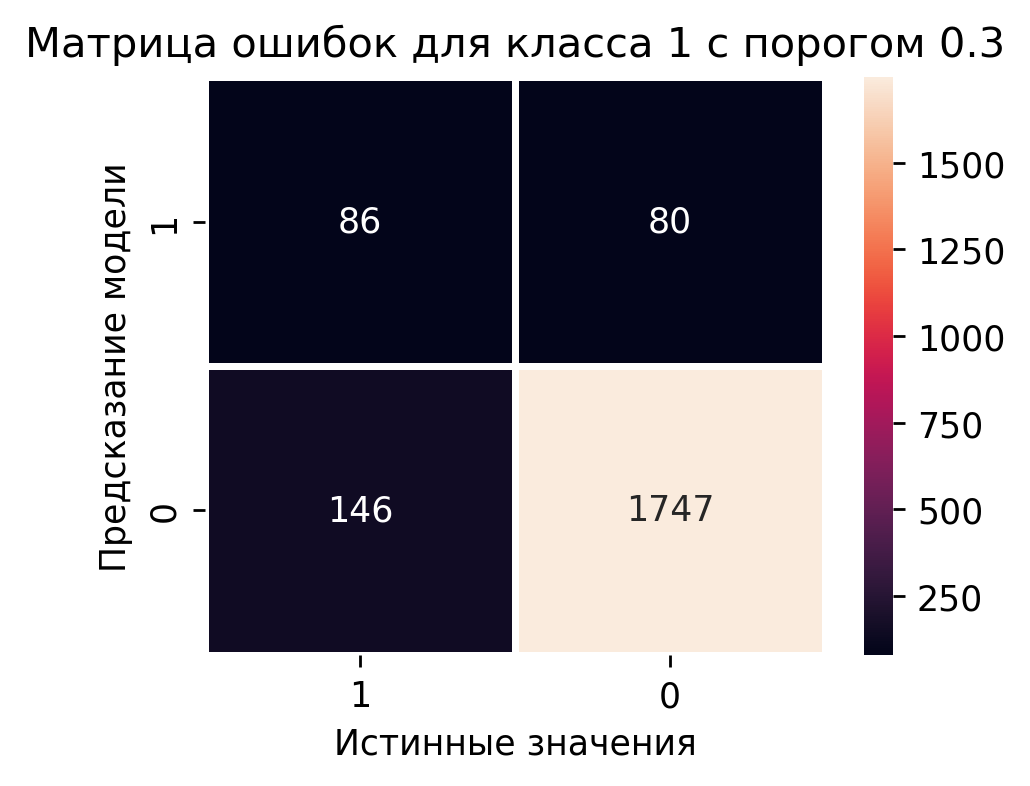

Основные метрики для порога 0.35
--------------------------------------------------------------
mean_precision_score: 0.5379
mean_recall_score: 0.331
mean_accuracy_score: 0.8927
mean_f1_score: 0.4092
mean_log_loss_score: 3.8691
mean_roc_auc_score: 0.7844
--------------------------------------------------------------


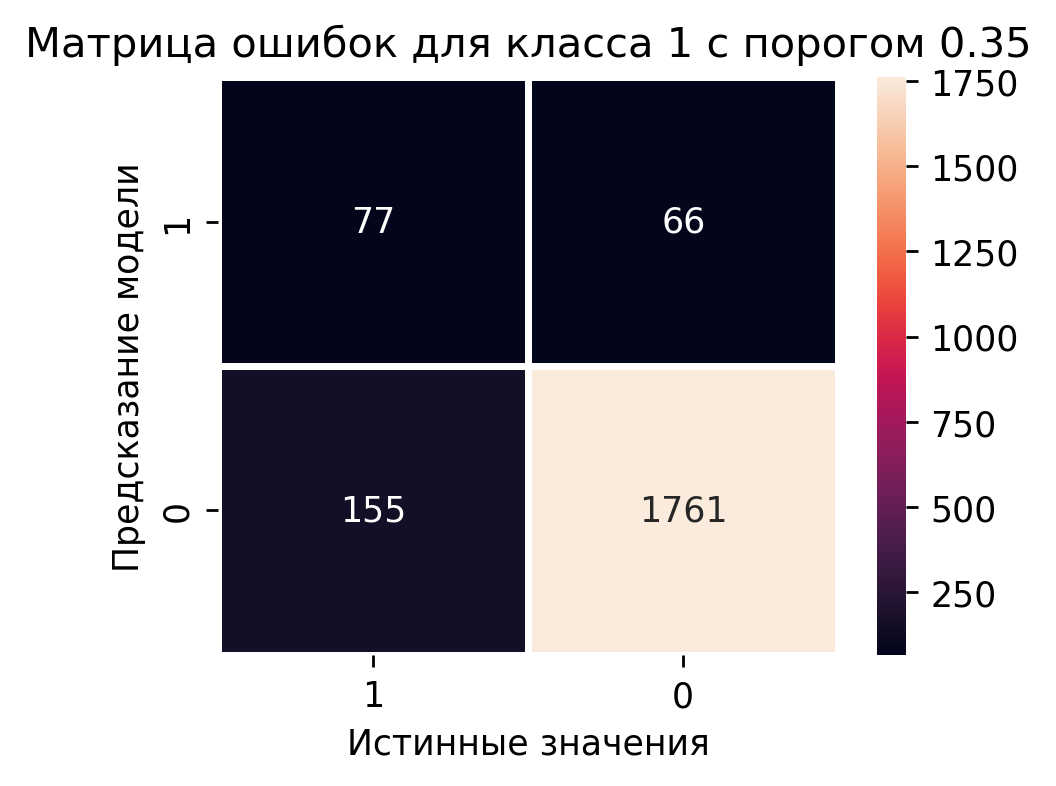

Основные метрики для порога 0.4
--------------------------------------------------------------
mean_precision_score: 0.56
mean_recall_score: 0.2931
mean_accuracy_score: 0.8944
mean_f1_score: 0.3844
mean_log_loss_score: 3.8052
mean_roc_auc_score: 0.7844
--------------------------------------------------------------


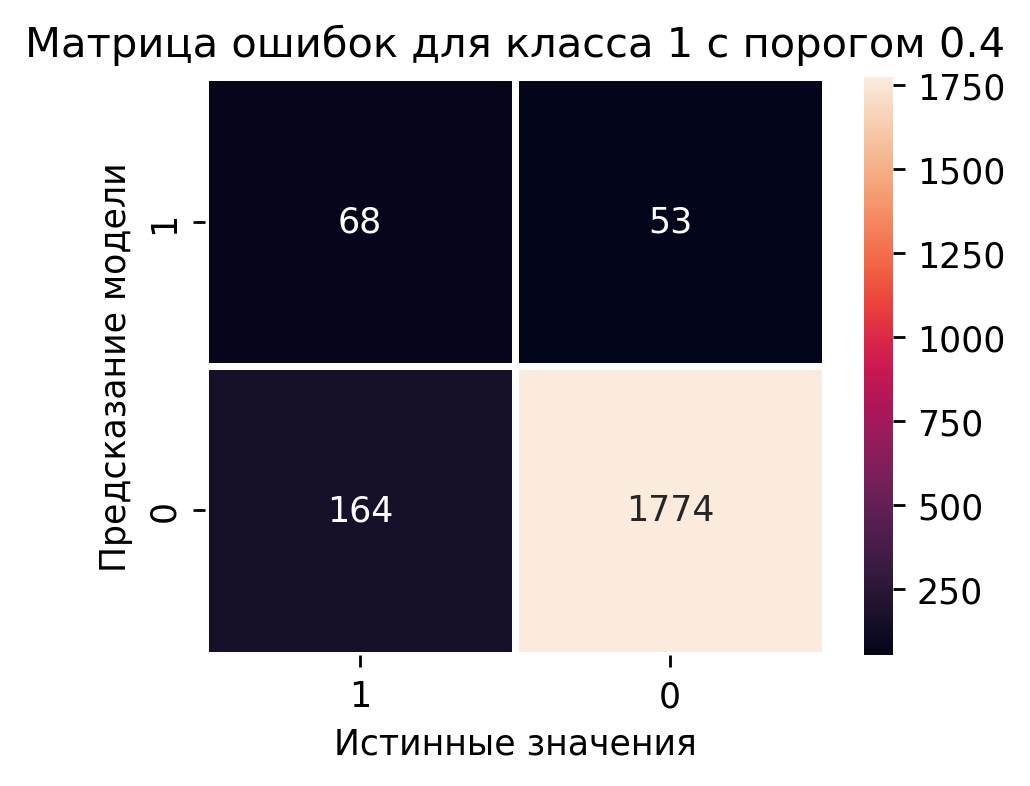

Основные метрики для порога 0.45
--------------------------------------------------------------
mean_precision_score: 0.5945
mean_recall_score: 0.2612
mean_accuracy_score: 0.8968
mean_f1_score: 0.3622
mean_log_loss_score: 3.7211
mean_roc_auc_score: 0.7844
--------------------------------------------------------------


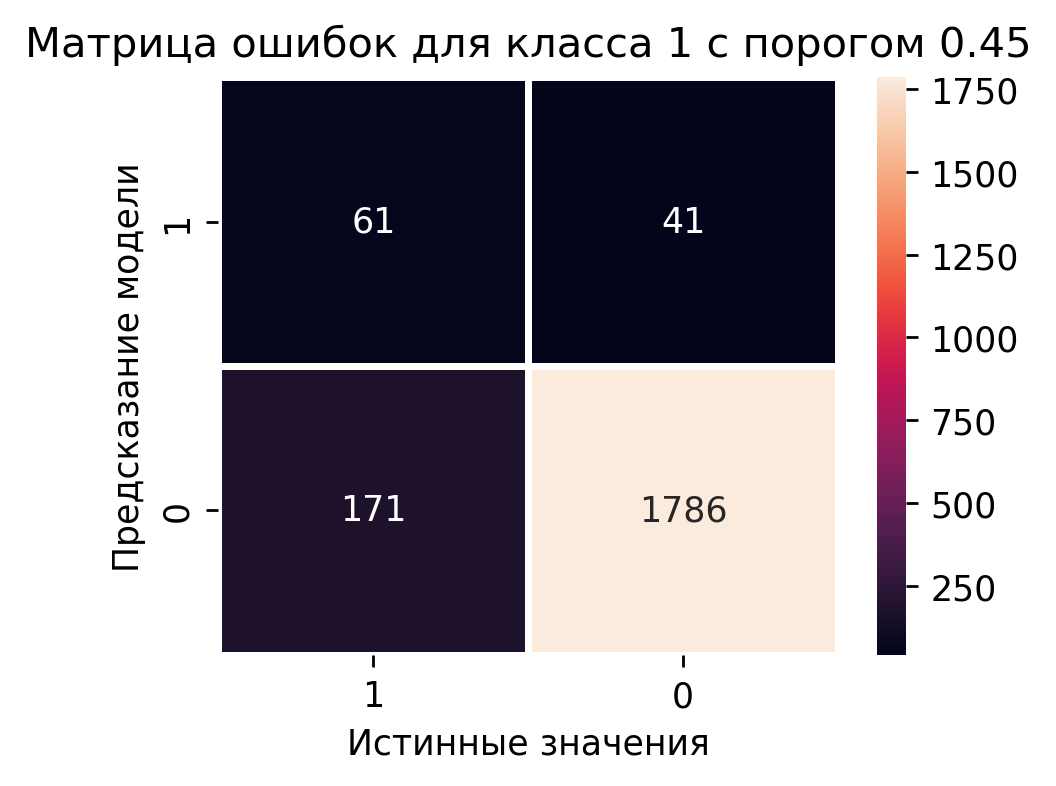

Основные метрики для порога 0.5
--------------------------------------------------------------
mean_precision_score: 0.634
mean_recall_score: 0.2187
mean_accuracy_score: 0.8979
mean_f1_score: 0.3247
mean_log_loss_score: 3.6817
mean_roc_auc_score: 0.7844
--------------------------------------------------------------


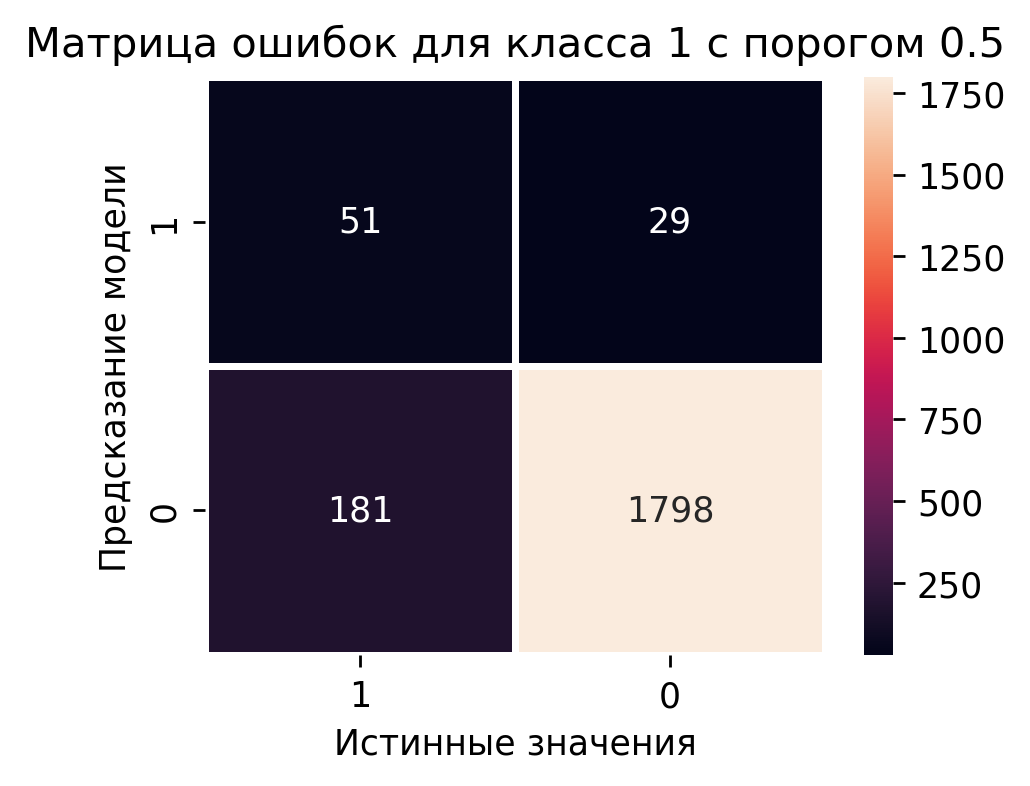

Основные метрики для порога 0.55
--------------------------------------------------------------
mean_precision_score: 0.6788
mean_recall_score: 0.1837
mean_accuracy_score: 0.8982
mean_f1_score: 0.2884
mean_log_loss_score: 3.6677
mean_roc_auc_score: 0.7844
--------------------------------------------------------------


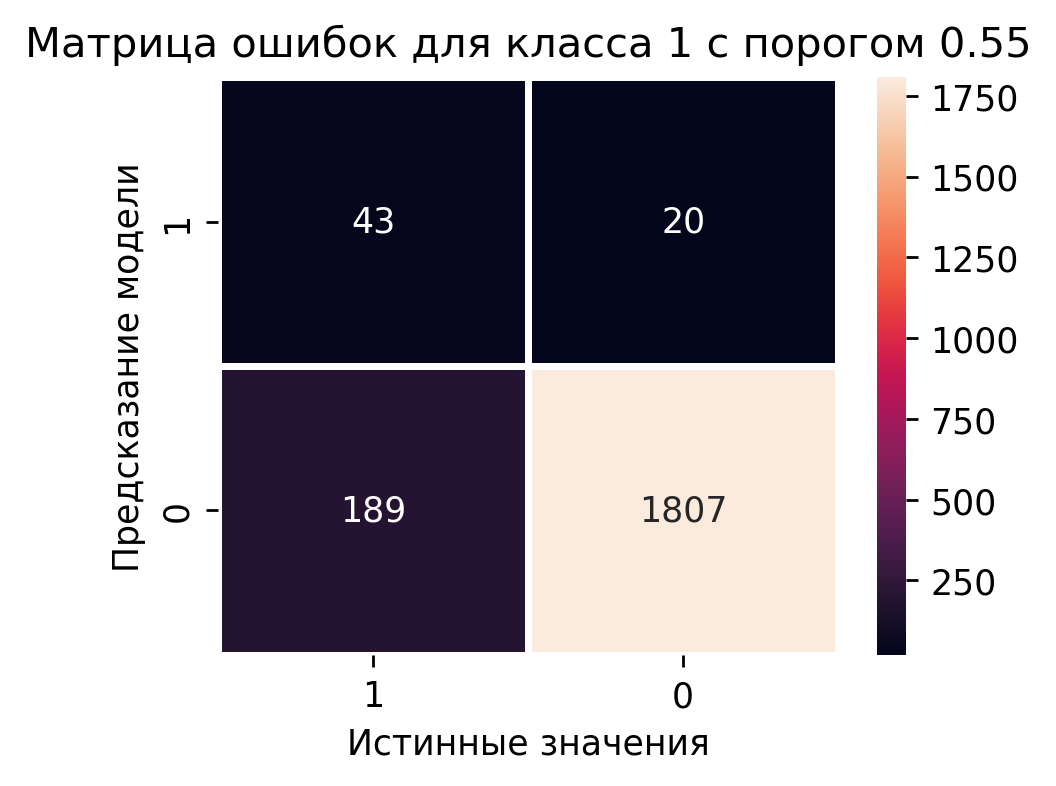

Основные метрики для порога 0.6
--------------------------------------------------------------
mean_precision_score: 0.724
mean_recall_score: 0.1582
mean_accuracy_score: 0.8983
mean_f1_score: 0.2587
mean_log_loss_score: 3.6651
mean_roc_auc_score: 0.7844
--------------------------------------------------------------


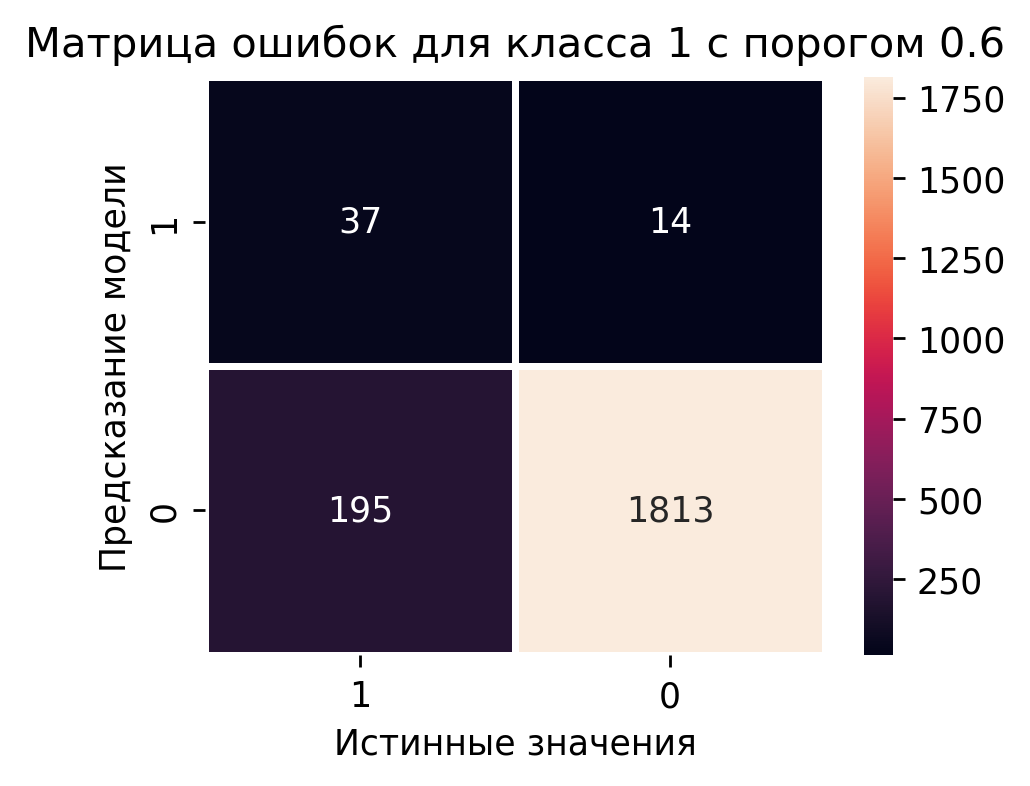

Основные метрики для порога 0.65
--------------------------------------------------------------
mean_precision_score: 0.7582
mean_recall_score: 0.1395
mean_accuracy_score: 0.898
mean_f1_score: 0.2347
mean_log_loss_score: 3.6782
mean_roc_auc_score: 0.7844
--------------------------------------------------------------


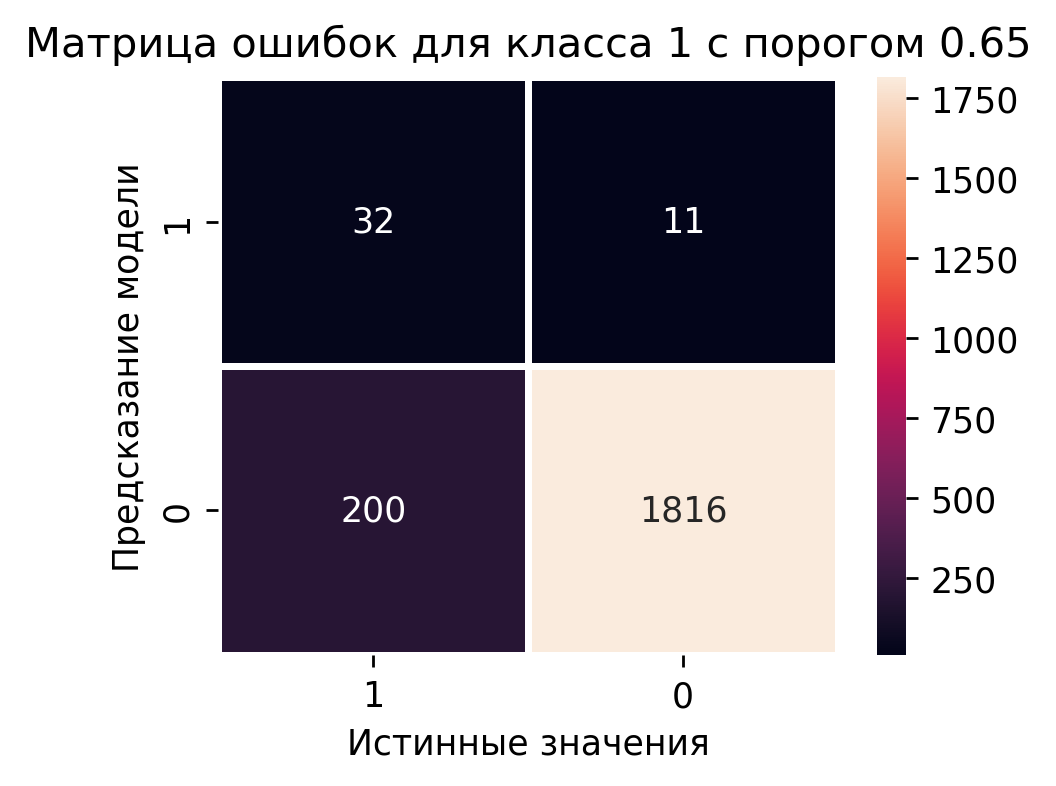

Основные метрики для порога 0.7
--------------------------------------------------------------
mean_precision_score: 0.7648
mean_recall_score: 0.1151
mean_accuracy_score: 0.8963
mean_f1_score: 0.1994
mean_log_loss_score: 3.7386
mean_roc_auc_score: 0.7844
--------------------------------------------------------------


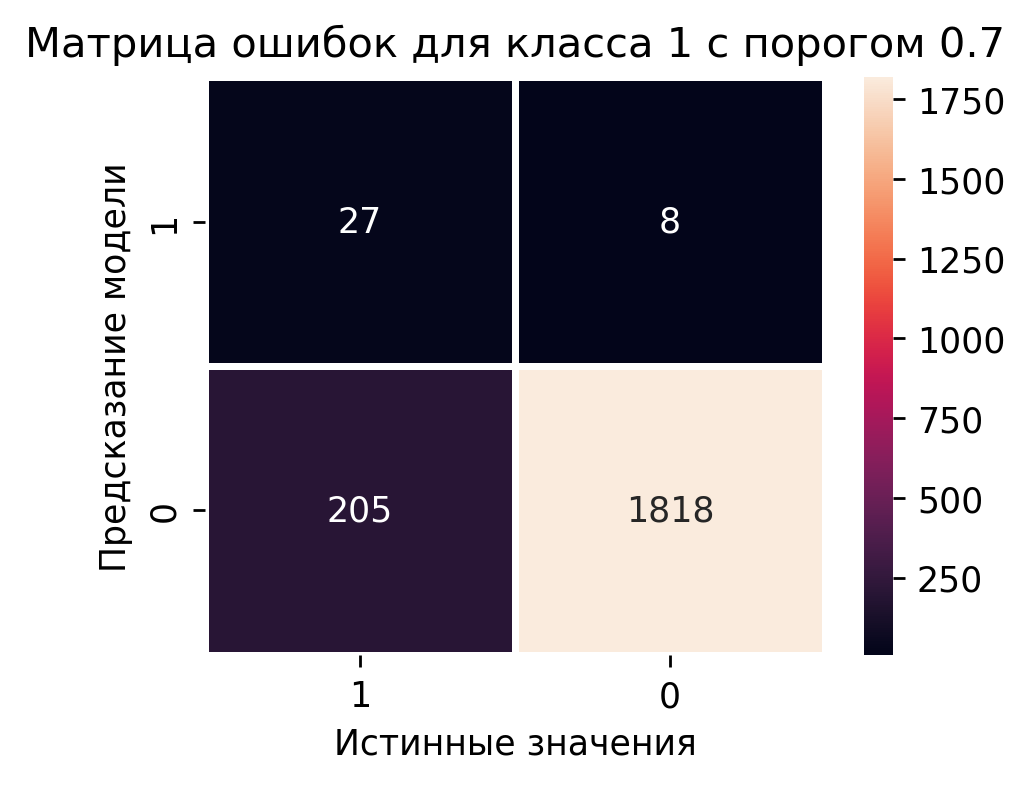

Основные метрики для порога 0.75
--------------------------------------------------------------
mean_precision_score: 0.7695
mean_recall_score: 0.0798
mean_accuracy_score: 0.8935
mean_f1_score: 0.144
mean_log_loss_score: 3.8384
mean_roc_auc_score: 0.7844
--------------------------------------------------------------


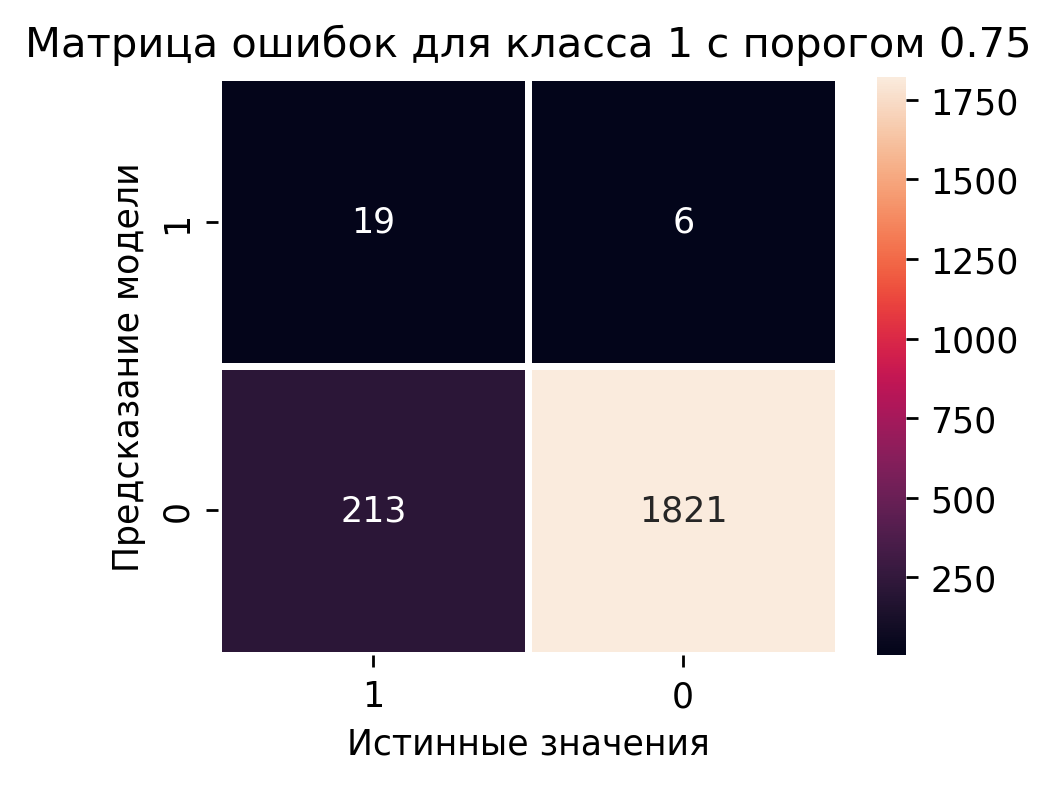

Основные метрики для порога 0.8
--------------------------------------------------------------
mean_precision_score: 0.7891
mean_recall_score: 0.0422
mean_accuracy_score: 0.8908
mean_f1_score: 0.0799
mean_log_loss_score: 3.9365
mean_roc_auc_score: 0.7844
--------------------------------------------------------------


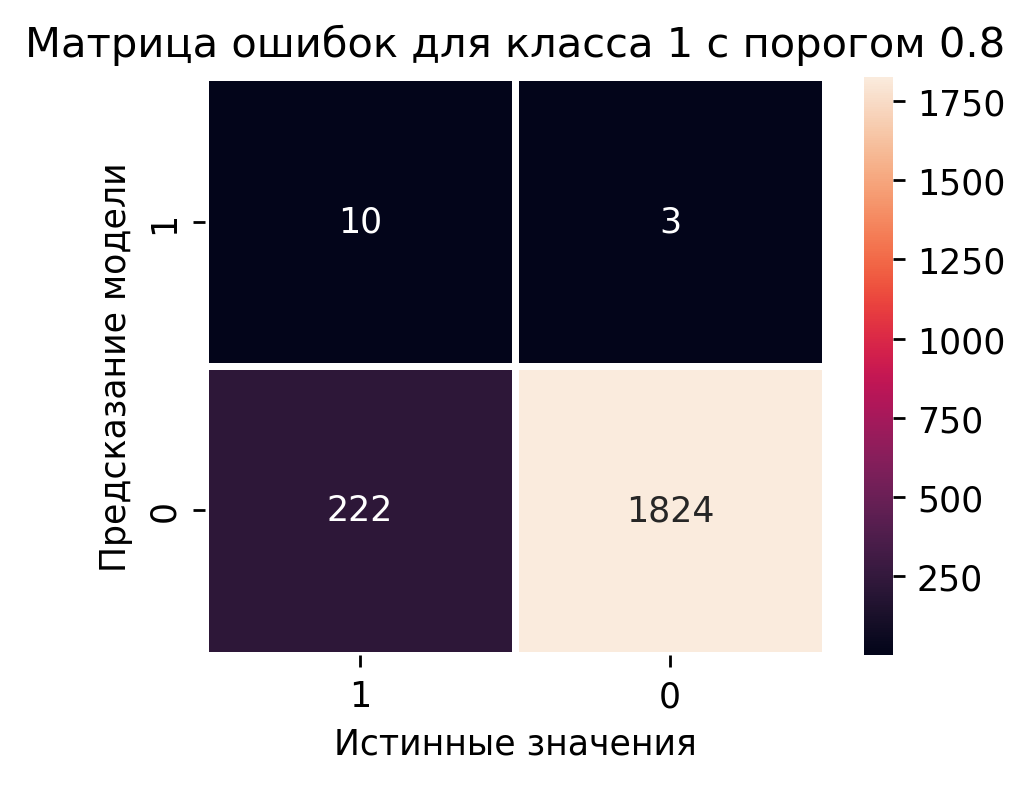

Основные метрики для порога 0.85
--------------------------------------------------------------
mean_precision_score: 0.8604
mean_recall_score: 0.0206
mean_accuracy_score: 0.8893
mean_f1_score: 0.0401
mean_log_loss_score: 3.9916
mean_roc_auc_score: 0.7844
--------------------------------------------------------------


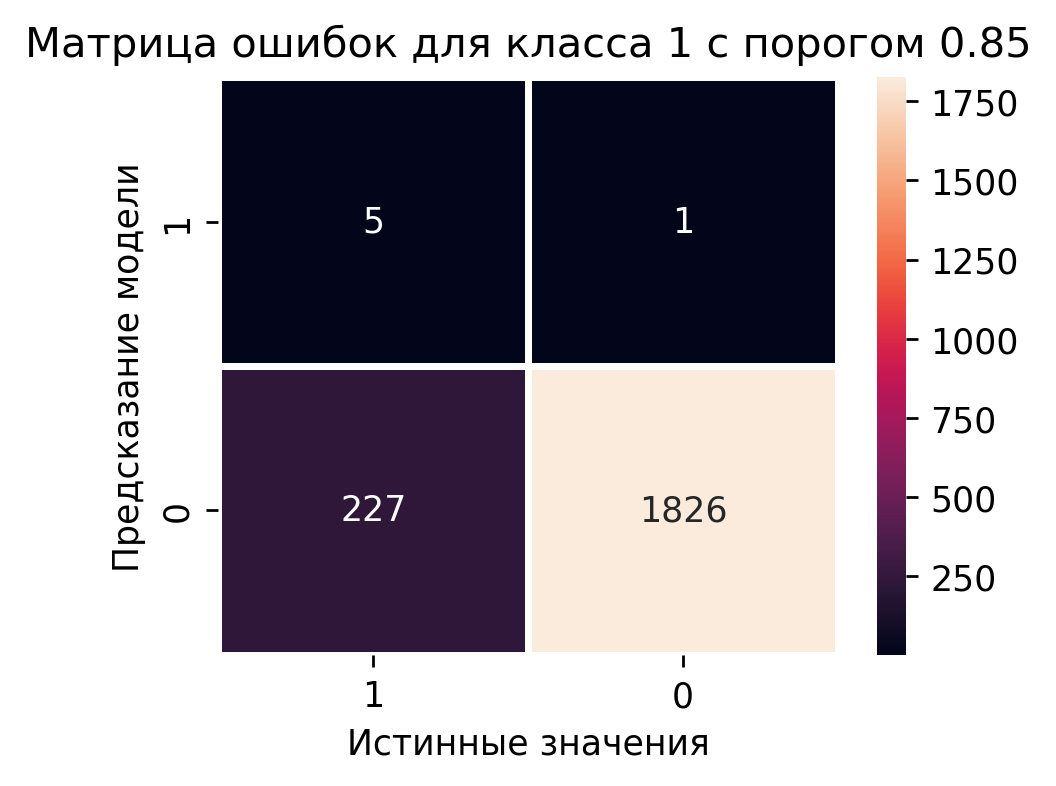

Основные метрики для порога 0.9
--------------------------------------------------------------
mean_precision_score: 0.3
mean_recall_score: 0.0013
mean_accuracy_score: 0.8875
mean_f1_score: 0.0026
mean_log_loss_score: 4.0564
mean_roc_auc_score: 0.7844
--------------------------------------------------------------


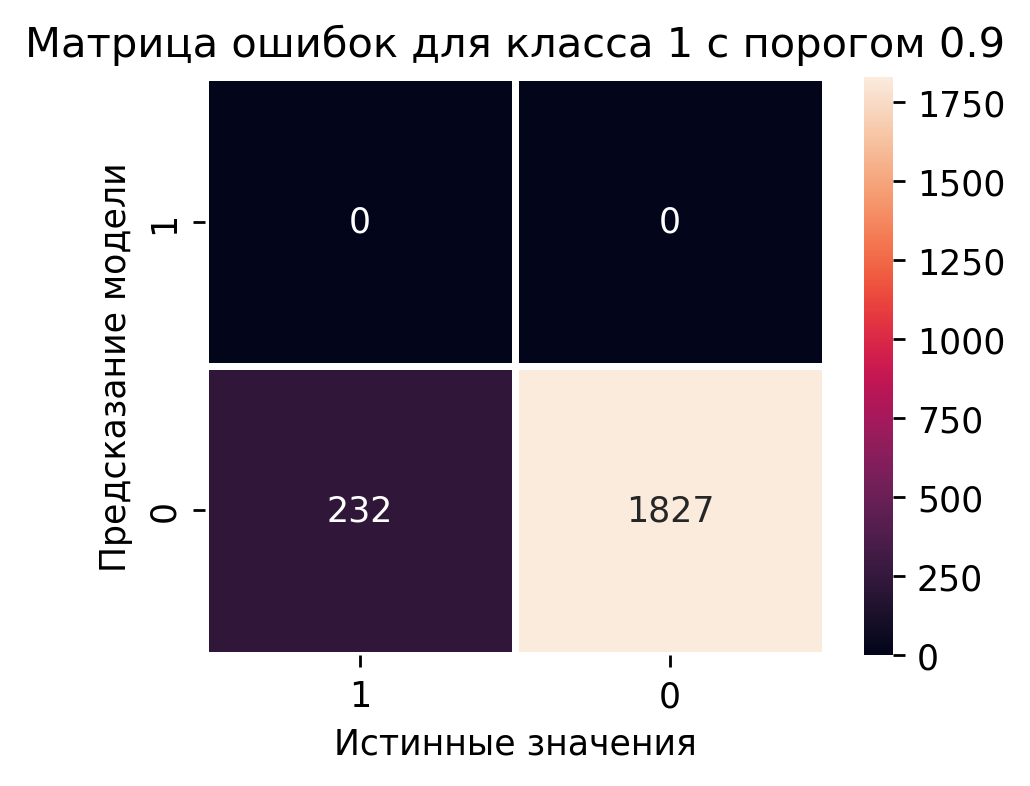

Основные метрики для порога 0.95
--------------------------------------------------------------
mean_precision_score: 0.0
mean_recall_score: 0.0
mean_accuracy_score: 0.8873
mean_f1_score: 0.0
mean_log_loss_score: 4.0608
mean_roc_auc_score: 0.7844
--------------------------------------------------------------


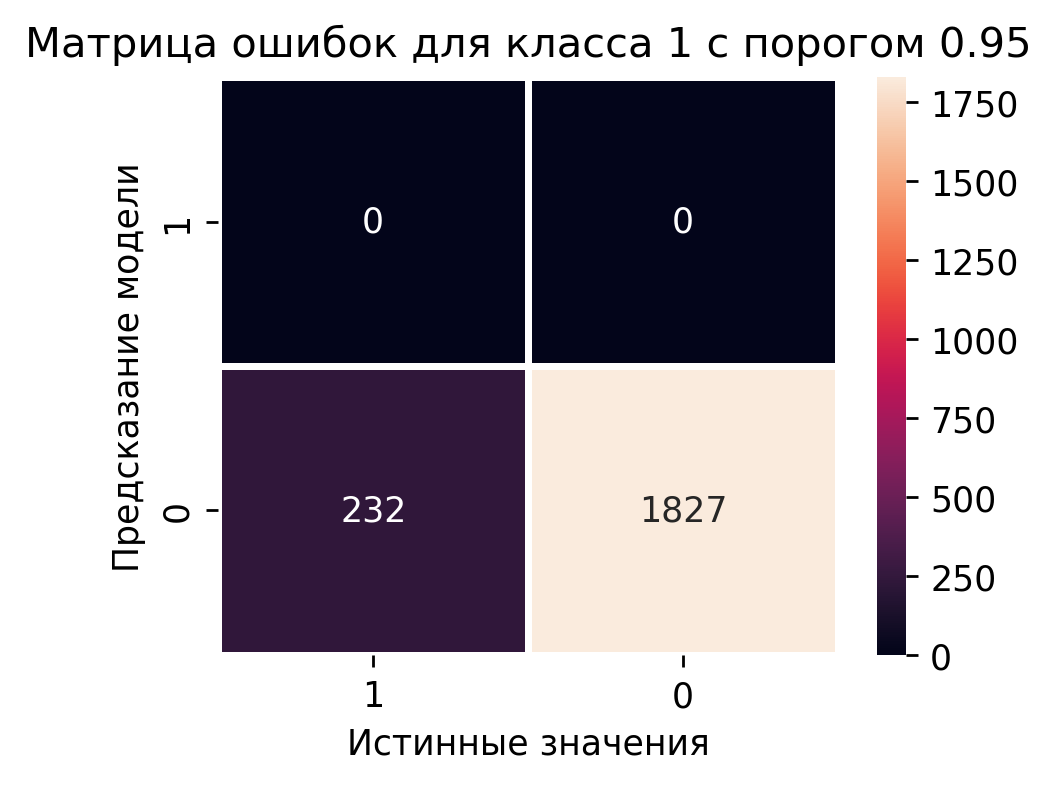

Основные метрики для порога 1.0
--------------------------------------------------------------
mean_precision_score: 0.0
mean_recall_score: 0.0
mean_accuracy_score: 0.8873
mean_f1_score: 0.0
mean_log_loss_score: 4.0608
mean_roc_auc_score: 0.7844
--------------------------------------------------------------


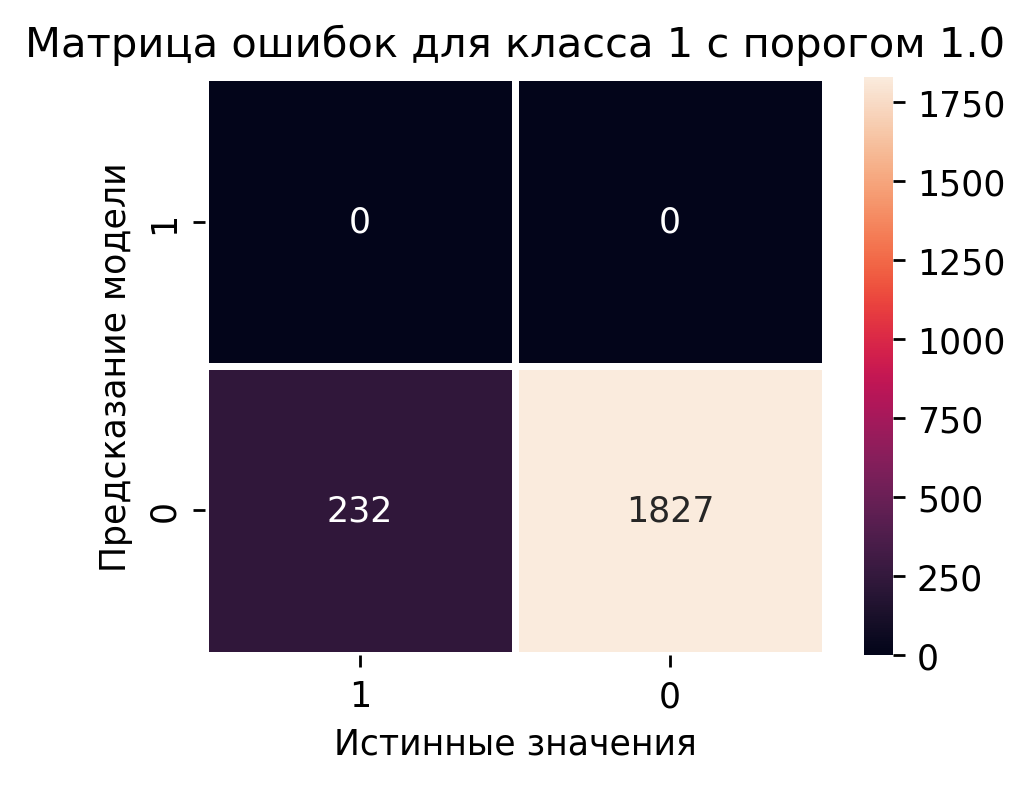

In [434]:
#Блок кода, который перебирает различные пороги отсечения на кросс_валидации, результаты получаются за счёт усреднения
#Вывод на экран основныых метрик и матрицы ошибки для каждого порога

splitter = KFold(n_splits=20, shuffle=True, random_state=42)

for i in range(1, 21):
    tn_array, fp_array, fn_array, tp_array = [], [], [], []
    precision_list, recall_list, accuracy_list, f1_list, log_loss_list, roc_auc_list = [], [], [], [], [], []
    for train_index, val_index in splitter.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]


        model = LogisticRegression()
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        model.fit(X_train_scaled, y_train)

        model_predict = np.where(model.predict_proba(X_val_scaled)[:, 1] >= 0.05 * i, 1, 0)

        tp = np.sum( (y_val == 1) & (model_predict == 1) )
        fp = np.sum( (y_val == 0) & (model_predict == 1) )
        fn = np.sum( (y_val == 1) & (model_predict == 0) )
        tn = np.sum( (y_val == 0) & (model_predict == 0) )

        tn_array.append(tn)
        fp_array.append(fp)
        fn_array.append(fn)
        tp_array.append(tp)

        precision_list.append(precision_score(y_val, model_predict))
        recall_list.append(recall_score(y_val, model_predict))
        accuracy_list.append(accuracy_score(y_val, model_predict))
        f1_list.append(f1_score(y_val, model_predict))
        log_loss_list.append(log_loss(y_val, model_predict))
        roc_auc_list.append(roc_auc_score(y_val, model.predict_proba(X_val_scaled)[:, 1]))
    
    tn_average, fp_average, fn_average, tp_average = round(float(np.mean(tn_array))), round(float(np.mean(fp_array))), round(float(np.mean(fn_array))), round(float(np.mean(tp_array)))

    conf_matrix = np.array([
        [tp_average, fp_average],
        [fn_average, tn_average]
    ])
    
    print(f"Основные метрики для порога {round(i * 0.05, 2)}")
    print("--------------------------------------------------------------")
    print(f"mean_precision_score: {round(float(np.mean(precision_list)), 4)}")
    print(f"mean_recall_score: {round(float(np.mean(recall_list)), 4)}")
    print(f"mean_accuracy_score: {round(float(np.mean(accuracy_list)), 4)}")
    print(f"mean_f1_score: {round(float(np.mean(f1_list)), 4)}")
    print(f"mean_log_loss_score: {round(float(np.mean(log_loss_list)), 4)}")
    print(f"mean_roc_auc_score: {round(float(np.mean(roc_auc_list)), 4)}")
    print("--------------------------------------------------------------")

    fg = plt.figure(figsize=(4, 3), dpi=250)
    plt.title(f"Матрица ошибок для класса 1 с порогом {round(i * 0.05, 2)}")
    sns.heatmap(conf_matrix, annot=True, linewidths=2, xticklabels=[1, 0], yticklabels=[1, 0], fmt='g')
    plt.ylabel("Предсказание модели")
    plt.xlabel("Истинные значения")

    plt.show()

In [435]:
# Найдем лучшие гиперпараметры для максимизиции f1_score 
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=25, shuffle=True)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = LogisticRegression()
model.fit(X_train_scaled, y_train)



print(classification_report(y_test, model.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      9154
           1       0.61      0.22      0.32      1140

    accuracy                           0.90     10294
   macro avg       0.76      0.60      0.63     10294
weighted avg       0.88      0.90      0.88     10294



In [437]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])

f1_score_list = (2 * precision * recall) / (precision + recall + 0.000000001)

print(f"Лушчий f1_score: {round(np.max(f1_score_list), 4)}")
print(f"Лучший порог отсечения, который максимизирует f1_score: {round(thresholds[np.argmax(f1_score_list)], 4)}")

Лушчий f1_score: 0.4768
Лучший порог отсечения, который максимизирует f1_score: 0.1882


Основные метрики для порога 0.1882
--------------------------------------------------------------
mean_precision_score: 0.4303
mean_recall_score: 0.5412
mean_accuracy_score: 0.8678
mean_f1_score: 0.4791
mean_log_loss_score: 4.7654
mean_roc_auc_score: 0.7844
--------------------------------------------------------------


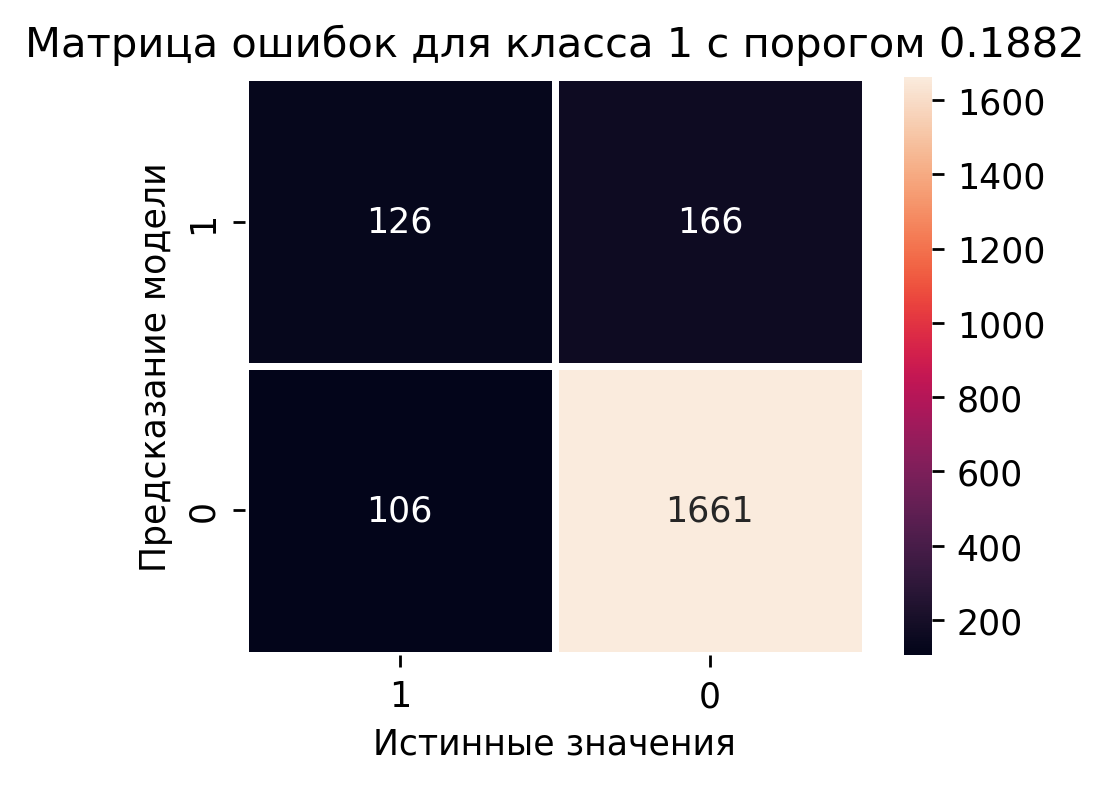

In [438]:
#Построим матрицу ошибок, для порога отсечения равного 0.1882

# Посмотрим матрицу ошибок
#Матрица ошибок, ручная реализация
tn_array, fp_array, fn_array, tp_array = [], [], [], []
precision_list, recall_list, accuracy_list, f1_list, log_loss_list, roc_auc_list = [], [], [], [], [], []

splitter = KFold(n_splits=20, shuffle=True, random_state=42)


for train_index, val_index in splitter.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]


    model = LogisticRegression(C=328, penalty="l2", solver="lbfgs")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    model.fit(X_train_scaled, y_train)

    model_predict = np.where(model.predict_proba(X_val_scaled)[:, 1] >= 0.1882, 1, 0)
    
    tp = np.sum( (y_val == 1) & (model_predict == 1) )
    fp = np.sum( (y_val == 0) & (model_predict == 1) )
    fn = np.sum( (y_val == 1) & (model_predict == 0) )
    tn = np.sum( (y_val == 0) & (model_predict == 0) )

    tn_array.append(tn)
    fp_array.append(fp)
    fn_array.append(fn)
    tp_array.append(tp)

    precision_list.append(precision_score(y_val, model_predict))
    recall_list.append(recall_score(y_val, model_predict))
    accuracy_list.append(accuracy_score(y_val, model_predict))
    f1_list.append(f1_score(y_val, model_predict))
    log_loss_list.append(log_loss(y_val, model_predict))
    roc_auc_list.append(roc_auc_score(y_val, model.predict_proba(X_val_scaled)[:, 1]))
    
tn_average, fp_average, fn_average, tp_average = round(float(np.mean(tn_array))), round(float(np.mean(fp_array))), round(float(np.mean(fn_array))), round(float(np.mean(tp_array)))

conf_matrix = np.array([
    [tp_average, fp_average],
    [fn_average, tn_average]
])

print(f"Основные метрики для порога {0.1882}")
print("--------------------------------------------------------------")
print(f"mean_precision_score: {round(float(np.mean(precision_list)), 4)}")
print(f"mean_recall_score: {round(float(np.mean(recall_list)), 4)}")
print(f"mean_accuracy_score: {round(float(np.mean(accuracy_list)), 4)}")
print(f"mean_f1_score: {round(float(np.mean(f1_list)), 4)}")
print(f"mean_log_loss_score: {round(float(np.mean(log_loss_list)), 4)}")
print(f"mean_roc_auc_score: {round(float(np.mean(roc_auc_list)), 4)}")
print("--------------------------------------------------------------")

fg = plt.figure(figsize=(4, 3), dpi=250)
plt.title("Матрица ошибок для класса 1 с порогом 0.1882")
sns.heatmap(conf_matrix, annot=True, linewidths=2, xticklabels=[1, 0], yticklabels=[1, 0], fmt='g')
plt.ylabel("Предсказание модели")
plt.xlabel("Истинные значения")

plt.show()

### Результаты
- Получили довольно одекватные резуультаты модели
### Дальшейшие действия
- Построение roc-auc
- Построение pr-auc

Общая площадь под графиком: 0.7853


<Figure size 2000x2000 with 0 Axes>

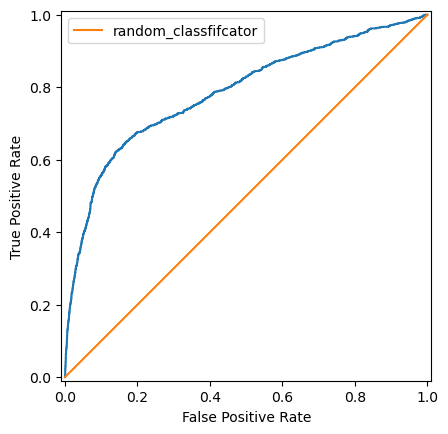

In [468]:
#Посроение roc-auc
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
shuared = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

print(f"Общая площадь под графиком: {round(shuared, 4)}")

fig = plt.figure(figsize=(8, 8), dpi=250)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), label="random_classfifcator")
plt.legend()
plt.show()


Общая площадь под графиком: 0.4211


<Figure size 2000x1500 with 0 Axes>

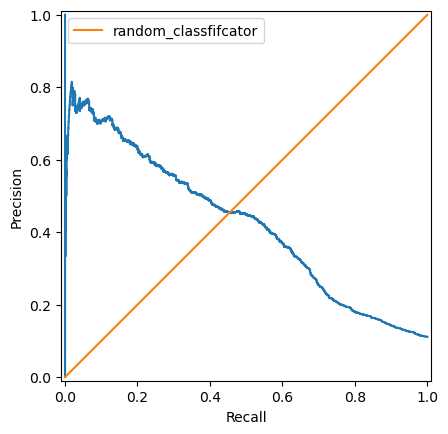

In [476]:
#Посроение pr-auc
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
average_precision_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
squared = average_precision_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

print(f"Общая площадь под графиком: {round(squared, 4)}")

fig = plt.figure(figsize=(8, 6), dpi=250)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), label="random_classfifcator")
plt.legend()
plt.show()


### Результаты
- roc-auc - показал довольно неплохие результаты
- pr-auc показал не такие уж хорошие результаты, так как там у нас был дисбаланс классов